## Imports and I/O

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mod_name_dict = {
    'OLS': 'Linear: OLS',
    'LASSO': 'Linear: OLS',
    'PLS': 'Linear: PC',
    'PCR': 'Linear: PC',
    'SVR': 'Linear: SVR',
    'RF': 'Non-parametric: DT',
    'GBR': 'Non-parametric: DT',
    'HGBR': 'Non-parametric: DT'
}

cv_name_dict = {
    'Plot': 'Plot\n(random k-fold)',
    'Spatial': 'Pasture\n(spatial block)',
    'Ecosite': 'Ecosite\n(spatial strata)',
    'Year': 'Year\n(temporal)',
    'Kmeans': 'Kmeans\n(classified)'
}

In [3]:
df_plot = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_tmp.csv')
df_spatial = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_tmp.csv')
df_ecosite = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_tmp.csv')
df_year = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_tmp.csv')

t_plot = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Plot_tuneby_Plot_results_plot_yrly.csv')
t_spatial = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_spatial_tuneby_spatial_results_plot_yrly.csv')
t_ecosite = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_ecosite_tuneby_ecosite_results_plot_yrly.csv')
t_year = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_results_plot_yrly.csv')
t_kmeans = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_' +
                               'tuneby_Kmeans_results_plot_yrly.csv')

In [4]:
df_plot['cv'] = 'Plot'
df_spatial['cv'] = 'Spatial'
df_ecosite['cv'] = 'Ecosite'
df_year['cv'] = 'Year'

t_plot['cv'] = 'Plot'
t_spatial['cv'] = 'Spatial'
t_ecosite['cv'] = 'Ecosite'
t_year['cv'] = 'Year'
t_kmeans['cv'] = 'Kmeans'

In [5]:
df_plot['kfold'] = pd.Categorical(df_plot['kfold'].astype(str),
                                  ['kfold'+str(x+1) for x in np.arange(len(df_plot['kfold'].unique()))])

In [6]:
t_all = pd.concat([t_plot, t_spatial, t_ecosite, t_year, t_kmeans])
t_all = t_all[t_all['Source'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR'])].copy()
t_all['Source_type'] = t_all['Source'].apply(lambda x: mod_name_dict[x])
t_all['cv'] = t_all['cv'].apply(lambda x: cv_name_dict[x])
#t_all['cv'] = t_all['cv'].apply(lambda x: 'Pasture\n(block)' if x == 'Spatial' else 'Plot\n(random k-fold)' if x == 'Plot' else x)
t_all.columns

Index(['Source', 'kfold', 'MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r', 'cv',
       'spatial', 'ecosite', 'Source_type'],
      dtype='object')

In [7]:
t_all.loc[t_all['R^2'] < 0, 'R^2'] = 0

In [8]:
df_boots_yr_transect = pd.read_csv('./results/tmp/vor_bootstrap_by_year_transect_v2.csv')
df_boots_nyrs = pd.read_csv('./results/tmp/vor_bootstrap_pred_9yrs_transect.csv')

In [9]:
df_boots_yr_transect = df_boots_yr_transect[df_boots_yr_transect['Model'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR'])].copy()
df_boots_yr_transect['Source_type'] = df_boots_yr_transect['Model'].apply(lambda x: mod_name_dict[x])

In [10]:
yr_n = 10

In [11]:
#all(df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] == yr_n - 1].groupby('Model').count()['numb_yrs']/yr_n == 120)

In [12]:
df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] == yr_n - 1].groupby('Model').count()['numb_yrs']/yr_n

Model
HGBR     1.0
LASSO    1.0
OLS      1.0
PCR      1.0
PLS      1.0
RF       1.0
SVR      1.0
Name: numb_yrs, dtype: float64

In [13]:
t_all['MAE_pct'] = t_all['MAE_pct']*100

In [14]:
keep_fracs = [100, 99, 95, 85, 75, 50, 10, 1]
for f in keep_fracs:
    if f == 100:
        df_kmeans = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_tuneby_Kmeans_tmp.csv')
    else:
        df_kmeans_tmp = pd.read_csv('./results/tmp/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_r' + 
                                    str(f) + 
                                    '_tuneby_Kmeans_r' + 
                                    str(f) + 
                                    '_tmp.csv')
        df_kmeans_tmp = df_kmeans_tmp.rename(columns={'kfold': 'kfold_r' + str(f)})
        df_kmeans = pd.merge(df_kmeans, df_kmeans_tmp[['Id', 'Date_mean', 'kfold_r'+str(f)]],
                             on=['Id', 'Date_mean'], how='left')

In [15]:
df_kmeans['cv'] = 'kmeans'

In [16]:
df_kmeans.columns

Index(['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High',
       'Biomass_kg_ha', 'geometry', 'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2',
       'sqrt_Biomass_kg_ha', 'Plot', 'Kmeans', 'CPER_2022', 'OLS_2022', 'OLS',
       'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR', 'kfold', 'kfold_r99',
       'kfold_r95', 'kfold_r85', 'kfold_r75', 'kfold_r50', 'kfold_r10',
       'kfold_r1', 'cv'],
      dtype='object')

## Aggregated models

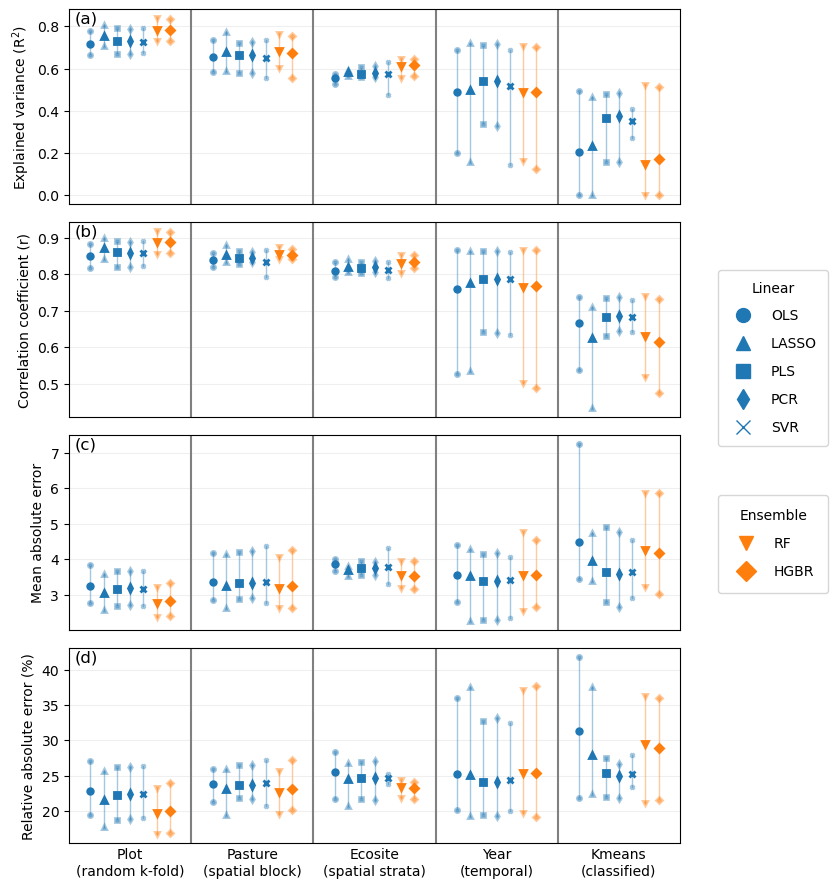

In [167]:
from matplotlib.lines import Line2D

#marker_list = ["o", "o", "o", "x", "o", "o", "x"]
#marker_list = ["^", "^", "^", "^", "^", "s", "s"]
marker_list = ["o", "^", "s", "d", "x", "v", "D"]
marker_colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']

p_kwargs = dict(
    palette=marker_colors,
    markers=marker_list,
    dodge=0.65,
    linestyles="none", 
    #errorbar=None,
    legend=False
)

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(7,9), sharex=True)
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[0])
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[0])
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[0])

sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[1])
sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[1])
sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[1])

sns.pointplot(x='cv', y='MAE', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[2])
sns.pointplot(x='cv', y='MAE', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[2])
sns.pointplot(x='cv', y='MAE', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[2])


sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[3])
sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[3])
sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[3])

axs[0].set_ylabel('Explained variance (R$^2$)')
axs[1].set_ylabel('Correlation coefficient (r)')
axs[2].set_ylabel('Mean absolute error')
axs[3].set_ylabel('Relative absolute error (%)')

axs[3].set_xlabel('')
for label in axs[2].get_xticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment('center')
for idx, ax in enumerate(axs.flatten()):
    ax.grid(visible=True, which='major', axis='y', alpha=0.2)
    ax.tick_params(axis='x', length=0)
    for v in [0.5, 1.5, 2.5, 3.5]:
        ax.axvline(v, color='grey')
    ax.annotate(['(a)', '(b)', '(c)', '(d)'][idx], (0.01, 0.93), xycoords='axes fraction', fontsize=12)
#leg = axs[0].legend()
#fig.legend()
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=t_all['Source'].unique()[m_idx],
                                  mfc=marker_colors[m_idx],
                                  mec=marker_colors[m_idx],
                                  markersize=10))
#fig.legend(handles=legend_elements,
#           loc='upper center', ncols=len(marker_list),
#          bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.legend(handles=legend_elements[:-2],
           title='Linear',
           loc='outside right upper', ncols=1,
           bbox_to_anchor=(1.2, 0.7), 
           labelspacing=1,
           handletextpad=1,
           borderpad=0.8)
fig.legend(handles=legend_elements[-2:],
           title='Ensemble',
           loc='outside right upper', ncols=1,
           bbox_to_anchor=(1.2, 0.45), 
           labelspacing=1,
           handletextpad=1,
           borderpad=1.0)
plt.tight_layout()
plt.savefig('./results/figures/Fig4_model_performance_by_cv.png', dpi=300, bbox_inches='tight')

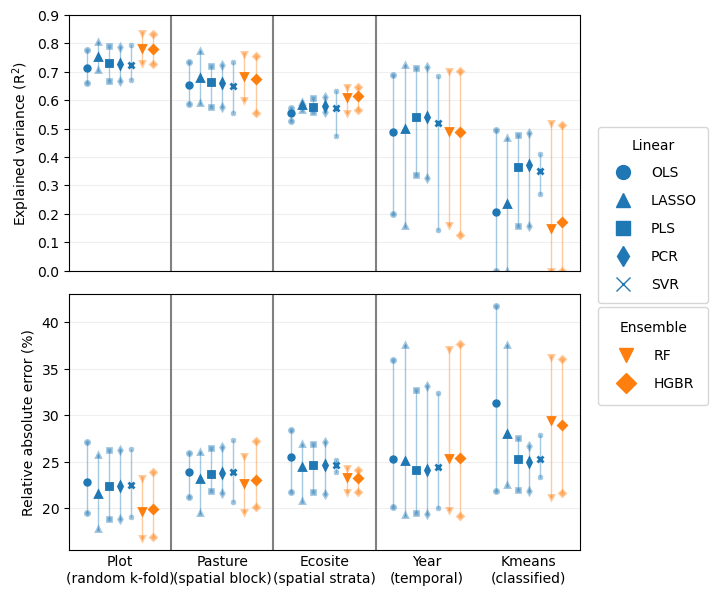

In [18]:
from matplotlib.lines import Line2D

#marker_list = ["o", "o", "o", "x", "o", "o", "x"]
#marker_list = ["^", "^", "^", "^", "^", "s", "s"]
marker_list = ["o", "^", "s", "d", "x", "v", "D"]
marker_colors = ['tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:blue', 'tab:orange', 'tab:orange']

p_kwargs = dict(
    palette=marker_colors,
    markers=marker_list,
    dodge=0.65,
    linestyles="none", 
    #errorbar=None,
    legend=False
)

fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(6,6), sharex=True)
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[0])
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[0])
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[0])

sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=lambda x: (np.min(x), np.max(x)),
              err_kws=dict(linewidth=1, alpha=0.4),
              markersize=4, 
              estimator='mean',
              ax=axs[1])
sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='max',
              alpha=0.4,
              ax=axs[1])
sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source', 
              **p_kwargs,
              errorbar=None,
              markersize=3, 
              estimator='min',
              alpha=0.4,
              ax=axs[1])

axs[0].set_ylabel('Explained variance (R$^2$)')
axs[1].set_ylabel('Relative absolute error (%)')

axs[0].set_ylim((0.0, 0.9))

axs[1].set_xlabel('')

for ax in axs.flatten():
    ax.grid(visible=True, which='major', axis='y', alpha=0.2)
    ax.tick_params(axis='x', length=0)
    for v in [0.5, 1.5, 2.5]:
        ax.axvline(v, color='grey')
#leg = axs[0].legend()
#fig.legend()
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=t_all['Source'].unique()[m_idx],
                                  mfc=marker_colors[m_idx],
                                  mec=marker_colors[m_idx],
                                  markersize=10))
#fig.legend(handles=legend_elements,
#           loc='upper center', ncols=len(marker_list),
#          bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.legend(handles=legend_elements[:-2],
           title='Linear',
           loc='outside right upper', ncols=1,
           bbox_to_anchor=(1.2, 0.8), 
           labelspacing=1,
           handletextpad=1,
           borderpad=0.8)
fig.legend(handles=legend_elements[-2:],
           title='Ensemble',
           loc='outside right upper', ncols=1,
           bbox_to_anchor=(1.2, 0.5), 
           labelspacing=1,
           handletextpad=1,
           borderpad=1.0)
plt.tight_layout()

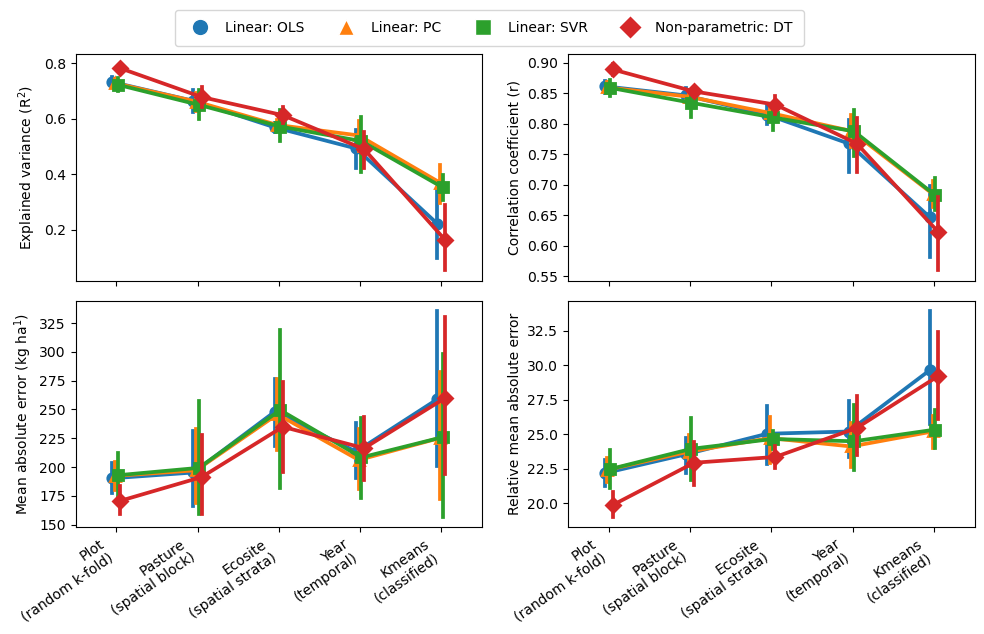

In [19]:
from matplotlib.lines import Line2D

marker_list = ["o", "^", "s", "D"]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharex=True)
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source_type', 
              ax=axs[0,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='cv', y='r', data=t_all, hue='Source_type',
              ax=axs[0,1], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='cv', y='MAE_bt', data=t_all, hue='Source_type', 
              ax=axs[1,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='cv', y='MAE_pct', data=t_all, hue='Source_type', 
              ax=axs[1,1], legend=False, markers=marker_list, dodge=True)
axs[0,0].set_ylabel('Explained variance (R$^2$)')
axs[0,1].set_ylabel('Correlation coefficient (r)')
axs[1,0].set_ylabel('Mean absolute error (kg ha$^1$)')
axs[1,1].set_ylabel('Relative mean absolute error')
for ax in axs[1,:].flatten():
    ax.set_xlabel('')
    for label in ax.get_xticklabels():
        label.set_rotation(35)
        label.set_ha('right')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=t_all['Source_type'].unique()[m_idx],
                                  markerfacecolor=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
plt.tight_layout()

## PLS/PCA bi-plots

In [20]:
#https://stackoverflow.com/questions/39216897/plot-pca-loadings-and-loading-in-biplot-in-sklearn-like-rs-autoplot
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl

In [21]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [22]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [23]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from matplotlib.lines import Line2D
import re

In [28]:
def plot_pcs(df, ax, var_names, pc_type, var_reduce_type, k, vars_of_interest, title=None, n_comps=None, n_std=2.0, pcs=[1,2], topk=2):    
    # load data
    X = df[var_names]
    y = df['sqrt_Biomass_kg_ha']
    features = var_names
    X_scaled = StandardScaler().fit_transform(X)
    if n_comps is None:
        n_comps = len(var_names)
    pcs_idx = [i-1 for i in pcs]
    if pc_type == 'pca':
        features +=  ['sqrt_Biomass_kg_ha']
        # analysis
        pca = PCA(n_components=10).fit(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        X_reduced = pca.transform(np.concatenate([X_scaled, np.expand_dims(y, 1)], axis=1))
        # results
        scores = X_reduced[:, pcs_idx]
        loadings = pca.components_[pcs_idx].T
        pvars = pca.explained_variance_ratio_[pcs_idx] * 100
    elif pc_type == 'pls':
        pls2 = PLSRegression(n_components=n_comps)
        pls2.fit(X_scaled, y)
        loadings = pls2.x_loadings_[:,pcs_idx]
        scores = pls2.x_scores_[:, pcs_idx]
        naY = y
        r2_scores = []
        for i in range(0,n_comps):
            Y_pred=np.dot(pls2.x_scores_[:,i].reshape(-1,1),pls2.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y,Y_pred),3))
        pvars = np.array(r2_scores)[pcs_idx]*100
    
    if var_reduce_type == 'top_k':
        tops = (loadings ** 2).sum(axis=1).argsort()[-topk:]
    elif var_reduce_type == 'manual':
        tops = [i for i, value in enumerate(features) if value in vars_of_interest]
    
    if pc_type == 'pca':
        tops = [x for x in tops if (x+1) != len(features)]
    arrows = loadings[tops]
    arrows /= np.sqrt((arrows ** 2).sum(axis=0))
    arrows *= np.abs(scores).max(axis=0)
    
    if pc_type == 'pca':
        bm_arrow = loadings[-1]
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
    elif pc_type == 'pls':
        bm_arrow = pls2.y_loadings_[:,pcs_idx].squeeze()
        bm_arrow /= np.sqrt((bm_arrow ** 2).sum(axis=0))
        bm_arrow *= np.abs(scores).max(axis=0)
        #bm_arrow *= np.abs(pls2.y_scores_).max(axis=0)
    
    for idx, i in enumerate(pcs):
        df['PC'+str(i)] = scores[:,idx]
    
    #plt.scatter(scores[:, 0], scores[:,1], s=8, alpha=0.5)
    sns.scatterplot(x='PC'+str(pcs[0]), y='PC'+str(pcs[1]), data=df, hue='Season',
                    edgecolor='none', alpha=0.3, s=6, palette='binary', ax=ax)
    #ax.legend(title=None, loc='lower center', ncols=5)
    width = -0.005 * np.min([np.subtract(*ax.get_xlim()), np.subtract(*ax.get_ylim())])
    for i, arrow in zip(tops, arrows):
        ax.arrow(0, 0, *arrow, color='k', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
        ax.text(*(arrow * 1.3), features[i], ha='center', va='center', color='k')
    ax.arrow(0, 0, *bm_arrow, color='grey', alpha=0.75, width=width, ec='none',
                  length_includes_head=True)
    ax.text(*(bm_arrow * 1.2), 'Biomass', ha='center', va='center', color='grey')

    ax.set_xlim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    ax.set_ylim((ax.get_xlim()[0]*1.15, ax.get_xlim()[1]*1.2))
    
    for idx, axis in enumerate('xy'):
        #getattr(plt, f'{axis}ticks')([])
        getattr(ax, f'set_{axis}label')(f'PC{pcs[idx]} ({pvars[idx]:.2f}%)')
    custom_lines = []
    kfold_labels = []
    for i, k in enumerate(df['kfold'].sort_values().unique()):
        custom_lines.append(Line2D([0], [0], 
                                   color=mpl.colormaps['tab10'].colors[i],
                                   lw=3))
        confidence_ellipse(df['PC'+str(pcs[0])][df['kfold'] == k], 
                           df['PC'+str(pcs[1])][df['kfold'] == k], 
                           ax,
                           edgecolor=mpl.colormaps['tab10'].colors[i],
                           n_std=n_std)
        if type(k) == np.float_:
            kfold_labels.append(str(int(k)))
        elif 'kfold' in k:
            kfold_labels.append(re.sub('kfold', '', k))
        else:
            kfold_labels.append(str(k))
    ax.legend(custom_lines, kfold_labels, frameon=False)
    ax.set_title(title, y=1.0)
    return ax

In [29]:
names = ['Plot (random k-fold)', 'Pasture (spatial block)', 'Ecosite (spatial strata)', 'Year (temporal)']

In [30]:
df_plot['kfold'].unique()

['kfold1', 'kfold2', 'kfold3', 'kfold4', 'kfold9', 'kfold10', 'kfold7', 'kfold6', 'kfold8', 'kfold5']
Categories (10, object): ['kfold1', 'kfold2', 'kfold3', 'kfold4', ..., 'kfold7', 'kfold8', 'kfold9', 'kfold10']

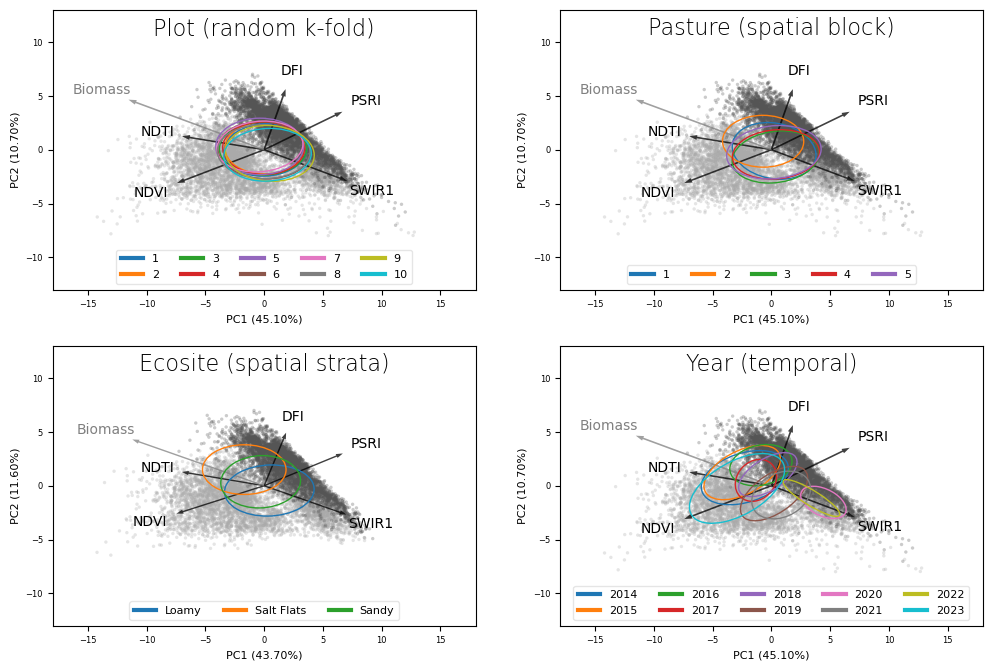

In [31]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names[idx],
             n_std=1.0,
             pcs=[1,2])
    leg = axs.flatten()[idx].get_legend()
    #if idx > 1:
    leg.set_loc('lower center')
    #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
    axs.flatten()[idx].legend(leg.legend_handles,
                              [x.get_text() for x in leg.get_texts()], 
                              ncol=5, loc='lower center',
                              frameon=True, framealpha=0.5, 
                              fontsize=8)
    #else:
    #    leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.88)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-13, 13))

In [32]:
names2 = ['Plot (random k-fold)', 'Pasture (spatial block)', 'Ecosite (spatial strata)', 'Year (temporal)', 'Kmeans (clustered)']
df_kmeans['kfold'] = (df_kmeans['kfold'].astype(int)+1).astype('str')

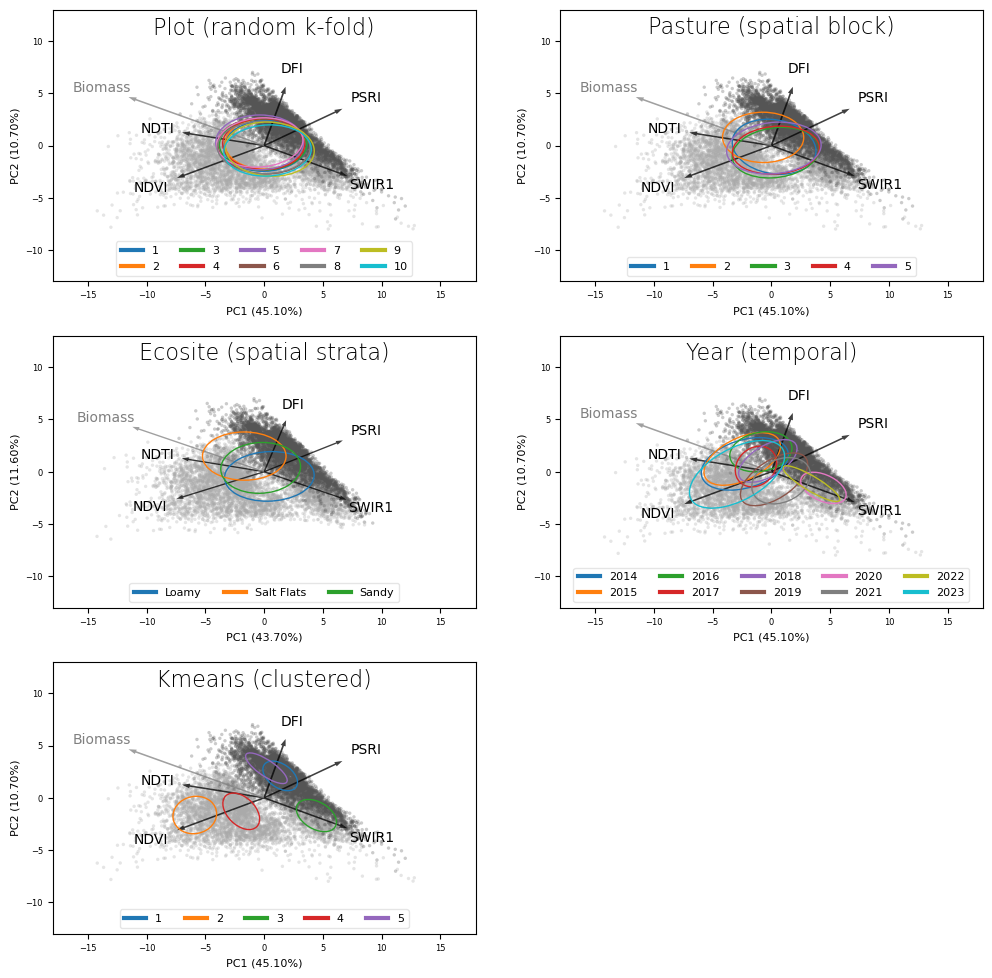

In [165]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year, df_kmeans]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names2[idx],
             n_std=1.0,
             pcs=[1,2])
    leg = axs.flatten()[idx].get_legend()
    #if idx > 1:
    leg.set_loc('lower center')
    #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
    axs.flatten()[idx].legend(leg.legend_handles,
                              [x.get_text() for x in leg.get_texts()], 
                              ncol=5, loc='lower center',
                              frameon=True, framealpha=0.5, 
                              fontsize=8)
    #else:
    #    leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.88)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-13, 13))
axs.flatten()[-1].remove()
plt.savefig('./results/figures/Fig3_PCA_plots.png', dpi=300, bbox_inches='tight')

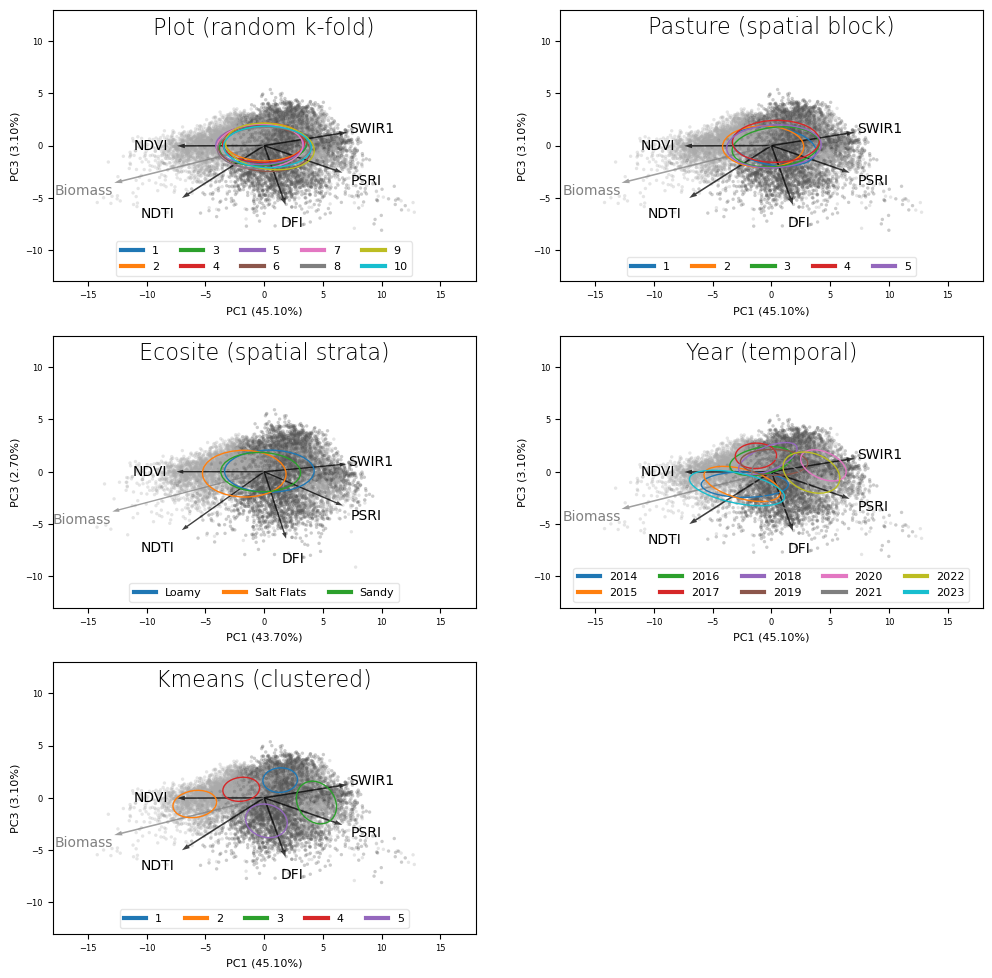

In [173]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for idx, df in enumerate([df_plot, df_spatial, df_ecosite, df_year, df_kmeans]):
    df['sqrt_Biomass_kg_ha'] = np.sqrt(df['Biomass_kg_ha']) 
    plot_pcs(df=df,
             ax=axs.flatten()[idx],
             var_names=var_names,
             pc_type = 'pls',
             var_reduce_type = 'manual',
             k=None,
             vars_of_interest = ['NDVI', 'DFI', 'NDTI', 'SWIR1', 'PSRI'],
             #vars_of_interest = ['SWIR2', 'NDTI', 'TCWI', 'SWIR1', 'BLUE', 'TCBI', 'GREEN', 'DFI', 'RED'],
             title=names2[idx],
             n_std=1.0,
             pcs=[1,3])
    leg = axs.flatten()[idx].get_legend()
    #if idx > 1:
    leg.set_loc('lower center')
    #handles, labels = axs.flatten()[idx].get_legend_handles_labels()
    axs.flatten()[idx].legend(leg.legend_handles,
                              [x.get_text() for x in leg.get_texts()], 
                              ncol=5, loc='lower center',
                              frameon=True, framealpha=0.5, 
                              fontsize=8)
    #else:
    #    leg.set_visible(False)
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16, y=0.88)
    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel(ax.get_ylabel(), fontsize=8)
    ax.set_xlim((-18, 18))
    ax.set_ylim((-13, 13))
axs.flatten()[-1].remove()
plt.savefig('./results/figures/FigS1_PCA_plot_3v1.png', dpi=300, bbox_inches='tight')

## Bootstrap by year

In [37]:
yr_type_dict = {
    2014: 'Wet',
    2015: 'Wet',
    2016: 'Average',
    2017: 'Average',
    2018: 'Average',
    2019: 'Average',
    2020: 'Dry',
    2021: 'Average',
    2022: 'Dry',
    2023: 'Wet'
}

drought_yrs = ['2020', '2022']
wet_yrs = ['2014', '2015', '2023']

In [38]:
df_boots_yr_transect = pd.read_csv('./results/tmp/vor_bootstrap_by_year_transect_v2.csv')
df_boots_nyrs = pd.read_csv('./results/tmp/vor_bootstrap_pred_9yrs_transect.csv')
df_boots_yr_transect = df_boots_yr_transect[df_boots_yr_transect['Model'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR'])].copy()
df_boots_yr_transect['Source_type'] = df_boots_yr_transect['Model'].apply(lambda x: mod_name_dict[x])
yr_n = 10
df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] == yr_n - 1].groupby('Model').count()['numb_yrs']/yr_n

Model
HGBR     1.0
LASSO    1.0
OLS      1.0
PCR      1.0
PLS      1.0
RF       1.0
SVR      1.0
Name: numb_yrs, dtype: float64

In [39]:
df_boots_yr_transect.loc[df_boots_yr_transect['R2_xfrm_plot'] < 0, 'R2_xfrm_plot'] = 0.0
df_boots_yr_transect['numb_yrs'] = df_boots_yr_transect['numb_yrs'].astype(str)
df_boots_yr_transect['MAE_pct_plot'] = df_boots_yr_transect['MAE_pct_plot'] * 100.0
df_boots_yr_transect['yr_type'] = df_boots_yr_transect['yr_test'].apply(lambda x: yr_type_dict[x])
df_boots_yr_transect['yr_test'] = df_boots_yr_transect['yr_test'].astype(str)

In [40]:
test = df_boots_yr_transect.value_counts(['numb_yrs', 'Model'], sort=False)
#test

In [41]:
df_boots_yr_transect.dtypes

Model                object
numb_yrs             object
yr_train             object
yr_test              object
retune_bootstrap       bool
MAE                 float64
MAPE                float64
MAE_pct             float64
R2                  float64
r_coef              float64
R2_xfrm             float64
r_coef_xfrm         float64
MAE_plot            float64
MAPE_plot           float64
MAE_pct_plot        float64
R2_plot             float64
r_coef_plot         float64
R2_xfrm_plot        float64
r_coef_xfrm_plot    float64
Source_type          object
yr_type              object
dtype: object

In [42]:
sub_models = ['OLS', 'LASSO', 'PLS', 'SVR', 'RF']
df_boots_yr_transect = df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)].copy()
df_boots_yr_transect['Model'] = pd.Categorical(df_boots_yr_transect['Model'], sub_models)

In [43]:
t_year_yrly = pd.read_csv(
    './results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Year_tuneby_Year_results_plot_yrly.csv')

t_year_yrly = t_year_yrly.drop(columns=['MAE', 'Bias']).rename(
    columns={'Source': 'Model',
             'kfold': 'yr_test',
             'MAE_bt': 'MAE_plot',
             'MAE_pct': 'MAE_pct_plot',
             'R^2': 'R2_plot',
             'r': 'r_coef_plot'})

t_year_yrly = t_year_yrly[t_year_yrly['Model'].isin(sub_models)]
t_year_yrly['yr_test'] = t_year_yrly['yr_test'].astype(int)
t_year_yrly['numb_yrs'] = 10

In [44]:
t_year_yrly.columns

Index(['Model', 'yr_test', 'MAE_plot', 'MAE_pct_plot', 'R2_plot',
       'r_coef_plot', 'numb_yrs'],
      dtype='object')

In [45]:
#df_boots_yr_transect = pd.concat([df_boots_yr_transect, t_year_yrly])

In [46]:
df_boots_drought = df_boots_yr_transect[df_boots_yr_transect['yr_test'].isin(drought_yrs)]
#df_boots_drought_notrain = df_boots_drought[~df_boots_drought['yr_train'].apply(lambda x: any([str(i) in x for i in drought_yrs]))]
df_boots_wet = df_boots_yr_transect[df_boots_yr_transect['yr_test'].isin(wet_yrs)]
#df_boots_wet_notrain = df_boots_wet[~df_boots_wet['yr_train'].apply(lambda x: any([str(i) in x for i in wet_yrs]))]
df_boots_avg = df_boots_yr_transect[~df_boots_yr_transect['yr_test'].isin(drought_yrs + wet_yrs)]

In [47]:
from matplotlib.ticker import MultipleLocator

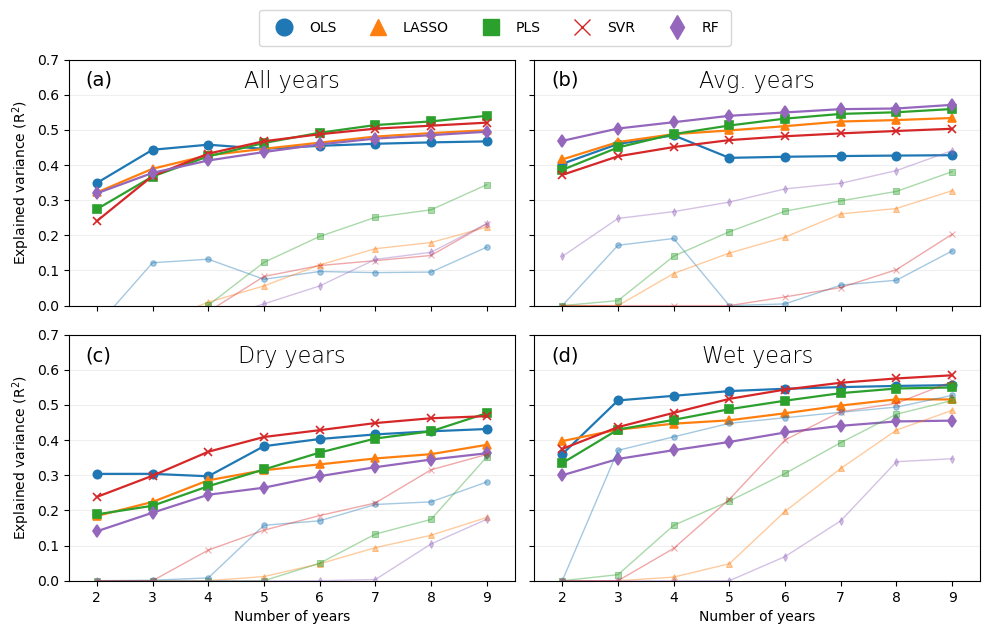

In [168]:
marker_list = ["o", "^", "s", "x", "d"]

p_kwargs = dict(
    estimator='mean',
    errorbar=None,
    markers=marker_list,
    linewidth=1.6, 
    markersize=6,
    dodge=0.0,
    legend=False
)

p_kwargs2 = dict(
    estimator=lambda x: np.percentile(x, 5),
    errorbar=None,
    markers=marker_list,
    linewidth=1.0, 
    linestyle='solid',
    markersize=4,
    alpha=0.4,
    dodge=0.0,
    legend=False
)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=True, sharex=True)
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,0], 
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,1],
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,1],
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,0], 
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='R2_xfrm_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,1], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,1], 
              **p_kwargs2
             )

axs[0,0].set_title('All years', y=0.85)
axs[0,1].set_title('Avg. years', y=0.85)
axs[1,0].set_title('Dry years', y=0.85)
axs[1,1].set_title('Wet years', y=0.85)

axs[0,0].set_ylabel('Explained variance (R$^2$)')
axs[1,0].set_ylabel('Explained variance (R$^2$)')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
for idx, ax in enumerate(axs.flatten()):
    ax.title.set(fontweight=10, fontsize=16)
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.grid(alpha=0.2)
    ax.set_ylim((0.0, 0.7))
    ax.annotate(['(a)', '(b)', '(c)', '(d)'][idx], (-0.2, 0.625), fontsize=14)
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=sub_models[m_idx],
                                  mfc=sns.color_palette("tab10")[m_idx],
                                  mec=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.tight_layout()
plt.savefig('./results/figures/Fig5_nyears_by_condition.png', dpi=300, bbox_inches='tight')

In [50]:
df_boots_wet.groupby('numb_yrs')['yr_train'].count()

numb_yrs
2     540
3    1260
4    1890
5    1890
6    1260
7     540
8     135
9      15
Name: yr_train, dtype: int64

In [51]:
#np.repeat(df_boots_wet_lwr['numb_yrs'].unique(), len(range(2014, 2024)))
#np.repeat(df_boots_wet_lwr['Model'].unique(), len(range(2014, 2024)) * len(df_boots_wet_lwr['numb_yrs'].unique()))
#len(list(np.repeat(df_boots_wet_lwr['numb_yrs'].unique(), len(range(2014, 2024)))) * len(df_boots_wet_lwr['Model'].unique()))
#len(list(range(2014, 2024)) * len(df_boots_wet_lwr['Model'].unique()) * len(df_boots_wet_lwr['numb_yrs'].unique()))
#len(mods_list)

In [52]:
df_boots_wet['Model'].value_counts()

Model
OLS      1506
LASSO    1506
PLS      1506
SVR      1506
RF       1506
Name: count, dtype: int64

In [53]:
df_boots_avg['Model']

17         OLS
18       LASSO
19         PLS
21         SVR
22          RF
         ...  
40137      OLS
40138    LASSO
40139      PLS
40141      SVR
40142       RF
Name: Model, Length: 12550, dtype: category
Categories (5, object): ['OLS', 'LASSO', 'PLS', 'SVR', 'RF']

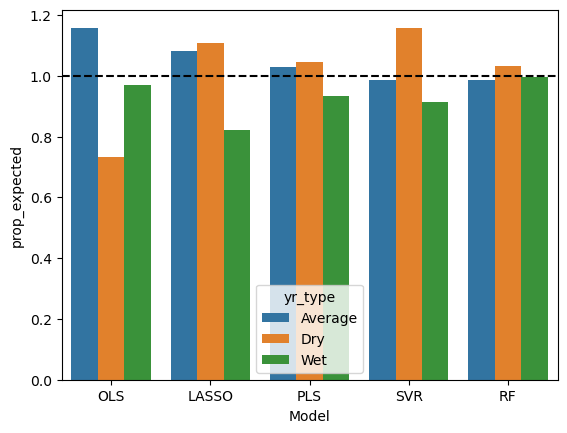

In [54]:
avg_lwr_mask = df_boots_avg['R2_xfrm_plot'] <= df_boots_avg.groupby(['Model', 'numb_yrs'], observed=False)['R2_xfrm_plot'].transform(
    lambda x: np.percentile(x, 5))
df_boots_avg_lwr = df_boots_avg[avg_lwr_mask].copy()
avg_lwr_result = []
mods_list = []
n_list = []
yr_list = []
total_possible_list = []
expected_list = []
for mod in df_boots_avg_lwr['Model'].unique():
    for n, grp in df_boots_avg_lwr[df_boots_avg_lwr['Model'] == mod].groupby('numb_yrs'):
        for yr in range(2014, 2024):
            avg_lwr_result.append(grp['yr_train'].apply(lambda x: str(yr) in x).sum())
            mods_list.append(mod)
            n_list.append(n)
            yr_list.append(yr)
            total_possible = len(
                df_boots_avg[(df_boots_avg['Model'] == mod) &
                (df_boots_avg['numb_yrs'] == n) & 
                df_boots_avg['yr_train'].str.contains(str(yr))])
            total_possible_list.append(total_possible)
            expected_list.append(total_possible * (len(grp) / len(df_boots_avg[(df_boots_avg['Model'] == mod) &
                                                       (df_boots_avg['numb_yrs'] == n)])))
df_avg_lwr_result = pd.DataFrame({
    'Model': pd.Categorical(mods_list, sub_models),
    'numb_yrs': n_list,
    'yr': yr_list,
    'count': avg_lwr_result,
    'total_possible': total_possible_list,
    'expected': expected_list
})
df_avg_lwr_result['numb_yrs'] = df_avg_lwr_result['numb_yrs'].astype(str)
df_avg_lwr_result['yr'] = df_avg_lwr_result['yr'].astype(str)
df_avg_lwr_result['yr_type'] = df_avg_lwr_result['yr'].apply(lambda x: yr_type_dict[int(x)])
df_avg_lwr_result_sum = df_avg_lwr_result.groupby(['Model', 'yr', 'yr_type'], observed=False).sum().reset_index()

df_avg_lwr_result_sum['proportion'] = df_avg_lwr_result_sum['count'] / df_avg_lwr_result_sum['total_possible']
df_avg_lwr_result_sum['prop_expected'] = df_avg_lwr_result_sum['count'] / df_avg_lwr_result_sum['expected']



#sns.catplot(data=df_avg_lwr_result.groupby(['Model', 'yr']).sum().reset_index(), kind='bar',
#            x='yr', y='count', estimator='mean', errorbar='sd', col='Model', col_wrap=3)

#sns.catplot(data=df_avg_lwr_result.groupby(['Model', 'yr', 'yr_type']).sum().reset_index(), kind='bar',
#            x='yr_type', y='count', estimator='sum', errorbar='sd', col='Model', col_wrap=3)

p = sns.barplot(data=df_avg_lwr_result_sum,
            x='Model', y='prop_expected', hue='yr_type', estimator='mean', errorbar=None)
p.axhline(y=1.0, linestyle='dashed', color='black')

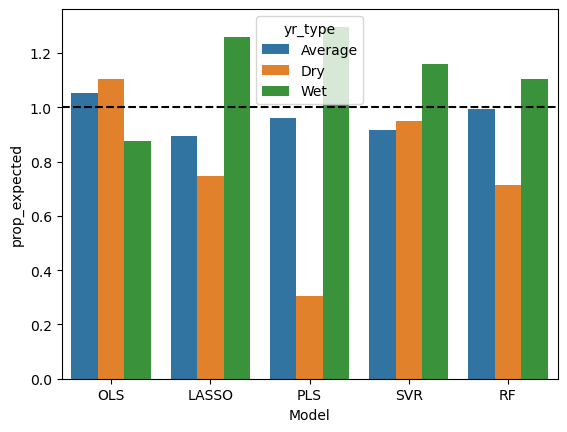

In [55]:
drought_lwr_mask = df_boots_drought['R2_xfrm_plot'] <= df_boots_drought.groupby(['Model', 'numb_yrs'], observed=False)['R2_xfrm_plot'].transform(
    lambda x: np.percentile(x, 5))
df_boots_drought_lwr = df_boots_drought[drought_lwr_mask].copy()
drought_lwr_result = []
mods_list = []
n_list = []
yr_list = []
total_possible_list = []
expected_list = []
for mod in df_boots_drought_lwr['Model'].unique():
    for n, grp in df_boots_drought_lwr[df_boots_drought_lwr['Model'] == mod].groupby('numb_yrs'):
        for yr in range(2014, 2024):
            drought_lwr_result.append(grp['yr_train'].apply(lambda x: str(yr) in x).sum())
            mods_list.append(mod)
            n_list.append(n)
            yr_list.append(yr)
            total_possible = len(
                df_boots_drought[(df_boots_drought['Model'] == mod) &
                (df_boots_drought['numb_yrs'] == n) & 
                df_boots_drought['yr_train'].str.contains(str(yr))])
            total_possible_list.append(total_possible)
            expected_list.append(total_possible * (len(grp) / len(df_boots_drought[(df_boots_drought['Model'] == mod) &
                                                       (df_boots_drought['numb_yrs'] == n)])))
df_drought_lwr_result = pd.DataFrame({
    'Model': pd.Categorical(mods_list, sub_models),
    'numb_yrs': n_list,
    'yr': yr_list,
    'count': drought_lwr_result,
    'total_possible': total_possible_list,
    'expected': expected_list
})
df_drought_lwr_result['numb_yrs'] = df_drought_lwr_result['numb_yrs'].astype(str)
df_drought_lwr_result['yr'] = df_drought_lwr_result['yr'].astype(str)
df_drought_lwr_result['yr_type'] = df_drought_lwr_result['yr'].apply(lambda x: yr_type_dict[int(x)])
df_drought_lwr_result_sum = df_drought_lwr_result.groupby(['Model', 'yr', 'yr_type'], observed=False).sum().reset_index()

df_drought_lwr_result_sum['proportion'] = df_drought_lwr_result_sum['count'] / df_drought_lwr_result_sum['total_possible']
df_drought_lwr_result_sum['prop_expected'] = df_drought_lwr_result_sum['count'] / df_drought_lwr_result_sum['expected']


#sns.catplot(data=df_drought_lwr_result.groupby(['Model', 'yr']).sum().reset_index(), kind='bar',
#            x='yr', y='count', estimator='mean', errorbar='sd', col='Model', col_wrap=3)

#sns.catplot(data=df_drought_lwr_result.groupby(['Model', 'yr', 'yr_type']).sum().reset_index(), kind='bar',
#            x='yr_type', y='count', estimator='sum', errorbar='sd', col='Model', col_wrap=3)

p = sns.barplot(data=df_drought_lwr_result_sum,
            x='Model', y='prop_expected', hue='yr_type', estimator='mean', errorbar=None)
p.axhline(y=1.0, linestyle='dashed', color='black')

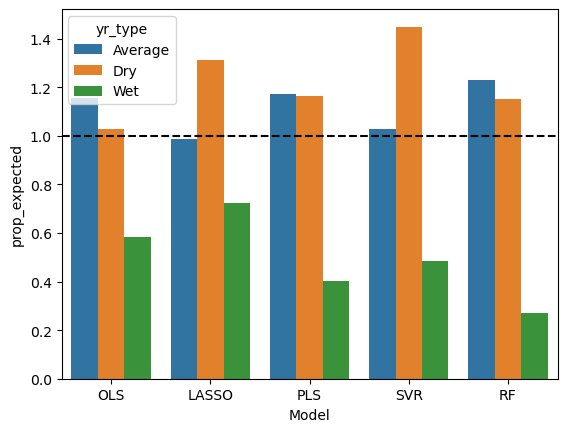

In [56]:
wet_lwr_mask = df_boots_wet['R2_xfrm_plot'] <= df_boots_wet.groupby(['Model', 'numb_yrs'], observed=False)['R2_xfrm_plot'].transform(
    lambda x: np.percentile(x, 5))
df_boots_wet_lwr = df_boots_wet[wet_lwr_mask].copy()
wet_lwr_result = []
mods_list = []
n_list = []
yr_list = []
total_possible_list = []
expected_list = []
for mod in df_boots_wet_lwr['Model'].unique():
    for n, grp in df_boots_wet_lwr[df_boots_wet_lwr['Model'] == mod].groupby('numb_yrs'):
        for yr in range(2014, 2024):
            wet_lwr_result.append(grp['yr_train'].apply(lambda x: str(yr) in x).sum())
            mods_list.append(mod)
            n_list.append(n)
            yr_list.append(yr)
            total_possible = len(
                df_boots_wet[(df_boots_wet['Model'] == mod) &
                (df_boots_wet['numb_yrs'] == n) & 
                df_boots_wet['yr_train'].str.contains(str(yr))])
            total_possible_list.append(total_possible)
            expected_list.append(total_possible * (len(grp) / len(df_boots_wet[(df_boots_wet['Model'] == mod) &
                                                       (df_boots_wet['numb_yrs'] == n)])))
df_wet_lwr_result = pd.DataFrame({
    'Model': pd.Categorical(mods_list, sub_models),
    'numb_yrs': n_list,
    'yr': yr_list,
    'count': wet_lwr_result,
    'total_possible': total_possible_list,
    'expected': expected_list
})
df_wet_lwr_result['numb_yrs'] = df_wet_lwr_result['numb_yrs'].astype(str)
df_wet_lwr_result['yr'] = df_wet_lwr_result['yr'].astype(str)
df_wet_lwr_result['yr_type'] = df_wet_lwr_result['yr'].apply(lambda x: yr_type_dict[int(x)])
df_wet_lwr_result_sum = df_wet_lwr_result.groupby(['Model', 'yr', 'yr_type'], observed=False).sum().reset_index()

df_wet_lwr_result_sum['proportion'] = df_wet_lwr_result_sum['count'] / df_wet_lwr_result_sum['total_possible']
df_wet_lwr_result_sum['prop_expected'] = df_wet_lwr_result_sum['count'] / df_wet_lwr_result_sum['expected']


#sns.catplot(data=df_wet_lwr_result.groupby(['Model', 'yr']).sum().reset_index(), kind='bar',
#            x='yr', y='count', estimator='mean', errorbar='sd', col='Model', col_wrap=3)

#sns.catplot(data=df_wet_lwr_result.groupby(['Model', 'yr', 'yr_type']).sum().reset_index(), kind='bar',
#            x='yr_type', y='count', estimator='sum', errorbar='sd', col='Model', col_wrap=3)

p = sns.barplot(data=df_wet_lwr_result_sum,
            x='Model', y='prop_expected', hue='yr_type', estimator='mean', errorbar=None)
p.axhline(y=1.0, linestyle='dashed', color='black')

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


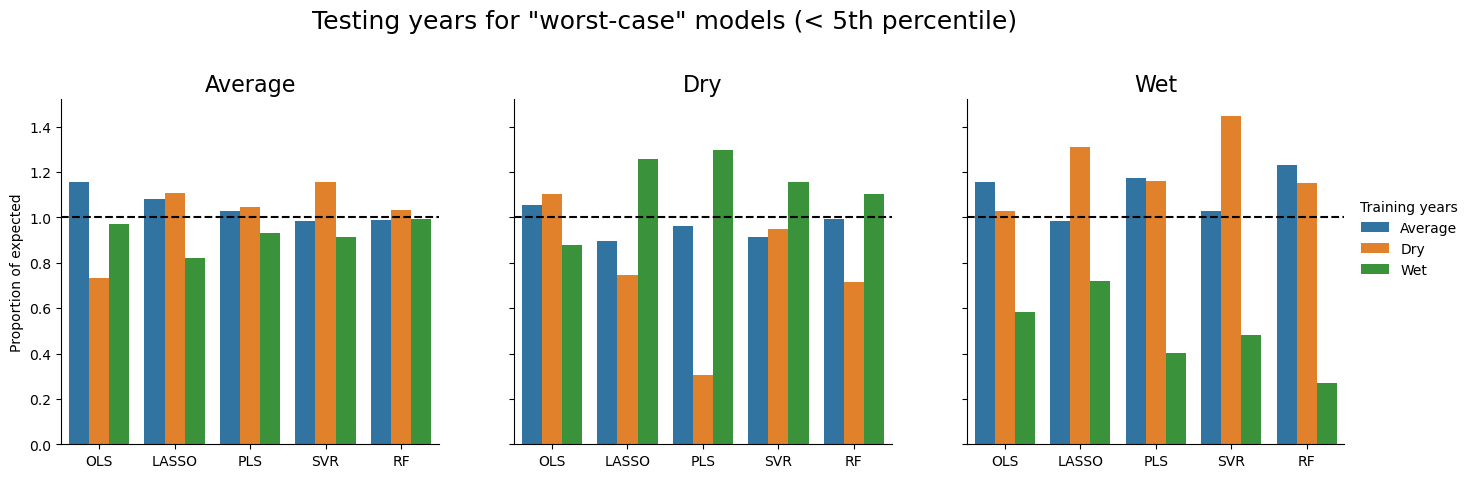

In [172]:
df_avg_lwr_result_sum['test_type'] = 'Average'
df_drought_lwr_result_sum['test_type'] = 'Dry'
df_wet_lwr_result_sum['test_type'] = 'Wet'

df_lwr_result_sum = pd.concat([df_avg_lwr_result_sum, df_drought_lwr_result_sum, df_wet_lwr_result_sum], ignore_index=True)
p = sns.catplot(data=df_lwr_result_sum, kind='bar',
                x='Model', y='prop_expected', hue='yr_type', 
                col='test_type', estimator='mean', errorbar=None,
                facet_kws={'gridspec_kws': {'wspace':0.2}}
               )
p.set_titles("{col_name}")
p.set_ylabels("Proportion of expected")
p.set_xlabels("")
p._legend.set_title("Training years")
#p.set_title("Testing years")
for ax in p.axes.flatten():
    ax.axhline(y=1.0, linestyle='dashed', color='black')
    ax.set_title(ax.get_title(), fontsize=16)

p.fig.subplots_adjust(top=0.8) # adjust the Figure in rp
p.fig.suptitle('Testing years for "worst-case" models (< 5th percentile)', fontsize=18)
plt.savefig('./results/figures/FigS2_worst_case_test_yrs.png', dpi=300, bbox_inches='tight')
#p.fig.tight_layout()

In [59]:
df_wet_lwr_result_sum

Model    yr  yr_type  numb_yrs  count  total_possible   expected  \
0     OLS  2014  Average         0      0               0   0.000000   
1     OLS  2014      Dry         0      0               0   0.000000   
2     OLS  2014      Wet  23456789     42             510  27.925926   
3     OLS  2015  Average         0      0               0   0.000000   
4     OLS  2015      Dry         0      0               0   0.000000   
..    ...   ...      ...       ...    ...             ...        ...   
145    RF  2022      Dry  23456789     60             765  55.555556   
146    RF  2022      Wet         0      0               0   0.000000   
147    RF  2023  Average         0      0               0   0.000000   
148    RF  2023      Dry         0      0               0   0.000000   
149    RF  2023      Wet  23456789      0             510  37.037037   

     proportion  prop_expected test_type  
0           NaN            NaN       Wet  
1           NaN            NaN       Wet  
2      0.082353       1.503979       Wet  
3           NaN            NaN       Wet  
4           NaN            NaN       Wet  
..          ...            ...       ...  
145    0.078431       1.080000       Wet  
146         NaN            NaN       Wet  
147         NaN            NaN       Wet  
148         NaN            NaN       Wet  
149    0.000000       0.000000       Wet  

[150 rows x 10 columns]

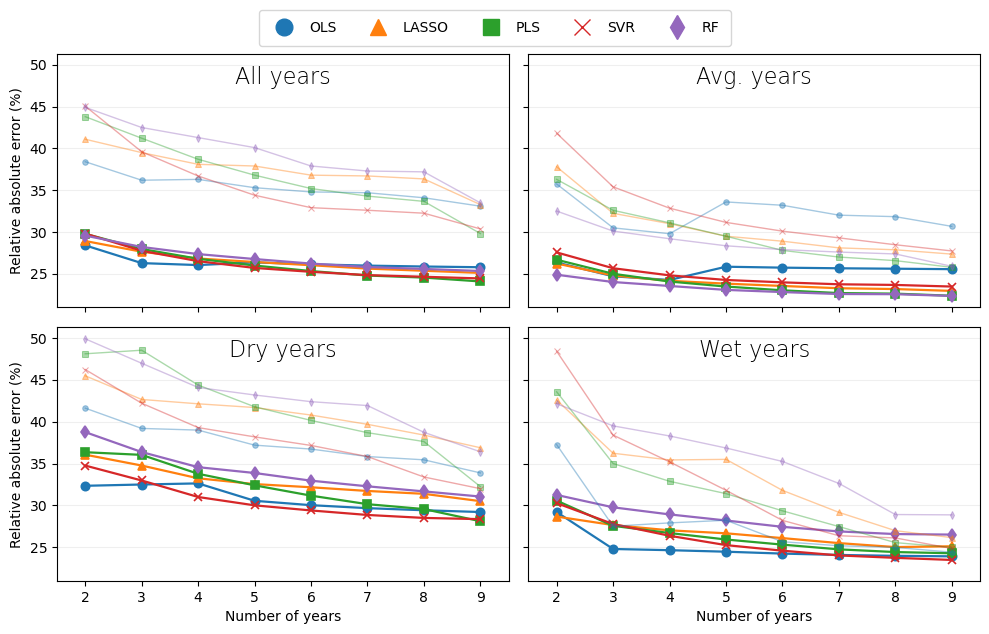

In [60]:
marker_list = ["o", "^", "s", "x", "d"]

p_kwargs = dict(
    estimator='mean',
    errorbar=None,
    markers=marker_list,
    linewidth=1.6, 
    markersize=6,
    dodge=0.0,
    legend=False
)

p_kwargs2 = dict(
    estimator=lambda x: np.percentile(x, 95),
    errorbar=None,
    markers=marker_list,
    linewidth=1.0, 
    linestyle='solid',
    markersize=4,
    alpha=0.4,
    dodge=0.0,
    legend=False
)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=True, sharex=True)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,0], 
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,1],
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,1],
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,0], 
              **p_kwargs2
             )

sns.pointplot(x='numb_yrs', y='MAE_pct_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,1], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='MAE_pct_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,1], 
              **p_kwargs2
             )

axs[0,0].set_title('All years', y=0.85)
axs[0,1].set_title('Avg. years', y=0.85)
axs[1,0].set_title('Dry years', y=0.85)
axs[1,1].set_title('Wet years', y=0.85)

axs[0,0].set_ylabel('Relative absolute error (%)')
axs[1,0].set_ylabel('Relative absolute error (%)')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16)
    #ax.yaxis.set_major_locator(MultipleLocator(0.1))
    ax.yaxis.grid(alpha=0.2)
    #ax.set_ylim((0.0, 0.7))
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=sub_models[m_idx],
                                  mfc=sns.color_palette("tab10")[m_idx],
                                  mec=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.tight_layout()

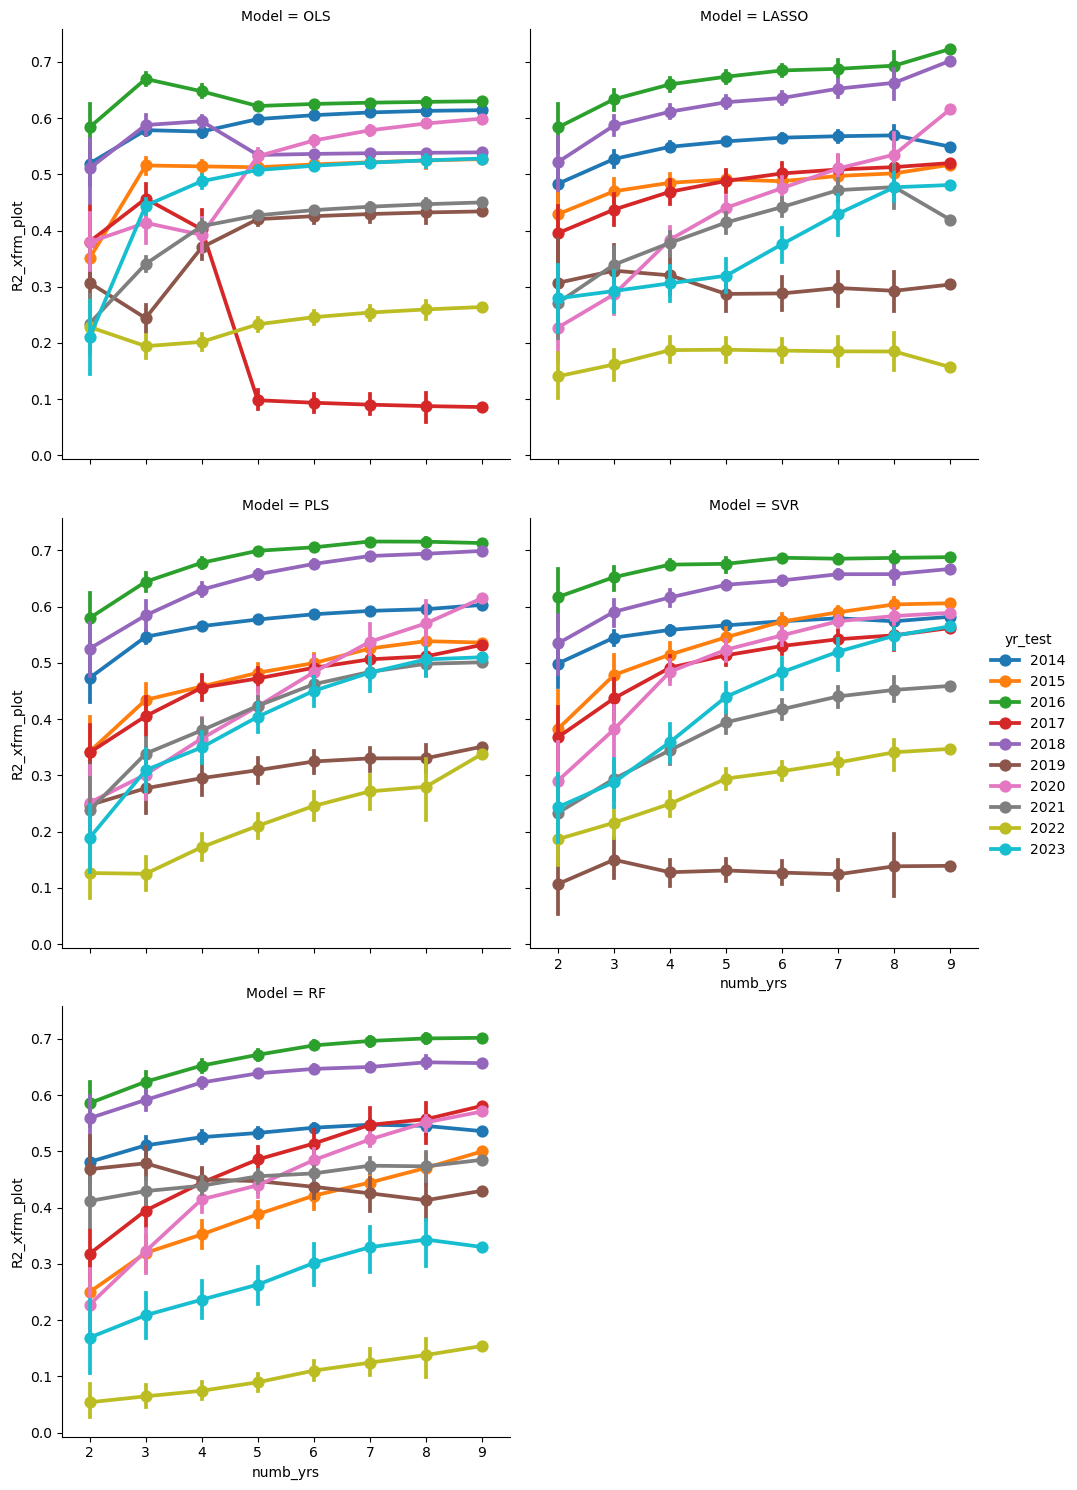

In [61]:
#fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=True, sharex=True)
sns.catplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='yr_test',
            col='Model', col_wrap=2, kind='point'
             )

In [62]:
df_boots_yr_transect.columns

Index(['Model', 'numb_yrs', 'yr_train', 'yr_test', 'retune_bootstrap', 'MAE',
       'MAPE', 'MAE_pct', 'R2', 'r_coef', 'R2_xfrm', 'r_coef_xfrm', 'MAE_plot',
       'MAPE_plot', 'MAE_pct_plot', 'R2_plot', 'r_coef_plot', 'R2_xfrm_plot',
       'r_coef_xfrm_plot', 'Source_type', 'yr_type'],
      dtype='object')

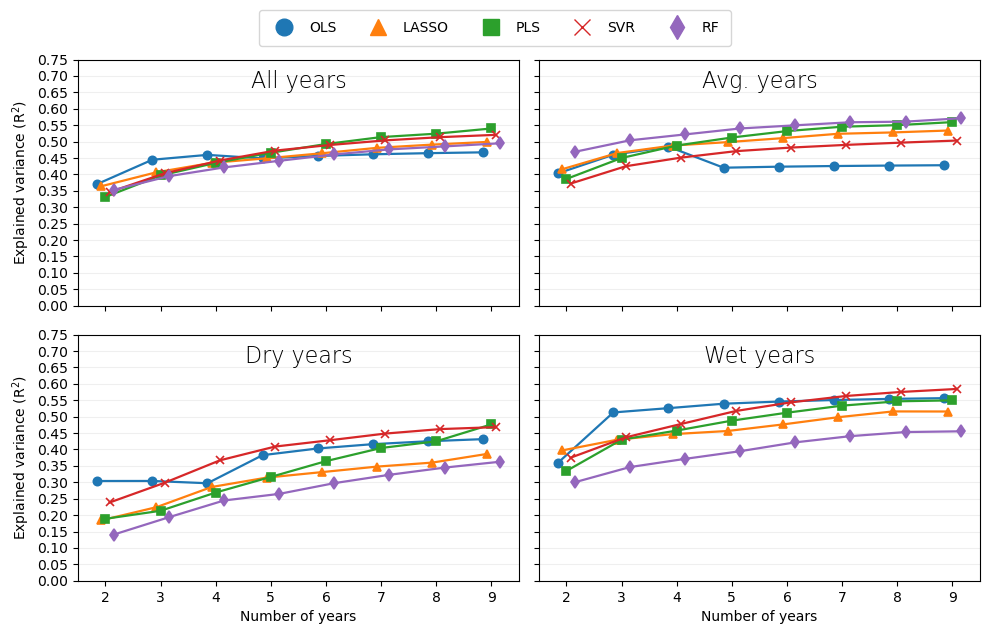

In [63]:
marker_list = ["o", "^", "s", "x", "d"]

p_kwargs = dict(
    estimator='mean',
    errorbar=None,
    markers=marker_list,
    linewidth=1.6, 
    markersize=6,
    dodge=0.3,
    legend=False
)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=True, sharex=True)
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[0,1],
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,0], 
              **p_kwargs
             )
sns.pointplot(x='numb_yrs', y='R2_xfrm_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              ax=axs[1,1], 
              **p_kwargs
             )

axs[0,0].set_title('All years', y=0.85)
axs[0,1].set_title('Avg. years', y=0.85)
axs[1,0].set_title('Dry years', y=0.85)
axs[1,1].set_title('Wet years', y=0.85)

axs[0,0].set_ylabel('Explained variance (R$^2$)')
axs[1,0].set_ylabel('Explained variance (R$^2$)')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16)
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.grid(alpha=0.2)
    ax.set_ylim((0.0, 0.75))
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=sub_models[m_idx],
                                  mfc=sns.color_palette("tab10")[m_idx],
                                  mec=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.tight_layout()

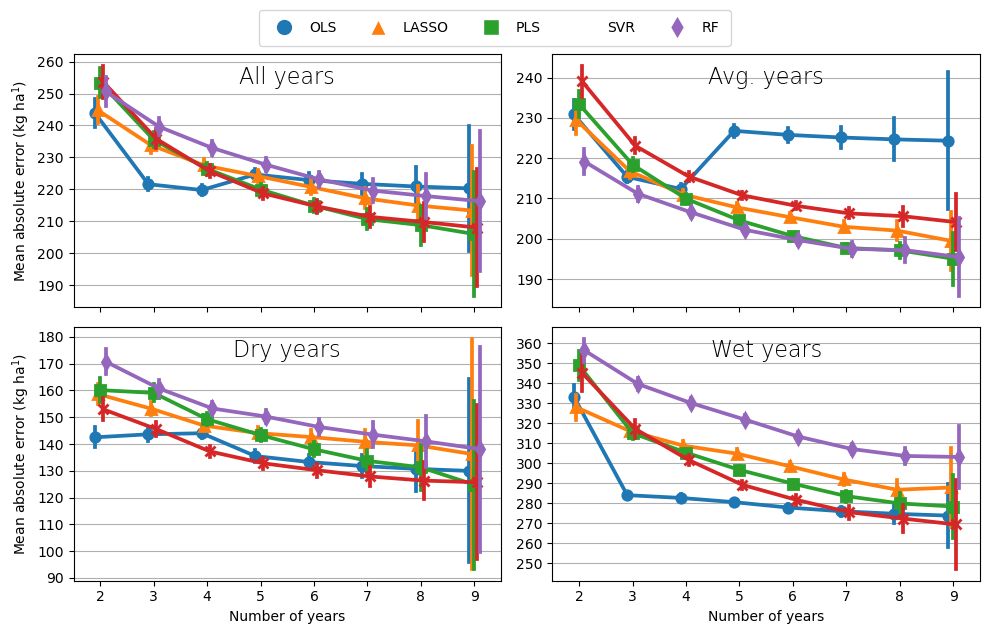

In [65]:
#marker_list = ["o", "^", "s", "D"]
marker_list = ["o", "^", "s", "x", "d"]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=False, sharex=True)
sns.pointplot(x='numb_yrs', y='MAE_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[0,0], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[0,1], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[1,0], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[1,1], legend=False, markers=marker_list, dodge=0.2)

axs[0,0].set_title('All years', y=0.85)
axs[0,1].set_title('Avg. years', y=0.85)
axs[1,0].set_title('Dry years', y=0.85)
axs[1,1].set_title('Wet years', y=0.85)

axs[0,0].set_ylabel('Mean absolute error (kg ha$^1$)')
axs[1,0].set_ylabel('Mean absolute error (kg ha$^1$)')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.grid()
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=sub_models[m_idx],
                                  markerfacecolor=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.tight_layout()

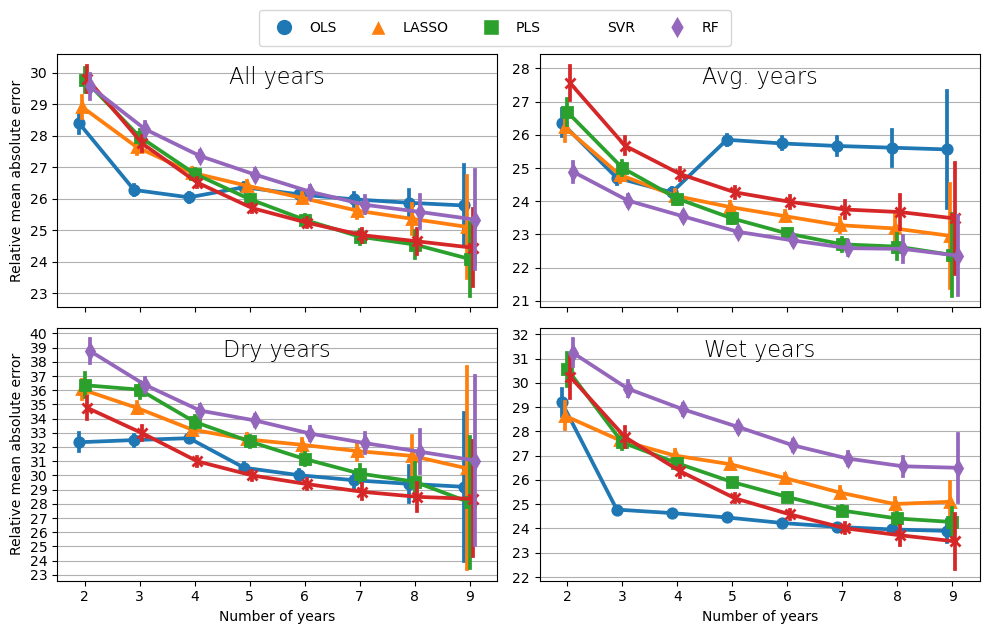

In [68]:
#marker_list = ["o", "^", "s", "D"]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharey=False, sharex=True)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[0,0], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_avg[df_boots_avg['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[0,1], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_drought[df_boots_drought['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[1,0], legend=False, markers=marker_list, dodge=0.2)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot', 
              data=df_boots_wet[df_boots_wet['Model'].isin(sub_models)],
              hue='Model', 
              errorbar=('se', 1),
              ax=axs[1,1], legend=False, markers=marker_list, dodge=0.2)

axs[0,0].set_title('All years', y=0.85)
axs[0,1].set_title('Avg. years', y=0.85)
axs[1,0].set_title('Dry years', y=0.85)
axs[1,1].set_title('Wet years', y=0.85)

axs[0,0].set_ylabel('Relative mean absolute error')
axs[1,0].set_ylabel('Relative mean absolute error')
axs[0,1].set_ylabel('')
axs[1,1].set_ylabel('')
for ax in axs.flatten():
    ax.title.set(fontweight=10, fontsize=16)
    ax.yaxis.set_major_locator(MultipleLocator(1.0))
    ax.yaxis.grid()
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=sub_models[m_idx],
                                  markerfacecolor=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
fig.tight_layout()

In [69]:
#DISCREPENCY BETWEEN 9 AND 10 YEARS IS BECAUSE '10' YEARS (FROM ORIGINAL TRAINING) IS BASED ON THE TRANSFORMED DATA...DON'T HAVE THIS YET FOR BOOTSTRAPPED.

In [72]:
df_boots_yr_transect['numb_yrs'] = df_boots_yr_transect['numb_yrs'].astype(int)

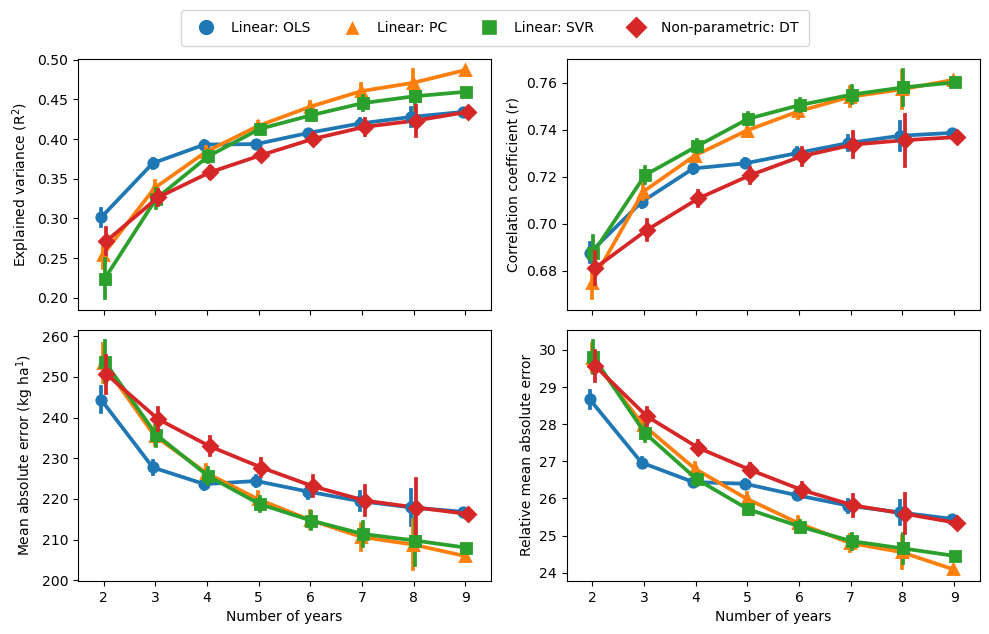

In [74]:
marker_list = ["o", "^", "s", "D"]

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,6), sharex=True)
sns.pointplot(x='numb_yrs', y='R2_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] < 9],
              hue='Source_type', 
              errorbar=('se', 1),
              ax=axs[0,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='R2_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] >= 8],
              hue='Source_type', 
              errorbar=None,
              ax=axs[0,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='r_coef_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] < 9],
              hue='Source_type', 
              errorbar=('se', 1),
              ax=axs[0,1], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='r_coef_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] >= 8],
              hue='Source_type', 
              errorbar=None,
              ax=axs[0,1], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='MAE_plot', 
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] < 9],
              hue='Source_type', 
              errorbar=('se', 1),
              ax=axs[1,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='MAE_plot', 
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] >= 8],
              hue='Source_type', 
              errorbar=None,
              ax=axs[1,0], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] < 9],
              hue='Source_type', 
              errorbar=('se', 1),
              ax=axs[1,1], legend=False, markers=marker_list, dodge=True)
sns.pointplot(x='numb_yrs', y='MAE_pct_plot',
              data=df_boots_yr_transect[df_boots_yr_transect['numb_yrs'] >= 8],
              hue='Source_type', 
              errorbar=None,
              ax=axs[1,1], legend=False, markers=marker_list, dodge=True)
axs[0,0].set_ylabel('Explained variance (R$^2$)')
axs[0,1].set_ylabel('Correlation coefficient (r)')
axs[1,0].set_ylabel('Mean absolute error (kg ha$^1$)')
axs[1,1].set_ylabel('Relative mean absolute error')
for ax in axs[1,:].flatten():
    ax.set_xlabel('Number of years')
legend_elements = []
for m_idx, m in enumerate(marker_list):
    legend_elements.append(Line2D([0], [0], marker=m, color='w', 
                                  label=t_all['Source_type'].unique()[m_idx],
                                  markerfacecolor=sns.color_palette("tab10")[m_idx],
                                  markersize=12))
fig.legend(handles=legend_elements,
           loc='upper center', ncols=len(marker_list),
           bbox_to_anchor=(0.5, 1.06), borderpad=0.8)
plt.tight_layout()

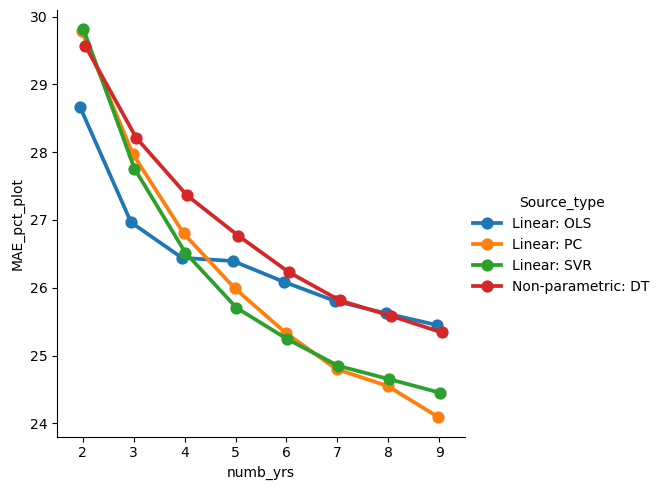

In [75]:
g = sns.catplot(kind='point', x='numb_yrs', y='MAE_pct_plot', hue='Source_type',
                dodge=True, #estimator=lambda x: np.percentile(x, 90),#showfliers=False, #cut=0, inner=None,
                errorbar=None,
                data=df_boots_yr_transect)
#g.set(ylim=(0, 0.6))

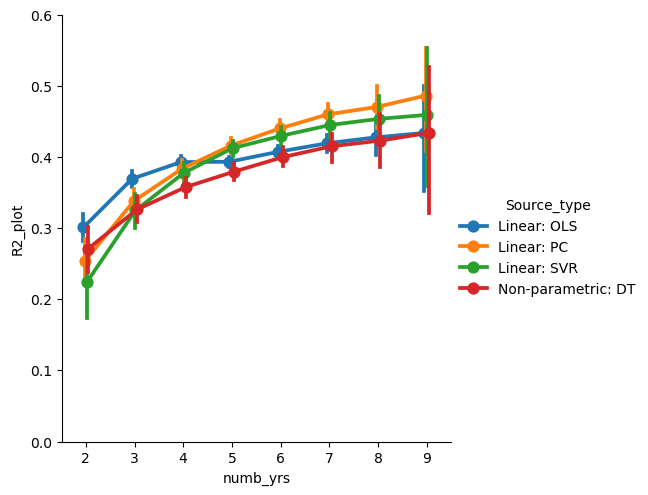

In [76]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type',
                dodge=True,
                data=df_boots_yr_transect,
               errorbar=('ci', 95))
g.set(ylim=(0, 0.6))

In [77]:
#df_boots_yr_transect[(df_boots_yr_transect['numb_yrs'] == 6) &
#(df_boots_yr_transect['Source_type'] == 'Linear: OLS')].sort_values('R2_plot').head(20)

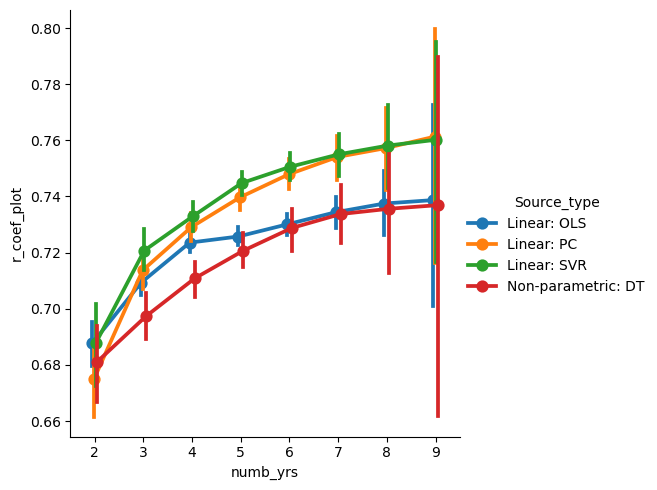

In [78]:
g = sns.catplot(kind='point', x='numb_yrs', y='r_coef_plot', hue='Source_type',
                dodge=True,
                data=df_boots_yr_transect,
               errorbar=('ci', 95))
#g.set(ylim=(0, 0.6))

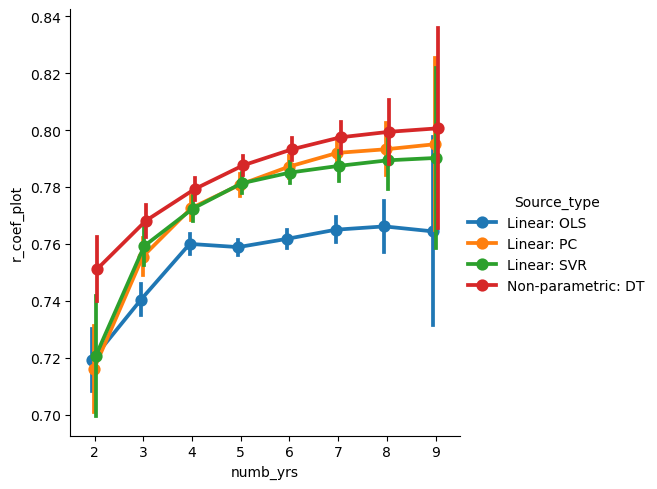

In [79]:
g = sns.catplot(kind='point', x='numb_yrs', y='r_coef_plot', hue='Source_type', 
                dodge=True,
                data=df_boots_avg,
               errorbar=('se', 2))
#g.set(ylim=(0, 0.6))

In [80]:
#df_boots_drought[df_boots_drought['numb_yrs'] == 3].sort_values('R2_plot').head(30)

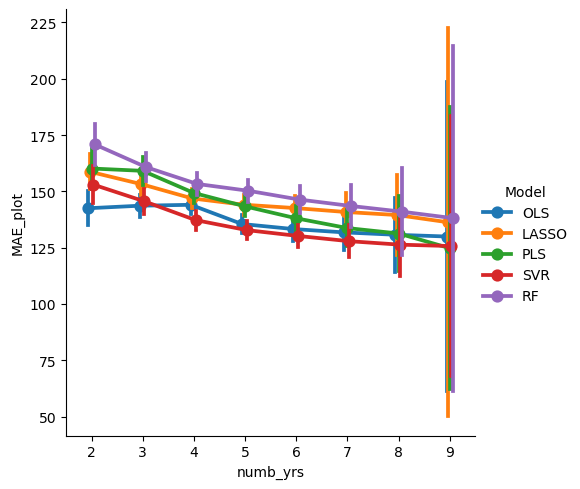

In [81]:
g = sns.catplot(kind='point', x='numb_yrs', y='MAE_plot', hue='Model', 
                dodge=True, 
                data=df_boots_drought, errorbar=('se', 2))
#g.set(ylim=(0, 0.6))

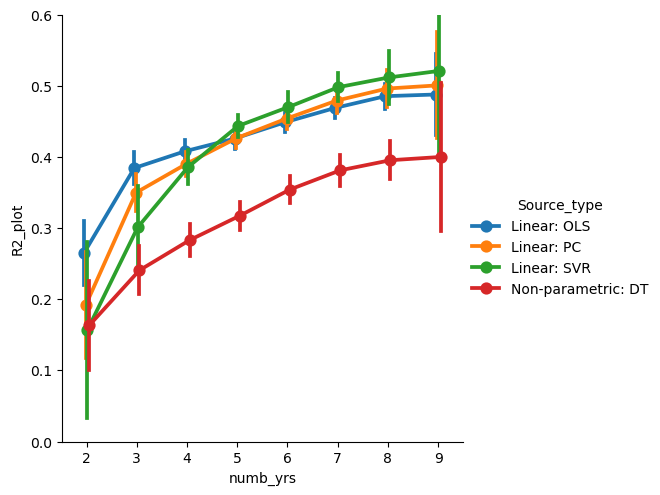

In [82]:
g = sns.catplot(kind='point', x='numb_yrs', y='R2_plot', hue='Source_type', 
                dodge=True,
                data=df_boots_wet,
               errorbar=('se', 2))
g.set(ylim=(0, 0.6))

## Euclidean distance of bootstraps

In [83]:
from tqdm import tqdm, notebook
import dask
from scipy.stats import hmean

In [84]:
df_boots_yr_transect = pd.read_csv('./results/tmp/vor_bootstrap_by_year_transect_v2.csv')
df_boots_yr_transect = df_boots_yr_transect[df_boots_yr_transect['Model'].isin(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR'])].copy()
df_boots_yr_transect['Source_type'] = df_boots_yr_transect['Model'].apply(lambda x: mod_name_dict[x])

In [85]:
#client.cluster.close()
#client.close()

In [86]:
import sys
sys.path.insert(1, '/project/cper_neon_aop/hls_nrt/extract')
from hpc_setup import launch_dask
import psutil
interface_prefs = [
        'ibp175s0',
        'ibp59s0',
        'enp24s0f0',
        'ens7f0',
        'ibp24s0',
        'ib0'
    ]
interface = [x for x in interface_prefs if x in list(psutil.net_if_addrs().keys())][0]
if len(interface) == 0:
    print('ERROR: Preferred interfaces not found on node!')
else:
    print(interface)
num_jobs=128
client = launch_dask(cluster_loc='hpc',
                     num_jobs=num_jobs,
                     num_processes=2,
                     num_threads_per_processes=2,
                     mem_gb_per=12.0,
                     partition='atlas', 
                     duration='2:00:00',
                     slurm_opts={'interface': interface},
                     extra_directives=["--account=cper_neon_aop"],
                     wait_proportion=0.25,
                    wait_timeout=240,
                    debug=False)
display(client)

ib0
   setting up cluster on HPC...


<Client: 'tcp://172.21.15.179:36975' processes=27 threads=54, memory=603.45 GiB>

In [87]:
#from distributed import get_client
#client = get_client()
#nthreads = len(client.nthreads())
#display(client)

In [88]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [89]:
df_plot['cv'].unique().item()

'Plot'

In [90]:
@dask.delayed
def pls_dist(i, df_cv, x_vars=var_names,
             y_var='sqrt_Biomass_kg_ha',
             centroids_only=True):
    dfs_out = []
    idxs_out = []
    X = df_cv[df_cv['kfold'] != i][x_vars]
    y = df_cv[df_cv['kfold'] != i][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=12)
    pc.fit(X_scaled, y)

    df_tmp = df_cv
    scores = pc.transform(scaler.transform(df_tmp[var_names]))

    pc_names = []
    naY = y
    r2_scores = []
    
    for j in range(scores.shape[1]):
        pc_names.append('PC' + str(j+1)) 
        df_tmp['PC'+str(j+1)] = scores[:,j]
        Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
        r2_scores.append(round(r2_score(y, Y_pred),3))

    df_k_sub = df_tmp[df_tmp['kfold'] == i]
    df_k_centroids = df_k_sub[df_k_sub['kfold'] == i][pc_names].mean(axis=0)
    df_other_centroids_kfolds = df_tmp[df_tmp['kfold'] != i].groupby('Year')[pc_names].mean()
    #ed_kfolds = np.sqrt(np.sum(r2_scores*(df_k_centroids - df_other_centroids_kfolds)**2, axis=1))
    ed_kfolds = np.sqrt(np.sum((df_k_centroids - df_other_centroids_kfolds)**2, axis=1))
    df_other_centroids_all = df_tmp[df_tmp['kfold'] != i][pc_names].mean()
    #ed_all = np.sqrt(np.sum(r2_scores*(df_k_centroids - df_other_centroids_all)**2))
    ed_all = np.sqrt(np.sum((df_k_centroids - df_other_centroids_all)**2))
    if centroids_only:
        dfs_out.append({'kfold': i,
                        'cv': df_tmp['cv'].unique().item(),
                        'distances_centroid_all_mean': np.mean(ed_all),
                        'distances_centroid_yrs_mean': np.mean(ed_kfolds),
                        'distances_centroid_yrs_min': np.min(ed_kfolds),
                        'distances_centroid_all_hmean': hmean(ed_all+1e-10),
                        'distances_centroid_kfolds_hmean': hmean(ed_kfolds+1e-10)})
    else:
        distances_mean = []
        distances_hmean = []
        distances_mean_within = []
        distances_hmean_within = []
        for row_idx, row in df_k_sub.iterrows():
            point = row[pc_names].values.astype(float)
            other_points = df_tmp[df_tmp['kfold'] != i][pc_names].values.astype(float)
            within_points = df_tmp[(df_tmp.index != row_idx) & (df_tmp['kfold'] == i)][pc_names].values.astype(float)
            #ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
            #ec_wdistances_within = np.sqrt(np.sum(r2_scores*(within_points - point) ** 2, axis=1))
            ec_wdistances = np.sqrt(np.sum((other_points - point) ** 2, axis=1))
            ec_wdistances_within = np.sqrt(np.sum((within_points - point) ** 2, axis=1))
            distances_mean.append(np.mean(ec_wdistances))
            distances_hmean.append(hmean(ec_wdistances+1e-10))
            distances_mean_within.append(np.mean(ec_wdistances_within))
            distances_hmean_within.append(hmean(ec_wdistances_within+1e-10))
        dfs_out.append({'kfold': i,
                        'cv': df_tmp['cv'].unique().item(),
                        'distances_centroid_all_mean': np.mean(ed_all),
                        'distances_centroid_kfolds_mean': np.mean(ed_kfolds),
                        'distances_centroid_kfolds_min': np.min(ed_kfolds),
                        'distances_centroid_all_hmean': hmean(ed_all+1e-10),
                        'distances_centroid_kfolds_hmean': hmean(ed_kfolds+1e-10),
                        'distances_mean': np.mean(distances_mean),
                        'distances_hmean': np.mean(distances_hmean),
                       'distances_mean_within': np.mean(distances_mean_within),
                        'distances_hmean_within': np.mean(distances_hmean_within)})
    df_out = pd.DataFrame(dfs_out)
    return df_out

In [91]:
plot_results_tmp = [pls_dist(x, df_plot, centroids_only=False) for x in df_plot['kfold'].unique()]
plot_results = dask.compute(*plot_results_tmp)

In [92]:
spatial_results_tmp = [pls_dist(x, df_spatial, centroids_only=False) for x in df_spatial['kfold'].unique()]
spatial_results = dask.compute(*spatial_results_tmp)

In [93]:
ecosite_results_tmp = [pls_dist(x, df_ecosite, centroids_only=False) for x in df_ecosite['kfold'].unique()]
ecosite_results = dask.compute(*ecosite_results_tmp)

In [94]:
year_results_tmp = [pls_dist(x, df_year, centroids_only=False) for x in df_year['kfold'].unique()]
year_results = dask.compute(*year_results_tmp)

In [95]:
df_ec_dists = pd.concat([pd.concat(plot_results), 
                         pd.concat(spatial_results), 
                         pd.concat(ecosite_results), 
                         pd.concat(year_results)])

In [96]:
df_ec_dists['distances_hmean_ratio'] = df_ec_dists['distances_hmean']/df_ec_dists['distances_hmean_within']

In [97]:
df_all_k = pd.concat([pd.merge(t_plot, pd.concat(plot_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_spatial.rename(columns={'spatial': 'kfold'}), pd.concat(spatial_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_ecosite.rename(columns={'ecosite': 'kfold'}), pd.concat(ecosite_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_year, pd.concat(year_results), how='left', on=['kfold', 'cv'])])

In [98]:
df_all_k['distances_hmean_ratio'] = df_all_k['distances_hmean']/df_all_k['distances_hmean_within']
df_all_k_long = pd.melt(df_all_k, id_vars=['Source', 'kfold', 'cv', 'distances_mean', 'distances_hmean', 
                                           'distances_mean_within', 'distances_hmean_within',
                                           'distances_hmean_ratio',
                                           'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
        value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
        var_name='metric')

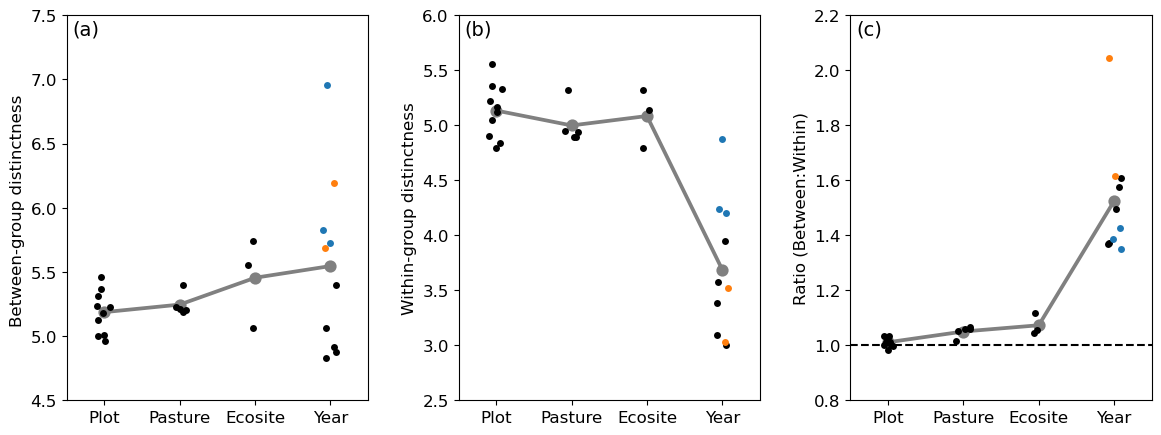

In [111]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5), gridspec_kw={'wspace': 0.3})

sns.stripplot(x='cv', y='distances_hmean', data=df_ec_dists[~df_ec_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_dists[df_ec_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_dists[df_ec_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[0])
sns.pointplot(x='cv', y='distances_hmean', data=df_ec_dists, 
              errorbar=None, c='grey', ax=axs[0])

sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_dists[~df_ec_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_dists[df_ec_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_dists[df_ec_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[1])
sns.pointplot(x='cv', y='distances_hmean_within', data=df_ec_dists, 
              errorbar=None,  c='grey', ax=axs[1])

sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_dists[~df_ec_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_dists[df_ec_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_dists[df_ec_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[2])
sns.pointplot(x='cv', y='distances_hmean_ratio', data=df_ec_dists, 
              errorbar=None, c='grey', ax=axs[2])

axs[0].set_ylabel('Between-group distinctness ')
axs[1].set_ylabel('Within-group distinctness')
axs[2].set_ylabel('Ratio (Between:Within)')

axs[2].axhline(y=1.0, linestyle='dashed', c='black')

for idx, ax in enumerate(axs):
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_xlabel('')
    ax.annotate(['(a)', '(b)', '(c)'][idx], (0.02, 0.95), xycoords='axes fraction', fontsize=14)
    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(['Plot', 'Pasture', 'Ecosite', 'Year'], fontsize=12)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)

In [112]:
from scipy.stats import pearsonr, spearmanr
import numpy as np
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
sub_cols = ['distances_hmean', 'distances_hmean_within', 'distances_hmean_ratio', 'R^2', 'r', 'MAE', 'MAE_pct']
rho = df_all_k[sub_cols + ['Source']].groupby('Source').corr(method='spearman')
pval = df_all_k[sub_cols + ['Source']].groupby('Source').corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(*rho.shape)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
df_cor_sig = rho.round(2).map('{:,.2f}'.format) #+ p
for c in ['R^2', 'r', 'MAE', 'MAE_pct']:
    df_cor_sig.loc[~p[c].str.contains('\*'), c] = ''
df_cor_sig = df_cor_sig.drop(
    index=['R^2', 'r', 'MAE', 'MAE_pct'], level=1).drop(
    index=['CPER_2022', 'ENS_ALL', 'ENS_LIN', 'ENS_ML', 'HGBR', 'OLS_2022', 'PCR'], level=0).drop(
    columns=['distances_hmean', 'distances_hmean_within', 'distances_hmean_ratio'])
df_cor_sig = df_cor_sig.loc[['OLS', 'LASSO', 'PLS', 'SVR', 'RF']]
df_cor_sig = df_cor_sig.rename(index={'distances_hmean': 'Between groups',
                         'distances_hmean_within': 'Within groups',
                         'distances_hmean_ratio': 'Ratio (Between:Within)'}).reset_index(names=['Model', 'Distinctness'])
#df_cor_sig.to_csv('./results/tables/ml_models/corr_distinctness_vs_performance.csv')

In [113]:
display(df_cor_sig)

Model            Distinctness    R^2      r   MAE MAE_pct
0     OLS          Between groups                0.51    0.59
1     OLS           Within groups   0.52                     
2     OLS  Ratio (Between:Within)  -0.72  -0.51              
3   LASSO          Between groups                0.43    0.44
4   LASSO           Within groups   0.48   0.45              
5   LASSO  Ratio (Between:Within)  -0.67  -0.61              
6     PLS          Between groups         -0.37  0.44    0.41
7     PLS           Within groups   0.44   0.41              
8     PLS  Ratio (Between:Within)  -0.64  -0.57              
9     SVR          Between groups         -0.41              
10    SVR           Within groups   0.47                     
11    SVR  Ratio (Between:Within)  -0.68  -0.52              
12     RF          Between groups         -0.44  0.45    0.57
13     RF           Within groups   0.59   0.58              
14     RF  Ratio (Between:Within)  -0.80  -0.79          0.49

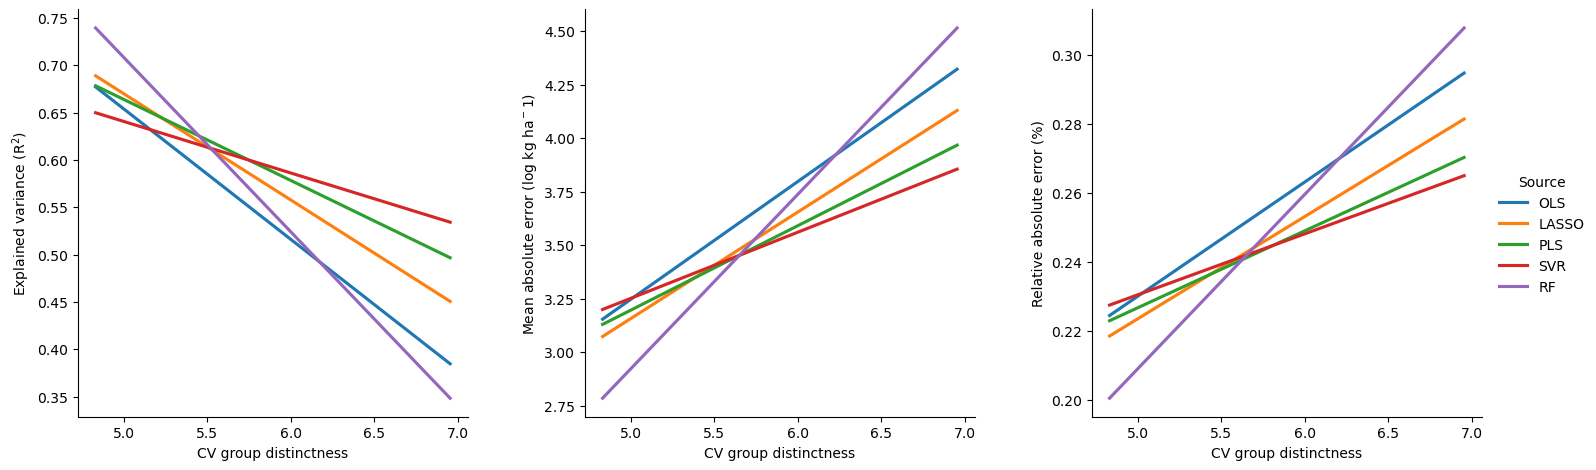

In [114]:
g = sns.lmplot(x='distances_hmean', y='value', hue='Source', col='metric',
               ci=None, scatter=False, 
               facet_kws=dict(sharey=False, legend_out=True),
               data=df_all_k_long[df_all_k_long['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_all_k_long['metric'].isin(['R^2', 'MAE', 'MAE_pct'])],
               col_order=['R^2', 'MAE', 'MAE_pct'])
g.axes.flatten()[0].set_ylabel('Explained variance (R$^2$)')
g.axes.flatten()[1].set_ylabel('Mean absolute error (log kg ha$^-1$)')
g.axes.flatten()[2].set_ylabel('Relative absolute error (%)')
#g.add_legend(loc='lower right')
for ax in g.axes.flatten():
    ax.set_xlabel('CV group distinctness')
    ax.set_title('')
g.fig.subplots_adjust(wspace=0.3)

## Euclidean distance of kmeans

In [115]:
kmeans_results_tmp = [pls_dist(x, df_kmeans, centroids_only=False) for x in df_kmeans['kfold'].unique()]
kmeans_results = dask.compute(*kmeans_results_tmp)

In [116]:
df_ec_both_dists = pd.concat([pd.concat(plot_results), 
                         pd.concat(spatial_results), 
                         pd.concat(ecosite_results), 
                         pd.concat(year_results),
                         pd.concat(kmeans_results)])

In [117]:
df_ec_both_dists['distances_hmean_ratio'] = df_ec_both_dists['distances_hmean']/df_ec_both_dists['distances_hmean_within']

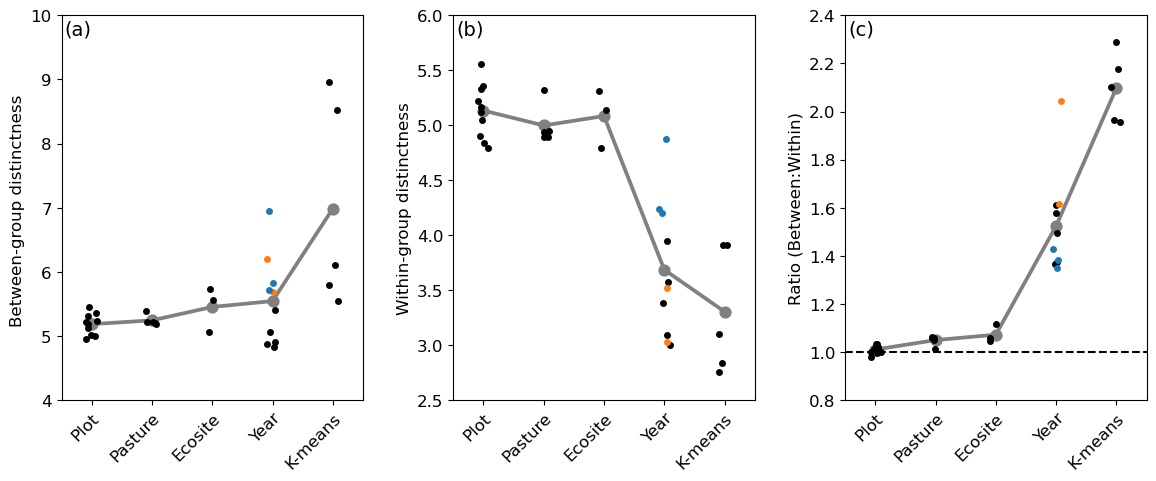

In [164]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5), gridspec_kw={'wspace': 0.3})

sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[0])
sns.pointplot(x='cv', y='distances_hmean', data=df_ec_both_dists, 
              errorbar=None, c='grey', ax=axs[0])

sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[1])
sns.pointplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists, 
              errorbar=None,  c='grey', ax=axs[1])

sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[2])
sns.pointplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists, 
              errorbar=None, c='grey', ax=axs[2])

axs[0].set_ylabel('Between-group distinctness ')
axs[1].set_ylabel('Within-group distinctness')
axs[2].set_ylabel('Ratio (Between:Within)')

axs[2].axhline(y=1.0, linestyle='dashed', c='black')

for idx, ax in enumerate(axs):
    ax.set_xlabel('')
    ax.annotate(['(a)', '(b)', '(c)'][idx], (0.01, 0.95), xycoords='axes fraction', fontsize=14)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['Plot', 'Pasture', 'Ecosite', 'Year', 'K-means'], fontsize=12, 
                       rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
plt.savefig('./results/figures/Fig2_ecdist_by_cv.png', dpi=300, bbox_inches='tight')

In [128]:
df_kmeans_results = pd.concat(kmeans_results)
df_kmeans_results['kfold'] = df_kmeans_results['kfold'].astype(int)
df_kmeans_results['cv'] = 'Kmeans'
df_all_k_both = pd.concat([pd.merge(t_plot, pd.concat(plot_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_spatial.rename(columns={'spatial': 'kfold'}), pd.concat(spatial_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_ecosite.rename(columns={'ecosite': 'kfold'}), pd.concat(ecosite_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_year, pd.concat(year_results), how='left', on=['kfold', 'cv']),
                     pd.merge(t_kmeans, df_kmeans_results, how='left', on=['kfold', 'cv'])]).reset_index(drop=True)

In [129]:
df_all_k_both['distances_hmean_ratio'] = df_all_k_both['distances_hmean']/df_all_k_both['distances_hmean_within']
df_both_t_long = pd.melt(df_all_k_both,
                         id_vars=['Source', 'kfold', 'cv', 'distances_mean', 'distances_hmean', 
                                  'distances_mean_within', 'distances_hmean_within',
                                  'distances_hmean_ratio',
                                  'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                         value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                         value_name='performance',
                         var_name='p_metric')

In [130]:
df_both_t_long_mean = pd.melt(df_all_k_both.drop(columns='kfold').groupby(['Source', 'cv']).mean().reset_index(),
                                         id_vars=['Source', 'cv',  'distances_mean', 'distances_hmean', 
                                                  'distances_mean_within', 'distances_hmean_within',
                                                  'distances_hmean_ratio',
                                                  'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                                         value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                                         value_name='performance',
                                         var_name='p_metric')
df_both_t_long_mean = pd.melt(df_both_t_long_mean.drop(columns=['distances_mean', 'distances_mean_within', 'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean']), 
        id_vars=['Source', 'cv', 'p_metric', 'performance'],
        value_vars=[ 'distances_hmean',  'distances_hmean_within','distances_hmean_ratio'],
        value_name='distance',
        var_name='d_metric')

In [131]:
from scipy.optimize import curve_fit

def func_ed(x, a, b):
    return a*np.exp(-b*x)

def func_log(x, a, b):
    return a+b*np.log10(x)
    #return a*x /(b + x)
    #return a*x**b

def func_pwr(x, a, b):
    return a*x**b

def func_asym(x, a, b, c):
    return a-(a-b)*np.exp(-c*x)
    #return a*(1-np.exp(-b*x))


In [132]:
tab_cols = sns.color_palette('tab10')
buff_min = 0.99
buff_max = 1.01

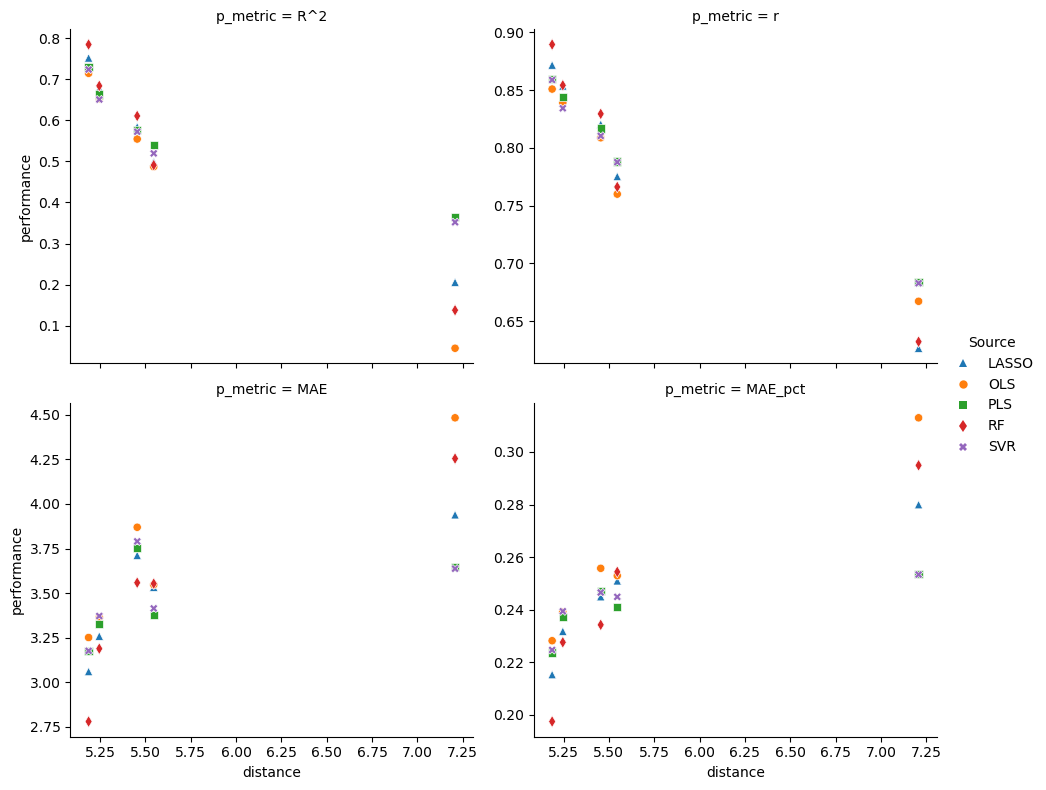

In [143]:
marker_list = ["o", "^", "s", "X", "d"]
g = sns.relplot(x='distance', y='performance', hue='Source', col='p_metric', col_wrap=2,
               height=4, aspect=1.2, 
                style='Source', style_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'], markers=marker_list,
               facet_kws=dict(sharey=False, sharex='col', legend_out=True),
               data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_both_t_long_mean['p_metric'].isin(['R^2', 'r', 'MAE', 'MAE_pct']) &
               df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans']) &
                (df_both_t_long_mean['d_metric'] == 'distances_hmean')],
               col_order=['R^2', 'r', 'MAE', 'MAE_pct'])

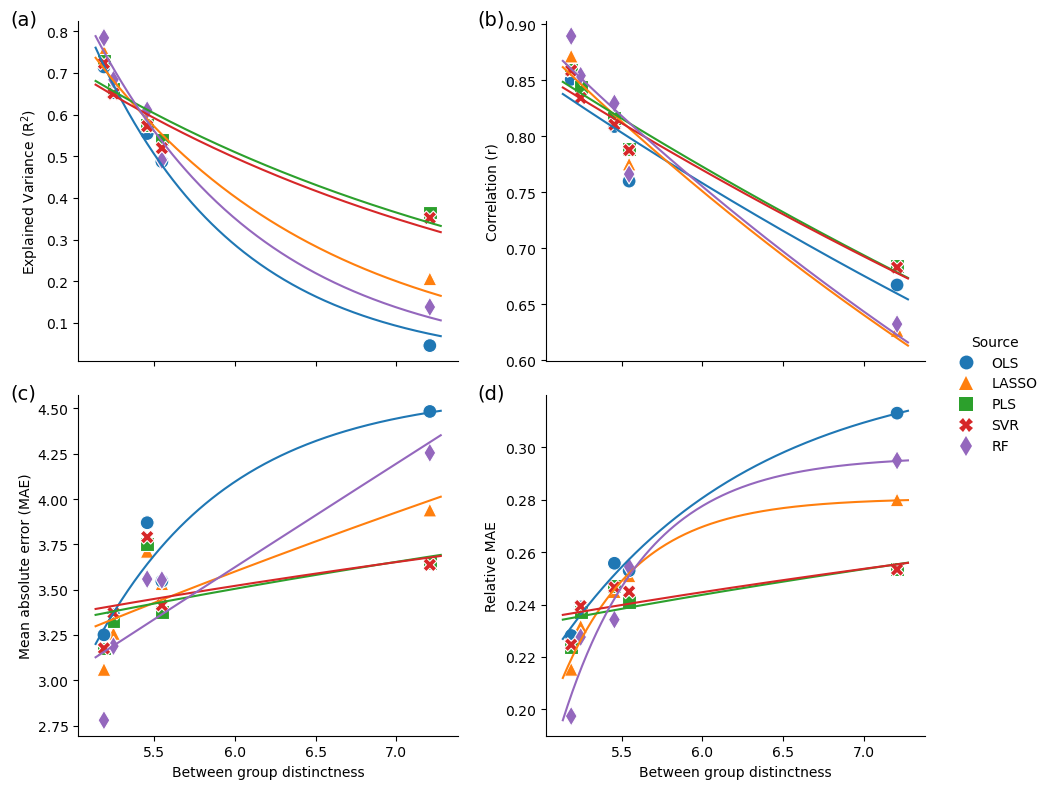

In [169]:
marker_list = ["o", "^", "s", "X", "d"]
g = sns.relplot(x='distance', y='performance', hue='Source', col='p_metric', col_wrap=2,
                height=4, aspect=1.2, 
                style='Source', markers=marker_list, s=100,
                facet_kws=dict(sharey=False, sharex='col', legend_out=True),
                data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
                df_both_t_long_mean['p_metric'].isin(['R^2', 'r', 'MAE', 'MAE_pct']) &
                df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans']) &
                (df_both_t_long_mean['d_metric'] == 'distances_hmean')],
                col_order=['R^2', 'r', 'MAE', 'MAE_pct'],
               style_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'],
               hue_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'])
g.set_titles(template="")
for p_idx, x_var in enumerate(['R^2', 'r', 'MAE', 'MAE_pct']):
    df_sub = df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
     (df_both_t_long_mean['d_metric'] == 'distances_hmean') &
    (df_both_t_long_mean['p_metric'] == x_var) &
    df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans'])]
    for s_idx, s in enumerate(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']):
        x = df_sub['distance'][(df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            #print('using power function')
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes.flatten()[p_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
for y_lab_idx, y_lab in enumerate(['Explained Variance ($\mathregular{R^{2}}$)', 'Correlation (r)', 'Mean absolute error (MAE)', 'Relative MAE']):
    g.axes.flatten()[y_lab_idx].set_ylabel(y_lab)
for letter_idx, letter in enumerate(['(a)', '(b)', '(c)', '(d)']):
    g.axes.flatten()[letter_idx].annotate(letter, (-0.18, 0.99), xycoords='axes fraction', fontsize=14)
g.set_axis_labels('Between group distinctness')
g.tight_layout()
plt.savefig('./results/figures/Fig6_btw_group_distinct.png', dpi=300, bbox_inches='tight')

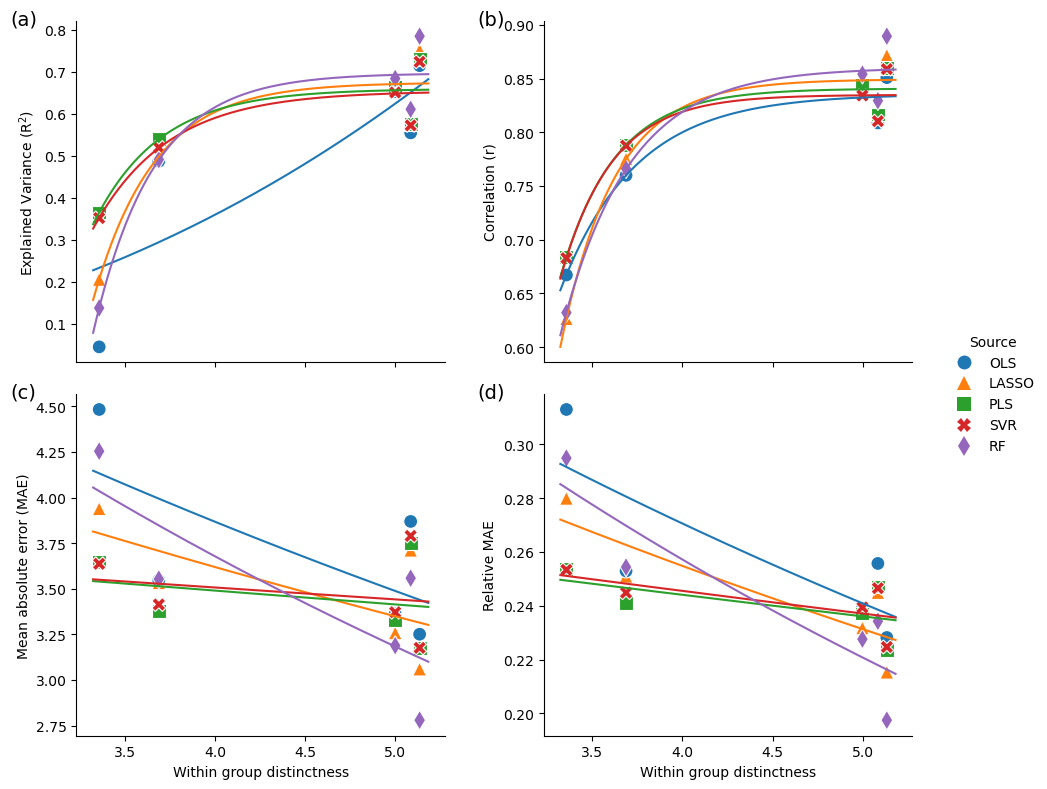

In [170]:
g = sns.relplot(x='distance', y='performance', hue='Source', col='p_metric', col_wrap=2,
               height=4, aspect=1.2,
                style='Source', markers=marker_list, s=100,
               facet_kws=dict(sharey=False, sharex='col', legend_out=True),
               data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_both_t_long_mean['p_metric'].isin(['R^2', 'r', 'MAE', 'MAE_pct']) &
               df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans']) &
                (df_both_t_long_mean['d_metric'] == 'distances_hmean_within')],
               col_order=['R^2', 'r', 'MAE', 'MAE_pct'],
               style_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'],
               hue_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'])
g.set_titles(template="")
for p_idx, x_var in enumerate(['R^2', 'r', 'MAE', 'MAE_pct']):
    df_sub = df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
     (df_both_t_long_mean['d_metric'] == 'distances_hmean_within') &
    (df_both_t_long_mean['p_metric'] == x_var) &
    df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans'])]
    for s_idx, s in enumerate(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']):
        x = df_sub['distance'][(df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            #print('using power function')
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes.flatten()[p_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
for y_lab_idx, y_lab in enumerate(['Explained Variance ($\mathregular{R^{2}}$)', 'Correlation (r)', 'Mean absolute error (MAE)', 'Relative MAE']):
    g.axes.flatten()[y_lab_idx].set_ylabel(y_lab)
for letter_idx, letter in enumerate(['(a)', '(b)', '(c)', '(d)']):
    g.axes.flatten()[letter_idx].annotate(letter, (-0.18, 0.99), xycoords='axes fraction', fontsize=14)
g.set_axis_labels('Within group distinctness')
g.tight_layout()
plt.savefig('./results/figures/FigS3_within_grp_distinct.png', dpi=300, bbox_inches='tight')

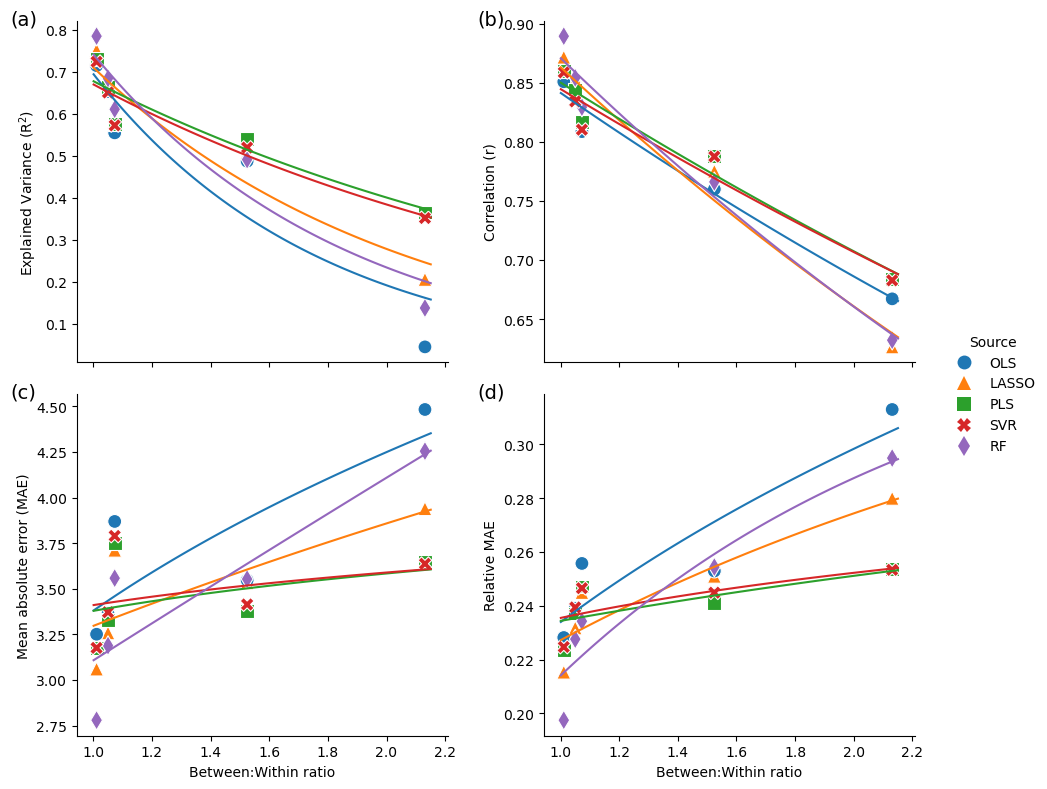

In [171]:
g = sns.relplot(x='distance', y='performance', hue='Source', col='p_metric', col_wrap=2,
               height=4, aspect=1.2,
                style='Source', markers=marker_list, s=100,
               facet_kws=dict(sharey=False, sharex='col', legend_out=True),
               data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_both_t_long_mean['p_metric'].isin(['R^2', 'r', 'MAE', 'MAE_pct']) &
               df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans']) &
                (df_both_t_long_mean['d_metric'] == 'distances_hmean_ratio')],
               col_order=['R^2', 'r', 'MAE', 'MAE_pct'],
                style_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'],
               hue_order=['OLS', 'LASSO', 'PLS', 'SVR', 'RF'])
g.set_titles(template="")
for p_idx, x_var in enumerate(['R^2', 'r', 'MAE', 'MAE_pct']):
    df_sub = df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
     (df_both_t_long_mean['d_metric'] == 'distances_hmean_ratio') &
    (df_both_t_long_mean['p_metric'] == x_var) &
    df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'Kmeans'])]
    for s_idx, s in enumerate(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']):
        x = df_sub['distance'][(df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            #print('using power function')
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes.flatten()[p_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
for y_lab_idx, y_lab in enumerate(['Explained Variance ($\mathregular{R^{2}}$)', 'Correlation (r)', 'Mean absolute error (MAE)', 'Relative MAE']):
    g.axes.flatten()[y_lab_idx].set_ylabel(y_lab)
for letter_idx, letter in enumerate(['(a)', '(b)', '(c)', '(d)']):
    g.axes.flatten()[letter_idx].annotate(letter, (-0.18, 0.99), xycoords='axes fraction', fontsize=14)
g.set_axis_labels('Between:Within ratio')
g.tight_layout()
plt.savefig('./results/figures/FigS4_ratio_grp_distinct.png', dpi=300, bbox_inches='tight')

In [77]:
kmeans_r99_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r99': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r99'].unique()]
kmeans_r99_results = dask.compute(*kmeans_r99_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [78]:
kmeans_r95_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r95': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r95'].unique()]
kmeans_r95_results = dask.compute(*kmeans_r95_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [79]:
kmeans_r85_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r85': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r85'].unique()]
kmeans_r85_results = dask.compute(*kmeans_r85_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [80]:
kmeans_r75_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r75': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r75'].unique()]
kmeans_r75_results = dask.compute(*kmeans_r75_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [81]:
kmeans_r50_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r50': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r50'].unique()]
kmeans_r50_results = dask.compute(*kmeans_r50_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [82]:
kmeans_r10_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r10': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r10'].unique()]
kmeans_r10_results = dask.compute(*kmeans_r10_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [83]:
kmeans_r1_results_tmp = [pls_dist(x, 
                                   df_kmeans.drop(columns=['kfold']).rename(columns={'kfold_r1': 'kfold'}), 
                                   centroids_only=False) for x in df_kmeans['kfold_r1'].unique()]
kmeans_r1_results = dask.compute(*kmeans_r1_results_tmp)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 21.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [84]:
cv_kmeans = []
for k in keep_fracs:
    if k == 100:
        cv_kmeans.extend(['' for x in range(5)])
    else:
        cv_kmeans.extend(['_r' + str(k) for x in range(5)])

In [85]:
df_ec_kmeans_dists = pd.concat([pd.concat(kmeans_results), 
                                pd.concat(kmeans_r99_results), 
                                pd.concat(kmeans_r95_results), 
                                pd.concat(kmeans_r85_results),
                                pd.concat(kmeans_r75_results),
                                pd.concat(kmeans_r50_results),
                                pd.concat(kmeans_r10_results),
                                pd.concat(kmeans_r1_results)])
df_ec_kmeans_dists = df_ec_kmeans_dists.reset_index(drop=True)

In [86]:
df_ec_kmeans_dists['cv'] = df_ec_kmeans_dists['cv'] + pd.Series(cv_kmeans)

In [87]:
df_ec_kmeans_dists['distances_hmean_ratio'] = df_ec_kmeans_dists['distances_hmean']/df_ec_kmeans_dists['distances_hmean_within']

In [90]:
print('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_r' +
                               str(f) + 
                               '_tuneby_Kmeans_r' + 
                               str(f) + 
                               '_results_plot_yrly.csv')

./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_r1_tuneby_Kmeans_r1_results_plot_yrly.csv


In [100]:
t_kmeans_list = []
for k in keep_fracs:
    if k == 100:
        t_kmeans_tmp = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_' +
                               'tuneby_Kmeans_results_plot_yrly.csv')
        k_match = 'kmeans'
    else:
        t_kmeans_tmp = pd.read_csv('./results/tables/ml_models/vor_2014_2023_cln_2024_04_04_transect_cv_Kmeans_r' +
                               str(k) + 
                               '_tuneby_Kmeans_r' + 
                               str(k) + 
                               '_results_plot_yrly.csv')
        k_match = 'kmeans_r'+str(k)
    t_kmeans_list.append(pd.merge(t_kmeans_tmp, 
                                  df_ec_kmeans_dists[df_ec_kmeans_dists['cv']==k_match], 
                                  how='left', 
                                  on='kfold'))
df_kmeans_t = pd.concat(t_kmeans_list)

In [101]:
df_kmeans_t.loc[df_kmeans_t["R^2"] < 0, "R^2"] = 0

In [102]:
#df_kmeans_t[df_kmeans_t['Source'] == 'PLS']#.groupby(['Source', 'cv']).median().reset_index()

In [108]:
df_kmeans_t_long = pd.melt(df_kmeans_t,#.groupby(['Source', 'cv']).mean().reset_index(), 
                           id_vars=['Source', 'kfold', 'cv', 'distances_mean', 'distances_hmean', 
                                    'distances_mean_within', 'distances_hmean_within',
                                    'distances_hmean_ratio',
                                    'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                           value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                           var_name='metric')

df_kmeans_t_long_mean = pd.melt(df_kmeans_t.groupby(['Source', 'cv']).mean().reset_index(), 
                           id_vars=['Source', 'kfold', 'cv', 'distances_mean', 'distances_hmean', 
                                    'distances_mean_within', 'distances_hmean_within',
                                    'distances_hmean_ratio',
                                    'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                           value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                           var_name='metric')

<Axes: xlabel='cv', ylabel='distances_hmean_ratio'>

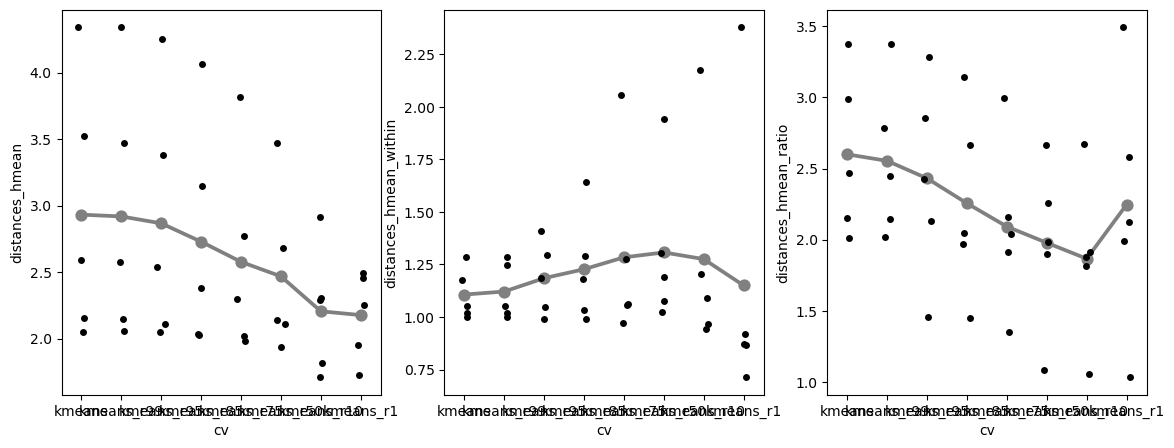

In [110]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))

sns.stripplot(x='cv', y='distances_hmean', data=df_ec_kmeans_dists,
                  c='black', ax=axs[0])
sns.pointplot(x='cv', y='distances_hmean', data=df_ec_kmeans_dists, 
              errorbar=None, c='grey', ax=axs[0])

sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_kmeans_dists,
                  c='black', ax=axs[1])
sns.pointplot(x='cv', y='distances_hmean_within', data=df_ec_kmeans_dists, 
              errorbar=None, c='grey', ax=axs[1])

sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_kmeans_dists,
                  c='black', ax=axs[2])
sns.pointplot(x='cv', y='distances_hmean_ratio', data=df_ec_kmeans_dists, 
              errorbar=None, c='grey', ax=axs[2])
#sns.pointplot(x='cv', y='distances_hmean', data=df_ec_kmeans_dists,
                  #c='black', ax=axs[0])

In [252]:
df_ec_both_dists = pd.concat([df_ec_dists, df_ec_kmeans_dists[df_ec_kmeans_dists['cv'] == 'kmeans']])

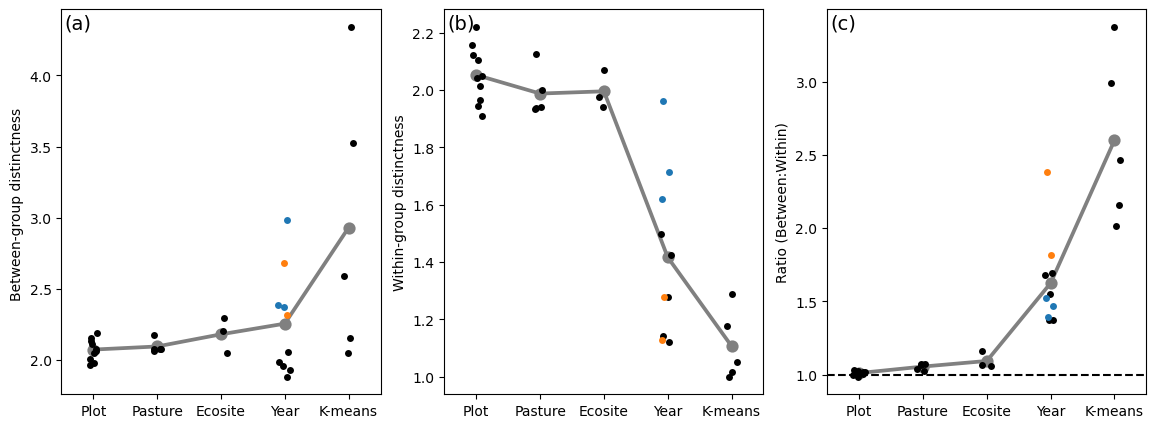

In [391]:
fig, axs = plt.subplots(ncols=3, figsize=(14, 5))

sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[0])
sns.stripplot(x='cv', y='distances_hmean', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[0])
sns.pointplot(x='cv', y='distances_hmean', data=df_ec_both_dists, 
              errorbar=None, c='grey', ax=axs[0])

sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[1])
sns.stripplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[1])
sns.pointplot(x='cv', y='distances_hmean_within', data=df_ec_both_dists, 
              errorbar=None,  c='grey', ax=axs[1])

sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[~df_ec_both_dists['kfold'].isin([2014, 2015, 2020, 2022, 2023])],
                  c='black', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2020, 2022])],
                  c='tab:orange', ax=axs[2])
sns.stripplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists[df_ec_both_dists['kfold'].isin([2014, 2015, 2023])],
                  c='tab:blue', ax=axs[2])
sns.pointplot(x='cv', y='distances_hmean_ratio', data=df_ec_both_dists, 
              errorbar=None, c='grey', ax=axs[2])

axs[0].set_ylabel('Between-group distinctness ')
axs[1].set_ylabel('Within-group distinctness')
axs[2].set_ylabel('Ratio (Between:Within)')

axs[2].axhline(y=1.0, linestyle='dashed', c='black')

for idx, ax in enumerate(axs):
    ax.set_xlabel('')
    ax.annotate(['(a)', '(b)', '(c)'][idx], (0.01, 0.95), xycoords='axes fraction', fontsize=14)
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(['Plot', 'Pasture', 'Ecosite', 'Year', 'K-means'])

In [ ]:
df_both_t_long_mean = pd.concat([pd.melt(df_kmeans_t.groupby(['Source', 'cv']).mean().reset_index(), 
                                         id_vars=['Source', 'kfold', 'cv', 'distances_mean', 'distances_hmean', 
                                                  'distances_mean_within', 'distances_hmean_within',
                                                  'distances_hmean_ratio',
                                                  'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                                         value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                                         value_name='performance',
                                         var_name='p_metric'),
                                 pd.melt(df_all_k.drop(columns='kfold').groupby(['Source', 'cv']).mean().reset_index(),
                                         id_vars=['Source', 'cv', 'distances_mean', 'distances_hmean', 
                                                  'distances_mean_within', 'distances_hmean_within',
                                                  'distances_hmean_ratio',
                                                  'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean'], 
                                         value_vars=['MAE', 'Bias', 'MAE_bt', 'MAE_pct', 'R^2', 'r'],
                                         value_name='performance',
                                         var_name='p_metric')]).reset_index(drop=True)

df_both_t_long_mean = pd.melt(df_both_t_long_mean.drop(columns=['distances_mean', 'distances_mean_within', 'distances_centroid_all_hmean', 'distances_centroid_kfolds_hmean']), 
        id_vars=['Source', 'kfold', 'cv', 'p_metric', 'performance'],
        value_vars=[ 'distances_hmean',  'distances_hmean_within','distances_hmean_ratio'],
        value_name='distance',
        var_name='d_metric')

In [333]:
from scipy.optimize import curve_fit

def func_ed(x, a, b):
    return a*np.exp(-b*x)

def func_log(x, a, b):
    return a+b*np.log10(x)
    #return a*x /(b + x)
    #return a*x**b

def func_pwr(x, a, b):
    return a*x**b

def func_asym(x, a, b, c):
    return a-(a-b)*np.exp(-c*x)
    #return a*(1-np.exp(-b*x))


In [361]:
tab_cols = sns.color_palette('tab10')
buff_min = 0.99
buff_max = 1.01

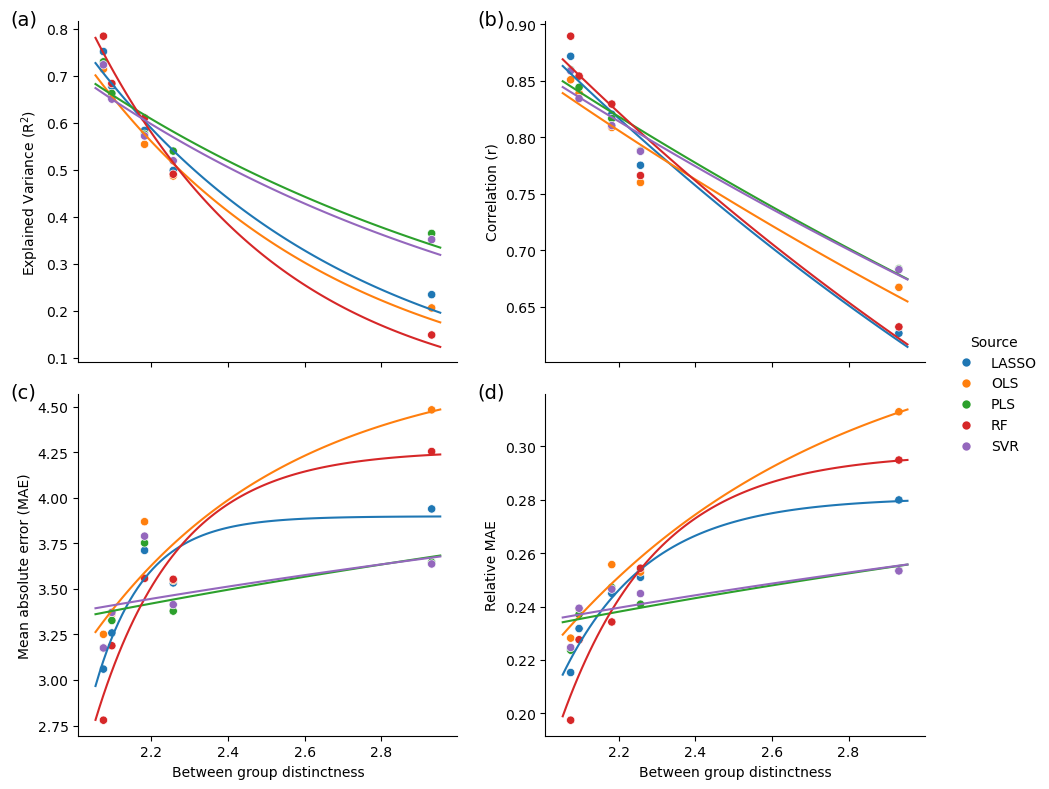

In [435]:
g = sns.relplot(x='distance', y='performance', hue='Source', col='p_metric', col_wrap=2,
               height=4, aspect=1.2,
               facet_kws=dict(sharey=False, sharex='col', legend_out=True),
               data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_both_t_long_mean['p_metric'].isin(['R^2', 'r', 'MAE', 'MAE_pct']) &
               df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'kmeans']) &
                (df_both_t_long_mean['d_metric'] == 'distances_hmean')],
               col_order=['R^2', 'r', 'MAE', 'MAE_pct'])
g.set_titles(template="")
for p_idx, x_var in enumerate(['R^2', 'r', 'MAE', 'MAE_pct']):
    df_sub = df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
     (df_both_t_long_mean['d_metric'] == 'distances_hmean') &
    (df_both_t_long_mean['p_metric'] == x_var) &
    df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'kmeans'])]
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e10:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            #print('using power function')
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes.flatten()[p_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
for y_lab_idx, y_lab in enumerate(['Explained Variance ($\mathregular{R^{2}}$)', 'Correlation (r)', 'Mean absolute error (MAE)', 'Relative MAE']):
    g.axes.flatten()[y_lab_idx].set_ylabel(y_lab)
for letter_idx, letter in enumerate(['(a)', '(b)', '(c)', '(d)']):
    g.axes.flatten()[letter_idx].annotate(letter, (-0.18, 0.99), xycoords='axes fraction', fontsize=14)
g.set_axis_labels('Between group distinctness')
g.tight_layout()

In [ ]:
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['p_metric'] == 'MAE') & (df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['p_metric'] == 'MAE') & (df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes[1, d_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
    
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['p_metric'] == 'MAE_pct') & (df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['p_metric'] == 'MAE_pct') & (df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes[2, d_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                              func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])

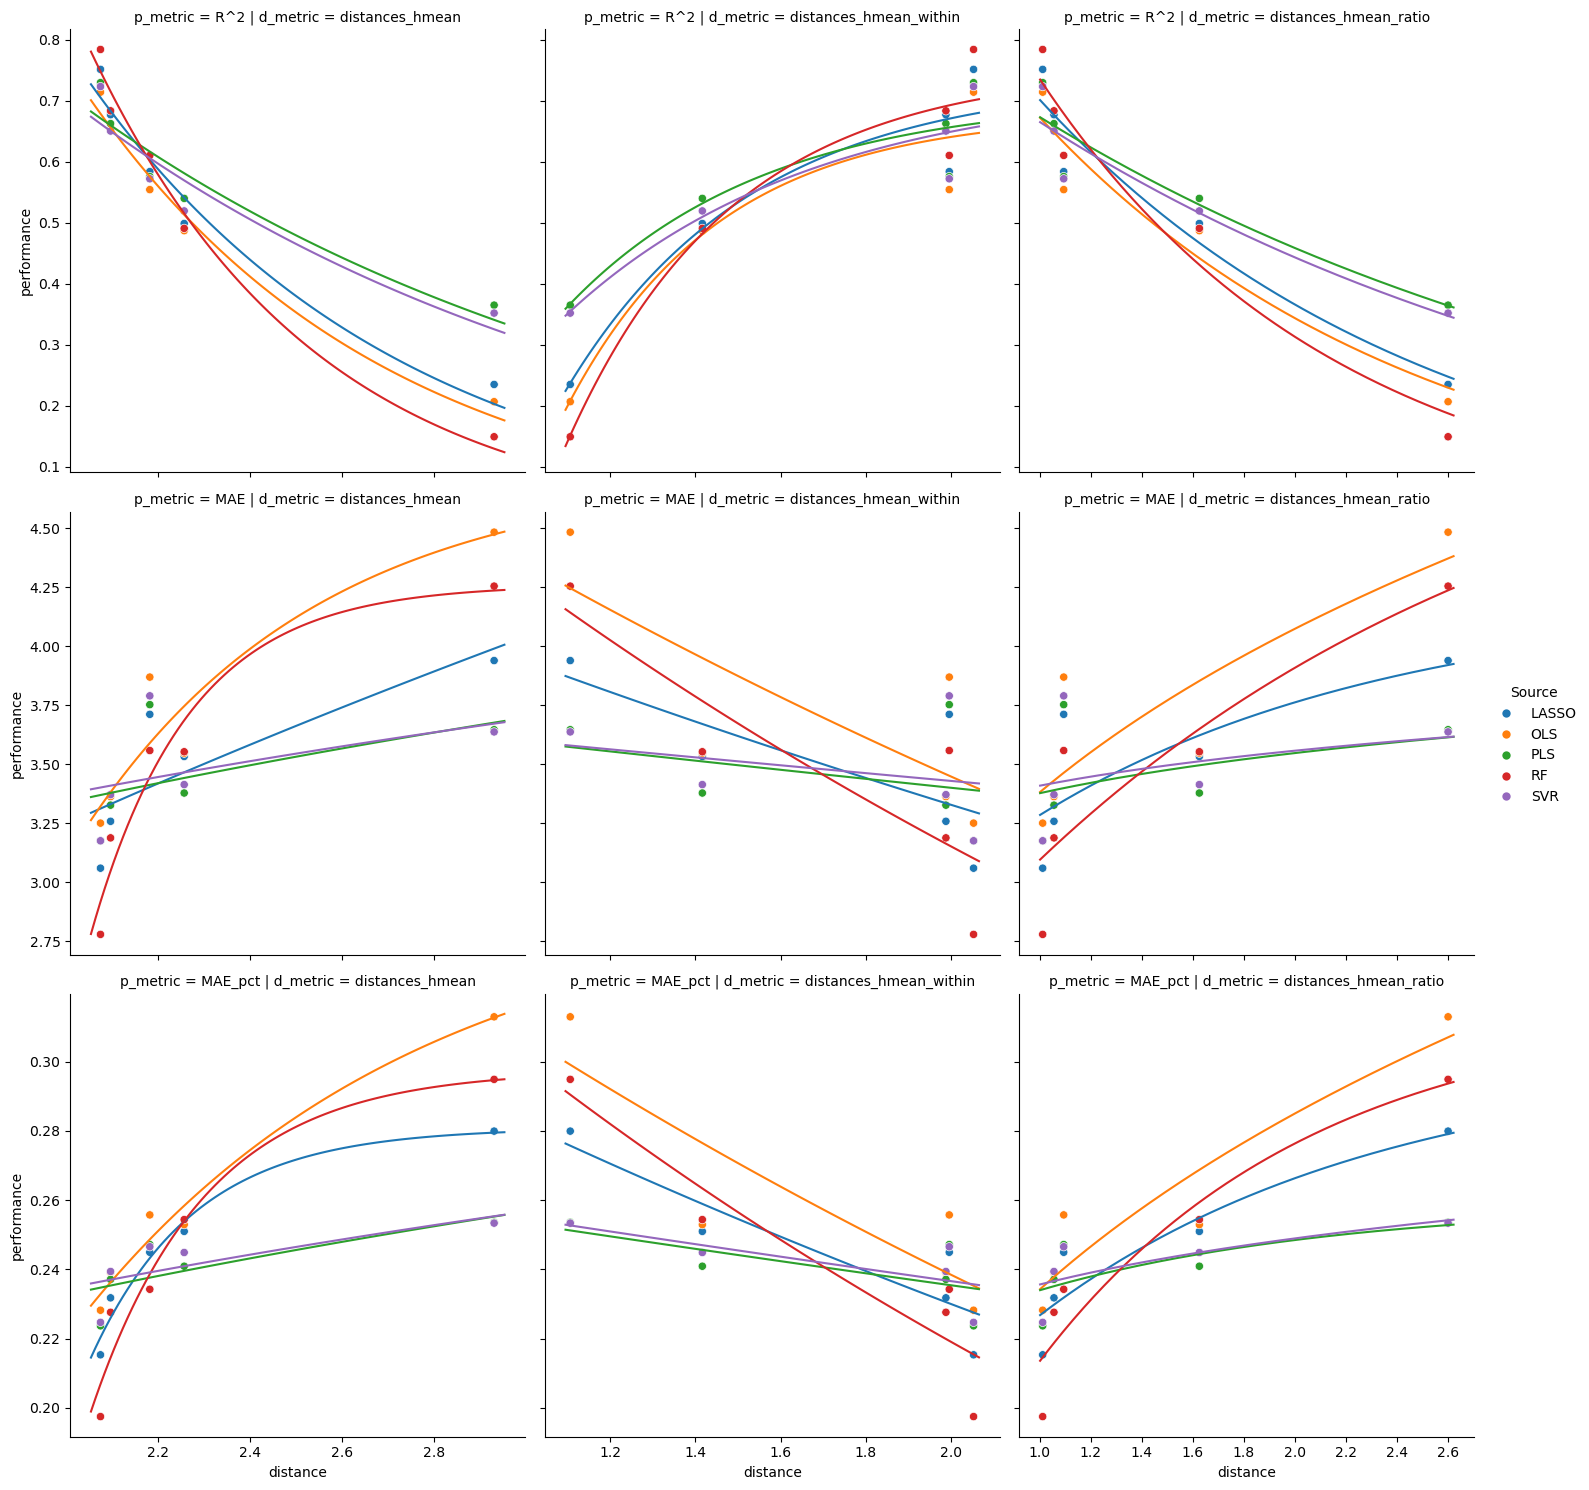

In [362]:
g = sns.relplot(x='distance', y='performance', hue='Source', col='d_metric', row='p_metric',
               #ci=None, scatter=True, #order=2,
               facet_kws=dict(sharey='row', sharex='col', legend_out=True),
               data=df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_both_t_long_mean['p_metric'].isin(['R^2', 'MAE', 'MAE_pct']) &
               df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'kmeans'])],
               row_order=['R^2', 'MAE', 'MAE_pct'])

for d_idx, x_var in enumerate(['distances_hmean', 'distances_hmean_within', 'distances_hmean_ratio']):
    df_sub = df_both_t_long_mean[df_both_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
    df_both_t_long_mean['p_metric'].isin(['R^2', 'MAE', 'MAE_pct']) &
    df_both_t_long_mean['cv'].isin(['Ecosite', 'Plot', 'Spatial', 'Year', 'kmeans']) &
    (df_both_t_long_mean['d_metric'] == x_var)]
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['p_metric'] == 'R^2') & (df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['p_metric'] == 'R^2') & (df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes[0, d_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
    
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['p_metric'] == 'MAE') & (df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['p_metric'] == 'MAE') & (df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes[1, d_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                                 func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])
    
    for s_idx, s in enumerate(df_sub['Source'].unique()):
        x = df_sub['distance'][(df_sub['p_metric'] == 'MAE_pct') & (df_sub['Source'] == s)].values
        y = df_sub['performance'][(df_sub['p_metric'] == 'MAE_pct') & (df_sub['Source'] == s)].values
        if y[np.argmin(x)] > y[np.argmax(x)]:
            func_use = func_ed
        else:
            func_use = func_asym
        try:
            popt, pcov = curve_fit(func_use, x, y)
            if func_use == func_asym:
                if popt[1] < -1e5:
                    func_use = func_pwr
                    popt, pcov = curve_fit(func_use, x, y)
        except RuntimeError:
            func_use = func_pwr
            popt, pcov = curve_fit(func_use, x, y)
        g.axes[2, d_idx].plot(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01),
                              func_use(np.arange(min(df_sub['distance'])*buff_min, max(df_sub['distance'])*buff_max, 0.01), *popt), c=tab_cols[s_idx])

#for ax in g.axes.flatten():
#    ax.set_xlabel(x_var)

In [353]:
df_both_k = pd.concat([df_all_k, df_kmeans_t[df_kmeans_t['cv'] == 'kmeans']])

In [438]:
df_both_k.groupby('Source')[sub_cols + ['Source']].groupby('Source').corr(method='spearman')

Source    kfold     MAE    Bias    MAE_bt  MAE_pct     R^2       r  \
0   CPER_2022   kfold1  0.3055  0.0230  244.1593   0.2930  0.4832  0.6999   
1   CPER_2022  kfold10  0.3046  0.1067  206.7156   0.2910  0.5396  0.7564   
2   CPER_2022   kfold2  0.2741  0.0204  215.3327   0.2562  0.5871  0.7677   
3   CPER_2022   kfold3  0.3117  0.0278  257.9926   0.2987  0.5425  0.7396   
4   CPER_2022   kfold4  0.2795  0.0617  215.8168   0.2598  0.6133  0.7906   
..        ...      ...     ...     ...       ...      ...     ...     ...   
55    ENS_ALL        0  3.1445  1.9167  164.1283   0.2501  0.2026  0.6729   
56    ENS_ALL        1  4.8698  1.8227  353.5170   0.2712  0.3411  0.6431   
57    ENS_ALL        2  3.0720  1.4853  119.1167   0.2954  0.2852  0.6345   
58    ENS_ALL        3  3.2507 -1.2833  209.1218   0.2150  0.5045  0.7418   
59    ENS_ALL        4  4.2829 -3.0088  303.8873   0.2626  0.2944  0.7149   

        cv  distances_centroid_all_mean  distances_centroid_kfolds_mean  \
0     Plot                     0.085283                        1.403128   
1     Plot                     0.272772                        1.451697   
2     Plot                     0.100573                        1.377289   
3     Plot                     0.076444                        1.369300   
4     Plot                     0.076261                        1.361027   
..     ...                          ...                             ...   
55  kmeans                     1.583258                        2.440062   
56  kmeans                     5.282861                        5.129869   
57  kmeans                     4.073047                        3.829039   
58  kmeans                     1.824183                        2.220423   
59  kmeans                     1.117901                        2.280072   

    distances_centroid_kfolds_min  distances_centroid_all_hmean  \
0                        0.276243                      0.085283   
1                        0.202802                      0.272772   
2                        0.330336                      0.100573   
3                        0.392454                      0.076444   
4                        0.358866                      0.076261   
..                            ...                           ...   
55                       1.432733                      1.583258   
56                       3.575459                      5.282861   
57                       2.016473                      4.073047   
58                       0.834126                      1.824183   
59                       1.010127                      1.117901   

    distances_centroid_kfolds_hmean  distances_mean  distances_hmean  \
0                          0.842354        3.124172         2.009299   
1                          0.774353        3.186771         2.077816   
2                          0.843763        3.055454         1.963682   
3                          0.879728        3.169050         2.063210   
4                          0.855931        3.080212         1.982669   
..                              ...             ...              ...   
55                         2.358662        3.004204         2.152872   
56                         4.842219        5.444372         4.341804   
57                         3.469608        4.330136         3.522308   
58                         1.628038        3.194363         2.591877   
59                         1.750250        2.927953         2.048183   

    distances_mean_within  distances_hmean_within  distances_hmean_ratio  
0                3.044659                1.964362               1.022876  
1                3.183156                2.049597               1.013768  
2                2.918623                1.908674               1.028820  
3                3.163457                2.040756               1.011003  
4                2.996093                1.944464               1.019648  
..                    ...                     ...            

In [358]:
from scipy.stats import pearsonr, spearmanr
import numpy as np
# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
sub_cols = ['distances_hmean', 'distances_hmean_within', 'distances_hmean_ratio', 'R^2', 'r', 'MAE', 'MAE_pct']
rho = df_both_k[sub_cols + ['Source']].groupby('Source').corr(method='pearson')
pval = df_both_k[sub_cols + ['Source']].groupby('Source').corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.map(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
df_cor_sig = rho.round(2).map('{:,.2f}'.format) #+ p
for c in ['R^2', 'r', 'MAE', 'MAE_pct']:
    df_cor_sig.loc[~p[c].str.contains('\*'), c] = ''
df_cor_sig = df_cor_sig.drop(
    index=['R^2', 'r', 'MAE', 'MAE_pct'], level=1).drop(
    index=['CPER_2022', 'ENS_ALL', 'ENS_LIN', 'ENS_ML', 'HGBR', 'OLS_2022', 'PCR'], level=0).drop(
    columns=['distances_hmean', 'distances_hmean_within', 'distances_hmean_ratio'])
df_cor_sig = df_cor_sig.loc[['OLS', 'LASSO', 'PLS', 'SVR', 'RF']]
df_cor_sig = df_cor_sig.rename(index={'distances_hmean': 'Between groups',
                         'distances_hmean_within': 'Within groups',
                         'distances_hmean_ratio': 'Ratio (Between:Within)'}).reset_index(names=['Model', 'Distinctness'])
#df_cor_sig.to_csv('./results/tables/ml_models/corr_distinctness_vs_performance.csv')

In [359]:
display(df_cor_sig)

Model            Distinctness    R^2      r   MAE MAE_pct
0     OLS          Between groups  -0.67  -0.66  0.73    0.68
1     OLS           Within groups   0.67   0.62         -0.36
2     OLS  Ratio (Between:Within)  -0.82  -0.79  0.53    0.65
3   LASSO          Between groups  -0.46  -0.66  0.49    0.44
4   LASSO           Within groups   0.68   0.61              
5   LASSO  Ratio (Between:Within)  -0.71  -0.78  0.36    0.48
6     PLS          Between groups  -0.41  -0.62  0.40    0.40
7     PLS           Within groups   0.67   0.66              
8     PLS  Ratio (Between:Within)  -0.67  -0.79              
9     SVR          Between groups         -0.62              
10    SVR           Within groups   0.68   0.65              
11    SVR  Ratio (Between:Within)  -0.63  -0.79              
12     RF          Between groups  -0.59  -0.70  0.62    0.62
13     RF           Within groups   0.71   0.65         -0.49
14     RF  Ratio (Between:Within)  -0.80  -0.83  0.52    0.66

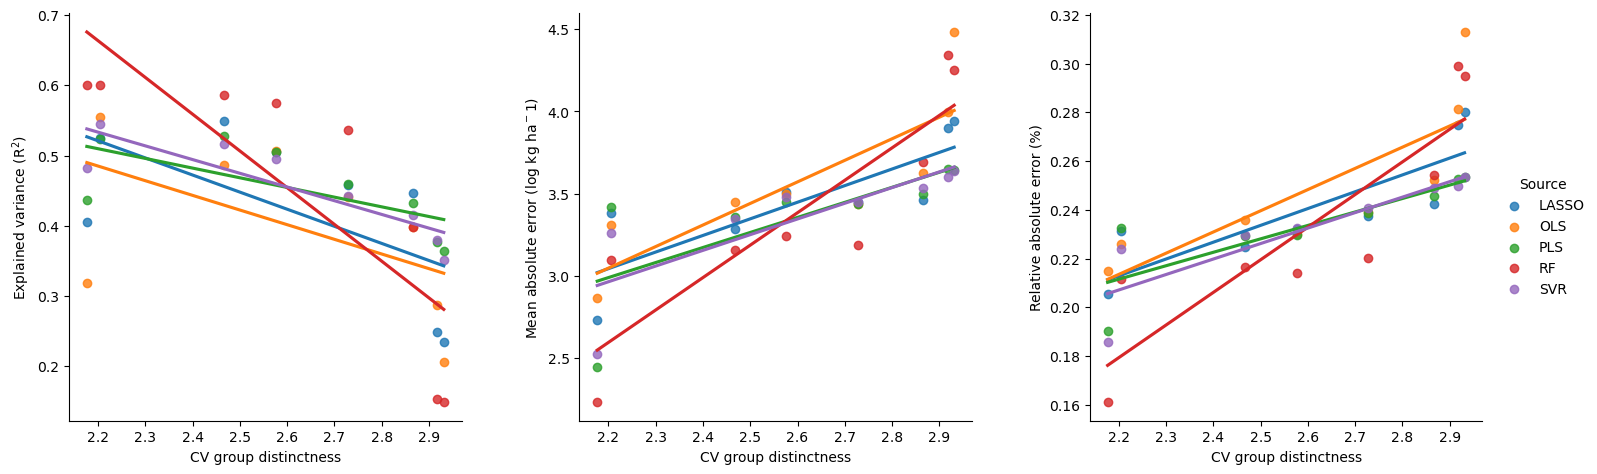

In [338]:
g = sns.lmplot(x='distances_hmean', y='value', hue='Source', col='metric',
               ci=None, scatter=True, 
               facet_kws=dict(sharey=False, legend_out=True),
               data=df_kmeans_t_long_mean[df_kmeans_t_long_mean['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_kmeans_t_long_mean['metric'].isin(['R^2', 'MAE', 'MAE_pct'])],
               col_order=['R^2', 'MAE', 'MAE_pct'])
g.axes.flatten()[0].set_ylabel('Explained variance (R$^2$)')
g.axes.flatten()[1].set_ylabel('Mean absolute error (log kg ha$^-1$)')
g.axes.flatten()[2].set_ylabel('Relative absolute error (%)')
#g.add_legend(loc='lower right')
for ax in g.axes.flatten():
    ax.set_xlabel('CV group distinctness')
    ax.set_title('')
g.fig.subplots_adjust(wspace=0.3)

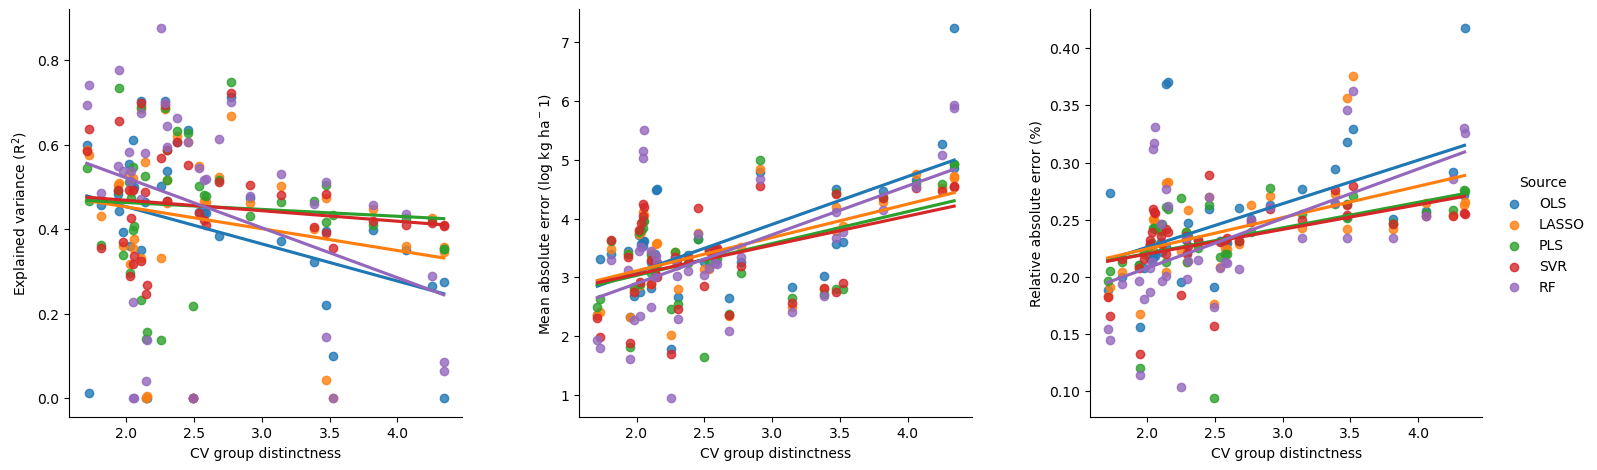

In [111]:
g = sns.lmplot(x='distances_hmean', y='value', hue='Source', col='metric',
               ci=None, scatter=True, 
               facet_kws=dict(sharey=False, legend_out=True),
               data=df_kmeans_t_long[df_kmeans_t_long['Source'].isin(['OLS', 'LASSO', 'PLS', 'SVR', 'RF']) &
               df_kmeans_t_long['metric'].isin(['R^2', 'MAE', 'MAE_pct'])],
               col_order=['R^2', 'MAE', 'MAE_pct'])
g.axes.flatten()[0].set_ylabel('Explained variance (R$^2$)')
g.axes.flatten()[1].set_ylabel('Mean absolute error (log kg ha$^-1$)')
g.axes.flatten()[2].set_ylabel('Relative absolute error (%)')
#g.add_legend(loc='lower right')
for ax in g.axes.flatten():
    ax.set_xlabel('CV group distinctness')
    ax.set_title('')
g.fig.subplots_adjust(wspace=0.3)

In [20]:
@dask.delayed
def bootstrap_pls_dist(i, df_boot, df_hls, x_vars=var_names,
                       y_var='sqrt_Biomass_kg_ha', cv_var='Year', train_col='yr_train', test_col='yr_test',
                       centroids_only=True):
    dfs_out = []
    idxs_out = []
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
    y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boot[df_boot[train_col] == i][test_col].unique():
        df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp[cv_var] == yr]
        df_year_centroids = df_year_sub[df_year_sub[cv_var] == yr][pc_names].mean(axis=0)
        df_other_centroids_yrs = df_tmp[df_tmp[cv_var] != yr].groupby('Year')[pc_names].mean()
        ed_yrs = np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids_yrs)**2, axis=1))
        df_other_centroids_all = df_tmp[df_tmp[cv_var] != yr][pc_names].mean()
        ed_all = np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids_all)**2))
        if centroids_only:
            dfs_out.append({train_col: i,
                            test_col: yr,
                            'distances_centroid_all_mean': np.mean(ed_all),
                            'distances_centroid_yrs_mean': np.mean(ed_yrs),
                            'distances_centroid_yrs_min': np.min(ed_yrs),
                            'distances_centroid_yrs_hmean': hmean(ed_yrs+1e-10)})
        else:
            distances_mean = []
            distances_median = []
            distances_q25 = []
            distances_q10 = []
            distances_q2 = []
            distances_hmean = []
            for _, row in df_year_sub.iterrows():
                point = row[pc_names].values.astype(float)
                other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
                # Calculate squared distances using broadcasting
                #sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
                #avg_distances = np.average(np.sqrt((other_points - point) ** 2), weights=r2_scores, axis=1)
                ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
                # Calculate distances using square root
                #distances.append(np.sqrt(squared_distances)) # originally run this way, means are the same, but q's different
                distances_mean.append(np.mean(ec_wdistances))
                distances_median.append(np.median(ec_wdistances))
                distances_q25.append(np.quantile(ec_wdistances, 0.25))
                distances_q10.append(np.quantile(ec_wdistances, 0.10))
                distances_q2.append(np.quantile(ec_wdistances, 0.02))
                distances_hmean.append(hmean(ec_wdistances+1e-10))
            dfs_out.append({train_col: i,
                            test_col: yr,
                            'distances_centroid_all_mean': np.mean(ed_all),
                            'distances_centroid_yrs_mean': np.mean(ed_yrs),
                            'distances_centroid_yrs_min': np.min(ed_yrs),
                            'distances_centroid_yrs_hmean': hmean(ed_yrs+1e-10),
                            'distances_mean': np.mean(distances_mean),
                           'distances_median': np.mean(distances_median),
                           'distances_q25': np.mean(distances_q25),
                            'distances_q10': np.mean(distances_q10),
                           'distances_q2': np.mean(distances_q2),
                           'distances_hmean': np.mean(distances_hmean)})
            #idxs_out.append(df_boot.loc[(df_boot[train_col] == i) &
            #                (df_boot[test_col] == yr)].index)
    df_out = pd.DataFrame(dfs_out)
    return df_out

In [31]:
i = df_boots_yr_transect['yr_train'].unique()[0]
df_boot = df_boots_yr_transect
df_hls = df_year
x_vars=var_names
y_var='sqrt_Biomass_kg_ha'
cv_var='Year'
train_col='yr_train'
test_col='yr_test'
yrs_train = [int(x) for x in i[1:-1].split(' ')]
X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

pc = PLSRegression(n_components=5)
pc.fit(X_scaled, y)

PLSRegression(n_components=5)

In [70]:
#df_boots_yr_transect
#df_year

In [71]:
df_boots_yr_transect['yr_test'] = df_boots_yr_transect['yr_test'].astype(int)

In [72]:
#dask.compute(bootstrap_pls_dist(i, df_boots_yr_transect, df_year, centroids_only=True))

In [73]:
#df_boots_yr_transect['yr_train'].unique()

In [74]:
yr = df_boot[df_boot[train_col] == i][test_col].unique()[0]
df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
scores = pc.transform(scaler.transform(df_tmp[var_names]))

pc_names = []
naY = y
r2_scores = []

for j in range(scores.shape[1]):
    pc_names.append('PC' + str(j+1)) 
    df_tmp['PC'+str(j+1)] = scores[:,j]
    Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

df_year_sub = df_tmp[df_tmp[cv_var] == yr]
distances_mean = []
distances_median = []
distances_q25 = []
distances_q10 = []
distances_q2 = []
for _, row in df_year_sub.iterrows():
    point = row[pc_names].values.astype(float)
    other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
    # Calculate squared distances using broadcasting
    ec_distances = np.sqrt(np.sum((other_points - point) ** 2, axis=1))

In [75]:
df_boots_yr_transect['Model'].unique()

array(['OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF', 'HGBR'], dtype=object)

In [76]:
results_tmp = [bootstrap_pls_dist(x, df_boots_yr_transect, df_year, centroids_only=False) for x in df_boots_yr_transect['yr_train'].unique()]

In [77]:
from dask.distributed import progress
results = dask.compute(*results_tmp)
#progress(results)

/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 10.39 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2024-12-13 16:33:08,393 - tornado.application - ERROR - Uncaught exception GET /individual-progress/ws (::1)
HTTPServerRequest(protocol='http', host='atlas-0018:65519', method='GET', uri='/individual-progress/ws', version='HTTP/1.1', remote_ip='::1')
Traceback (most recent call last):
  File "/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
  File "/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/project/cper_neon_aop/conda_envs/py_ml_env/lib/python3.9/site-packages/tornado/websocket.py", line 863, in accept_connection
    

In [458]:
#results

In [62]:
client.cluster.close()
client.close()

2024-06-28 12:40:25,802 - distributed.scheduler - ERROR - Task bootstrap_pls_dist-194a7237-08bd-4491-8682-39b722818e27 marked as failed because 4 workers died while trying to run it
2024-06-28 12:40:25,839 - distributed.scheduler - ERROR - Task bootstrap_pls_dist-b4dfd529-f380-4b11-8871-eea5433de1e6 marked as failed because 4 workers died while trying to run it


In [63]:
#from joblib import Parallel, delayed

In [64]:
#results = list(notebook.tqdm(Parallel(n_jobs=-1, return_as='generator')(delayed(bootstrap_pls_dist)(x, df_boots_yr_transect, df_year) for x in df_boots_yr_transect['yr_train'].unique()), total=len(df_boots_yr_transect['yr_train'].unique())))

In [88]:
df_boots2 = pd.merge(df_boots_yr_transect, pd.concat(results), on=['yr_train', 'yr_test'], how='left')
df_boots2['numb_yrs'] = df_boots2['numb_yrs'].astype(str)

In [96]:
#len(df_boots2)

35140

In [89]:
df_boots2.columns

Index(['Model', 'numb_yrs', 'yr_train', 'yr_test', 'retune_bootstrap', 'MAE',
       'MAPE', 'MAE_pct', 'R2', 'r_coef', 'R2_xfrm', 'r_coef_xfrm', 'MAE_plot',
       'MAPE_plot', 'MAE_pct_plot', 'R2_plot', 'r_coef_plot', 'R2_xfrm_plot',
       'r_coef_xfrm_plot', 'Source_type', 'distances_centroid_all_mean',
       'distances_centroid_yrs_mean', 'distances_centroid_yrs_min',
       'distances_centroid_yrs_hmean', 'distances_mean', 'distances_median',
       'distances_q25', 'distances_q10', 'distances_q2', 'distances_hmean'],
      dtype='object')

In [90]:
df_boots2.loc[df_boots2['R2_xfrm_plot'] < 0, 'R2_xfrm_plot'] = 0
df_boots2.loc[df_boots2['distances_hmean'] > 4.5, 'distances_hmean'] = 4.5

In [79]:
#df_boots2[df_boots2['Model'] == 'PLS'].sort_values('distances_centroid_min', ascending=False).head(50)

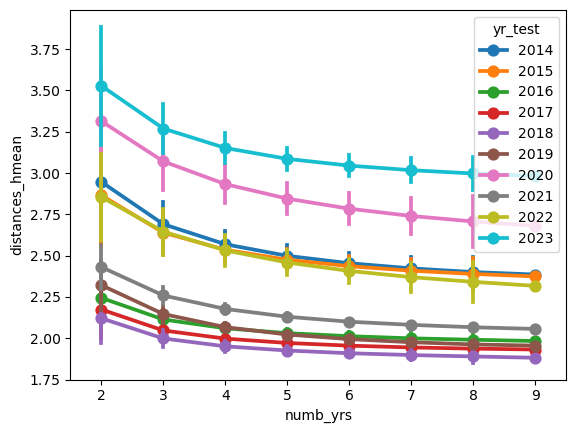

In [80]:
g = sns.pointplot(y='distances_hmean', x='numb_yrs', 
                  hue='yr_test', 
                  palette='tab10',
                  errorbar=('se', 2),
                  data=df_boots2[df_boots2['Model'] == 'PLS'])

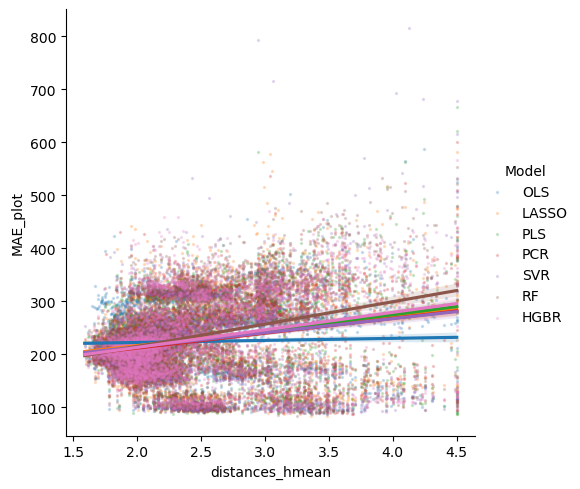

In [98]:
sns.lmplot(x='distances_hmean',
           y='MAE_plot',
           hue='Model',
           #hue='numb_yrs',
           scatter=True,
           scatter_kws=dict(alpha=0.2, s=2),
           data=df_boots2,#[df_boots2['Model'].isin(['PLS', 'RF'])],#[df_boots2['distances_q2'] < 1.5], 
           #col='numb_yrs', col_wrap=3, order=1,
           order=1,
           #ci=None,
           ci=95,#[(df_boots2['Model'] == 'RF')],
          # palette='magma'
          )

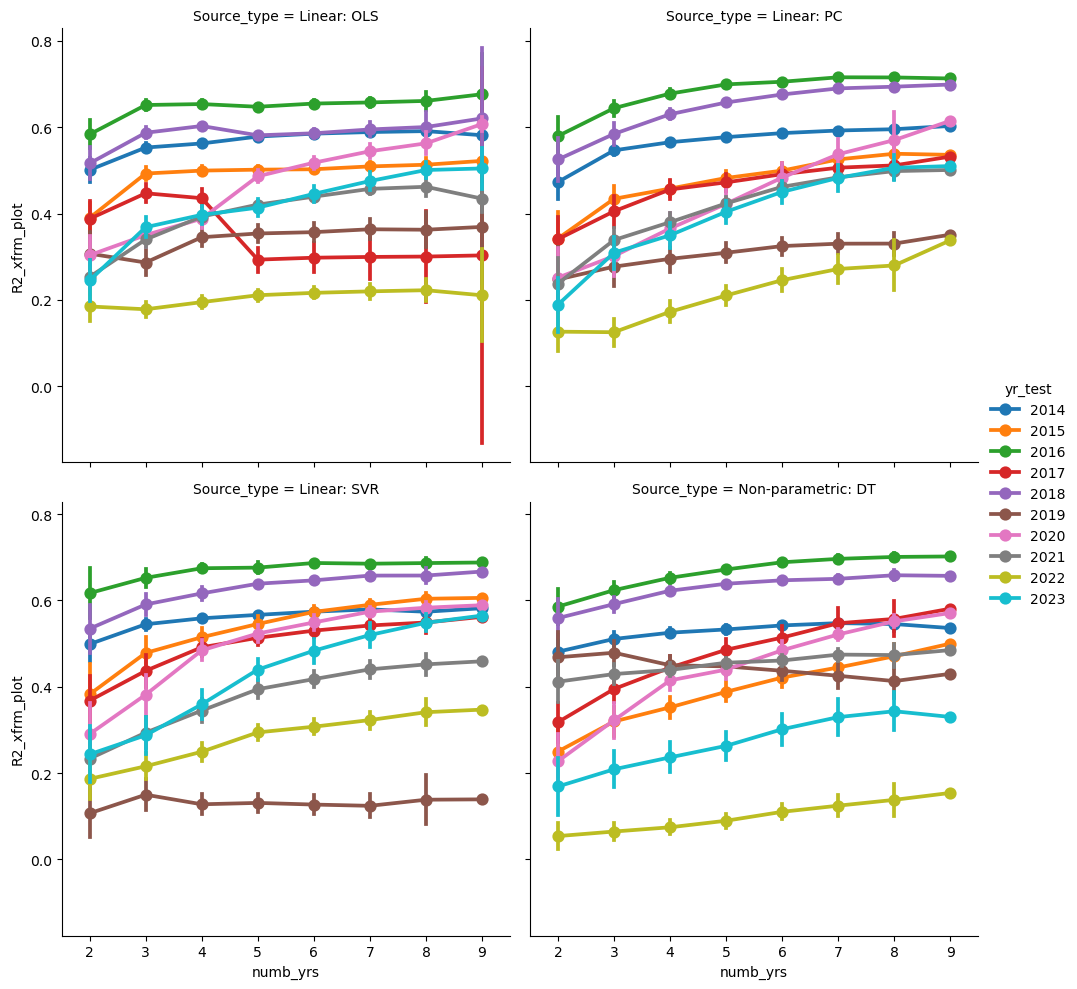

In [484]:
g = sns.catplot(kind='point', y='R2_xfrm_plot', x='numb_yrs', 
                  hue='yr_test', 
                  palette='tab10',
                  errorbar=('se', 2),
                  data=df_boots2,
                  col='Source_type', col_wrap=2)

In [508]:
qs = np.round(np.quantile(df_boots2['distances_mean'], np.arange(0, 1.2, 0.2)), 2)
df_boots2['ed_bin'] = pd.cut(df_boots2['distances_mean'],
                           bins=qs,
                           labels=['Bin ('+str(qs[i]) + ' - ' + str(qs[i+1]) + ')' for i in range(5)])

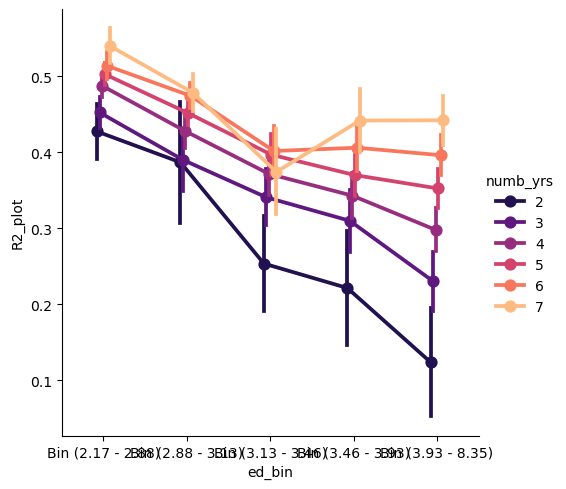

In [509]:
g = sns.catplot(kind='point', x='ed_bin', y='R2_plot', hue='numb_yrs', 
                dodge=True,
                estimator='mean',
                data=df_boots2[(df_boots2['Model'] == 'PLS') &
                (df_boots2['numb_yrs'].isin(np.arange(0, 8).astype(str)))],
                errorbar=('se', 2),
                palette='magma')

In [ ]:
for i in tqdm(df_boots_yr_transect['yr_train'].unique()):
    #print(i)
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_year[df_year['Year'].isin(yrs_train)][var_names]
    y = df_year[df_year['Year'].isin(yrs_train)]['sqrt_Biomass_kg_ha']
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boots_yr_transect[df_boots_yr_transect['yr_train'] == i]['yr_test'].unique():
        #yr = row['yr_test']
        df_tmp = df_year[df_year['Year'].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp['Year'] == yr]
        distances = []
        for _, row in df_year_sub.iterrows():
            point = row[pc_names].values.astype(float)
            other_points = df_tmp[df_tmp['Year'] != yr][pc_names].values.astype(float)
            # Calculate squared distances using broadcasting
            squared_distances = np.sum(r2_scores*((other_points - point) ** 2), axis=1)
            # Calculate distances using square root
            #distances.append(np.sqrt(squared_distances)) # originally run this way, means are the same, but q's different
            distances.append(np.mean(np.sqrt(squared_distances)))
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_mean2'] = np.mean(distances)
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_median2'] = np.median(distances)
        df_boots_yr_transect.loc[(df_boots_yr_transect['yr_train'] == i) & 
        (df_boots_yr_transect['yr_test'] == yr), 'ed_q12'] = np.quantile(distances, 0.2)    

  2%|▏         | 16/1012 [03:36<3:41:52, 13.37s/it]

In [44]:
#df_boots_yr_transect.head(50)

In [512]:
df_boots_yr_transect['ed_bin'] = pd.cut(df_boots_yr_transect['ed_mean2'],
                           bins=np.quantile(df_boots_yr_transect['ed_mean2'], np.arange(0, 1.0, 0.1)),
                           labels=['Bin'+str(x+1) for x in range(9)])

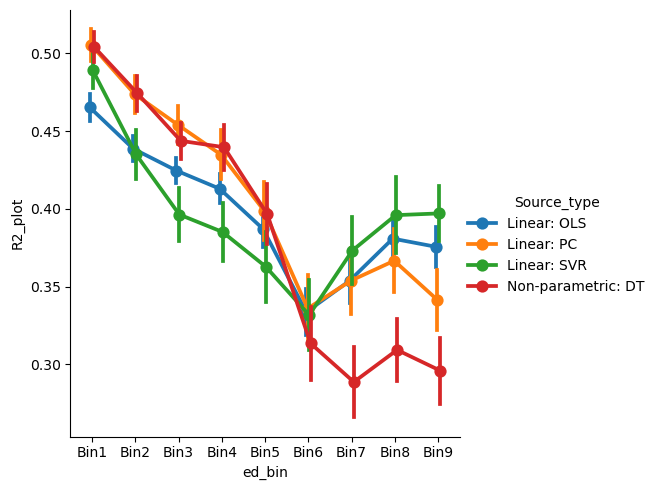

In [513]:
g = sns.catplot(kind='point', x='ed_bin', y='R2_plot', hue='Source_type', 
                dodge=True, estimator='mean',
                data=df_boots_yr_transect,
                errorbar=('se', 2))

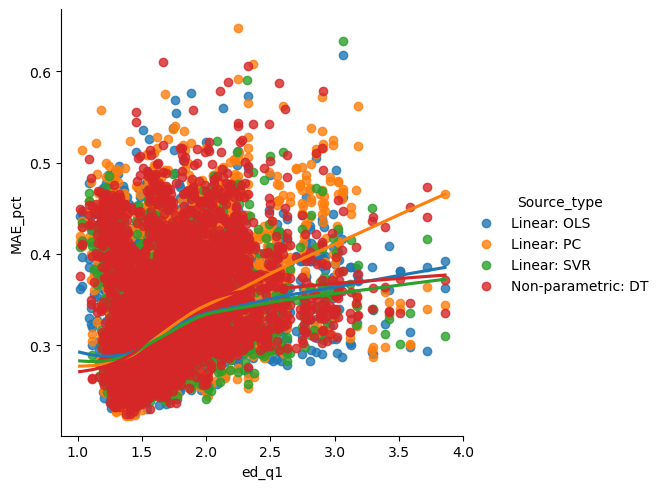

In [39]:
g = sns.lmplot(x='ed_q1', y='MAE_pct', hue='Source_type',
                data=df_boots_yr_transect, scatter=True, lowess=True)
#g.set(ylim=(0, 0.5))

In [77]:
df_tmp

0        True
1        True
2        True
3        True
4        True
        ...  
9642    False
9643    False
9644    False
9645    False
9646    False
Name: Year, Length: 9647, dtype: bool

## Variation in predictions from bootstraps

In [8]:
from matplotlib.colors import to_rgba

In [21]:
df_boots_nyrs = pd.read_csv('./results/tmp/vor_bootstrap_pred_5yrs_10iters_transect.csv')

In [22]:
df_train = pd.read_csv('../data/training/vor_2014_2023_cln_2024_04_04_transect_hls_idxs.csv')

In [23]:
import itertools
list(itertools.combinations(df_train['Year'].unique(), 9))

[(2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022),
 (2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2023),
 (2014, 2015, 2016, 2017, 2018, 2019, 2020, 2022, 2023),
 (2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023),
 (2014, 2015, 2016, 2017, 2018, 2020, 2021, 2022, 2023),
 (2014, 2015, 2016, 2017, 2019, 2020, 2021, 2022, 2023),
 (2014, 2015, 2016, 2018, 2019, 2020, 2021, 2022, 2023),
 (2014, 2015, 2017, 2018, 2019, 2020, 2021, 2022, 2023),
 (2014, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023),
 (2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023)]

In [24]:
df_boots_nyrs_past = df_boots_nyrs.groupby(
    ['Model', 'Pasture', 'yr_test', 'yr_train', 'Season']).agg({'predicted': 'mean',
                                                    'Biomass_kg_ha': 'mean'}).reset_index()

In [25]:
df_boots_nyrs_past[(df_boots_nyrs_past['Model'] == 'SVR') &
(df_boots_nyrs_past['Pasture'] == '10S') & (df_boots_nyrs_past['yr_test'] == 2014)].yr_train.unique()

array(['2015,2016,2017,2020', '2015,2016,2017,2023',
       '2015,2016,2018,2019', '2015,2016,2018,2022',
       '2015,2016,2020,2021', '2015,2016,2020,2022',
       '2015,2017,2018,2020', '2015,2017,2019,2020',
       '2015,2017,2020,2022', '2015,2017,2021,2022',
       '2015,2018,2019,2022', '2015,2019,2021,2022',
       '2015,2020,2021,2023', '2015,2021,2022,2023',
       '2016,2017,2018,2023', '2016,2017,2019,2020',
       '2016,2017,2019,2022', '2016,2017,2020,2021',
       '2016,2019,2022,2023', '2016,2020,2022,2023',
       '2017,2019,2020,2021', '2017,2019,2020,2022',
       '2017,2020,2021,2023', '2017,2021,2022,2023',
       '2018,2019,2021,2022', '2018,2021,2022,2023',
       '2019,2020,2021,2023', '2020,2021,2022,2023'], dtype=object)

In [26]:
with pd.option_context('display.max_rows', 100):
    #display(df_boots_nyrs[(df_boots_nyrs['Model'] == 'OLS') & 
    #        (df_boots_nyrs['yr_test'] == 2020) & (df_boots_nyrs['Pasture'] == 'CN')])
    #display(df_boots_nyrs.groupby('Model').value_counts(['yr_test']))
    display(df_boots_nyrs_past.groupby(['Pasture']).value_counts(['yr_test']).head(50))

Pasture  yr_test
10S      2017       480
         2014       448
         2015       432
         2016       432
         2018       359
         2019       304
         2020       196
         2021       160
         2022        42
15E      2017       480
         2014       448
         2015       432
         2016       432
         2018       359
         2019       304
         2020       196
         2021       160
         2022        42
17N      2017       480
         2014       448
         2015       432
         2016       432
         2018       360
         2019       304
         2020       196
         2021       160
         2022        42
17S      2017       480
         2014       448
         2015       432
         2016       432
         2018       360
         2019       304
         2020       196
         2021       160
         2022        42
18S      2017       480
         2014       448
         2015       432
         2016       432
         2018       360

In [27]:
#df_boots_nyrs[df_boots_nyrs['Model'] == 'OLS'].iloc[:50]

In [28]:
"""cols_replace = ['Biomass_kg_ha', 'Id', 'Pasture', 'Date_mean', 'Year', 'Season']
for mod in df_boots_nyrs['Model'].unique():
    if mod == 'OLS':
        continue
    else:
        nrows = len(df_boots_nyrs[df_boots_nyrs['Model'] == mod])
        df_ols_sub = df_boots_nyrs[df_boots_nyrs['Model'] == 'OLS'].iloc[:nrows].copy()
        for c in cols_replace:
            df_boots_nyrs.loc[df_boots_nyrs['Model'] == mod, c] = df_ols_sub[c].values"""

"cols_replace = ['Biomass_kg_ha', 'Id', 'Pasture', 'Date_mean', 'Year', 'Season']\nfor mod in df_boots_nyrs['Model'].unique():\n    if mod == 'OLS':\n        continue\n    else:\n        nrows = len(df_boots_nyrs[df_boots_nyrs['Model'] == mod])\n        df_ols_sub = df_boots_nyrs[df_boots_nyrs['Model'] == 'OLS'].iloc[:nrows].copy()\n        for c in cols_replace:\n            df_boots_nyrs.loc[df_boots_nyrs['Model'] == mod, c] = df_ols_sub[c].values"

In [29]:
df_boots_nyrs_past = df_boots_nyrs.groupby(
    ['Model', 'Pasture', 'yr_train', 'yr_test', 'Season']).agg({'predicted': 'mean',
                                                                'Biomass_kg_ha': 'mean'}).reset_index()

In [30]:
df_boots_nyrs_past['yr_test'] = pd.Categorical(df_boots_nyrs_past['yr_test'],
                                               categories=df_boots_nyrs_past['yr_test'].sort_values(ascending=True).unique(),
                                               ordered=True)
df_boots_nyrs_past = df_boots_nyrs_past[df_boots_nyrs_past['Model'].isin(['OLS', 'PLS', 'SVR', 'RF'])].copy()
df_boots_nyrs_past['Model'] = pd.Categorical(df_boots_nyrs_past['Model'],
                                               categories=['OLS', 'PLS', 'SVR', 'RF'],
                                               ordered=True)

<Axes: xlabel='yr_test', ylabel='predicted'>

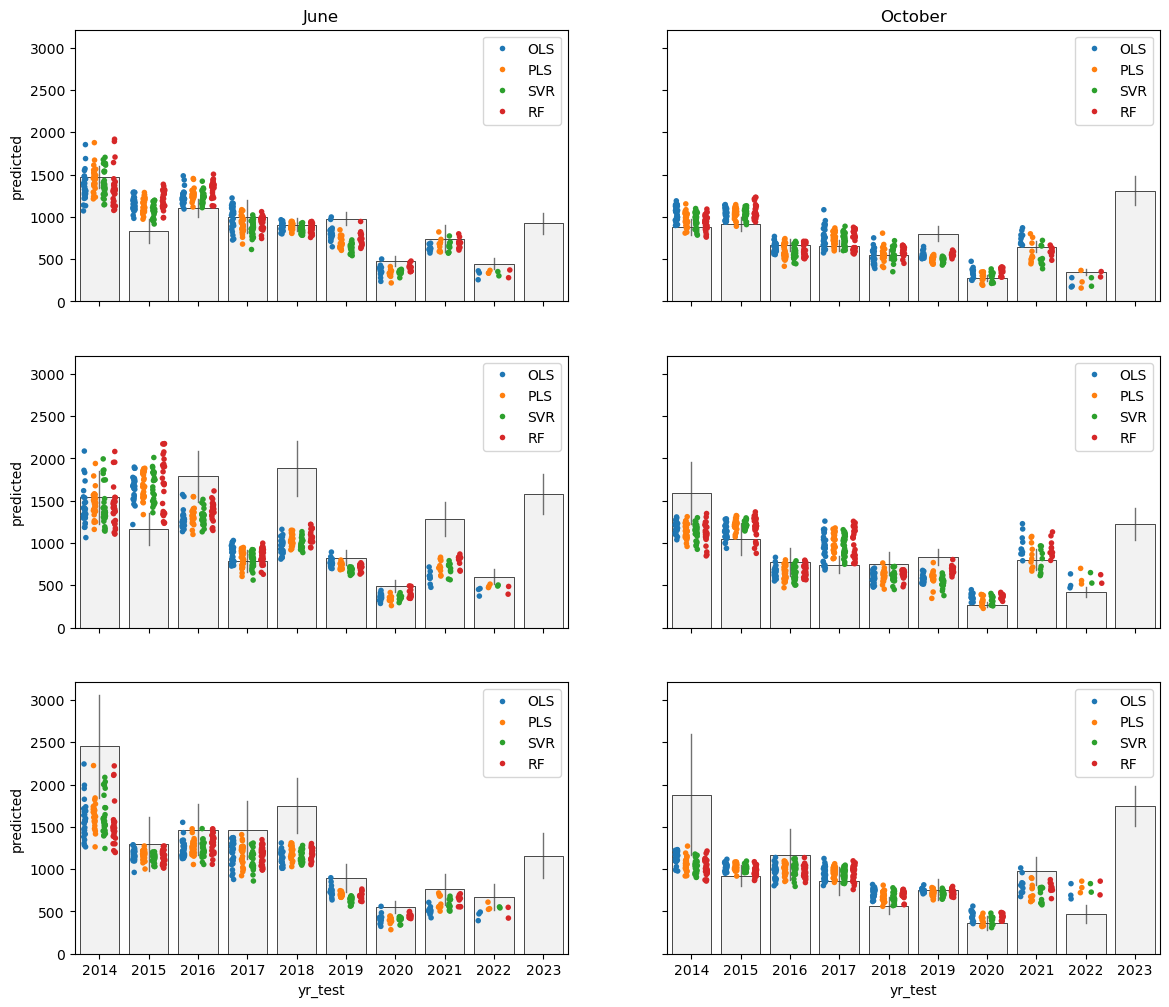

In [31]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True, sharey=True)

pasture='15E'
season = 'June'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[0, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[0, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})
axs[0, 0].set_title('June')

pasture='15E'
season = 'October'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[0, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[0, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})
axs[0, 1].set_title('October')

pasture='19N'
season = 'June'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[1, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[1, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})

season = 'October'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[1, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[1, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})

pasture='17S'
season = 'June'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[2, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[2, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})

season = 'October'
sns.stripplot(y='predicted', x='yr_test', hue='Model', dodge=True, jitter=True, s=4,
              ax=axs[2, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[2, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=('se', 2),
            err_kws={'alpha': 0.75, 'linewidth':1})

<Axes: xlabel='yr_test', ylabel='predicted'>

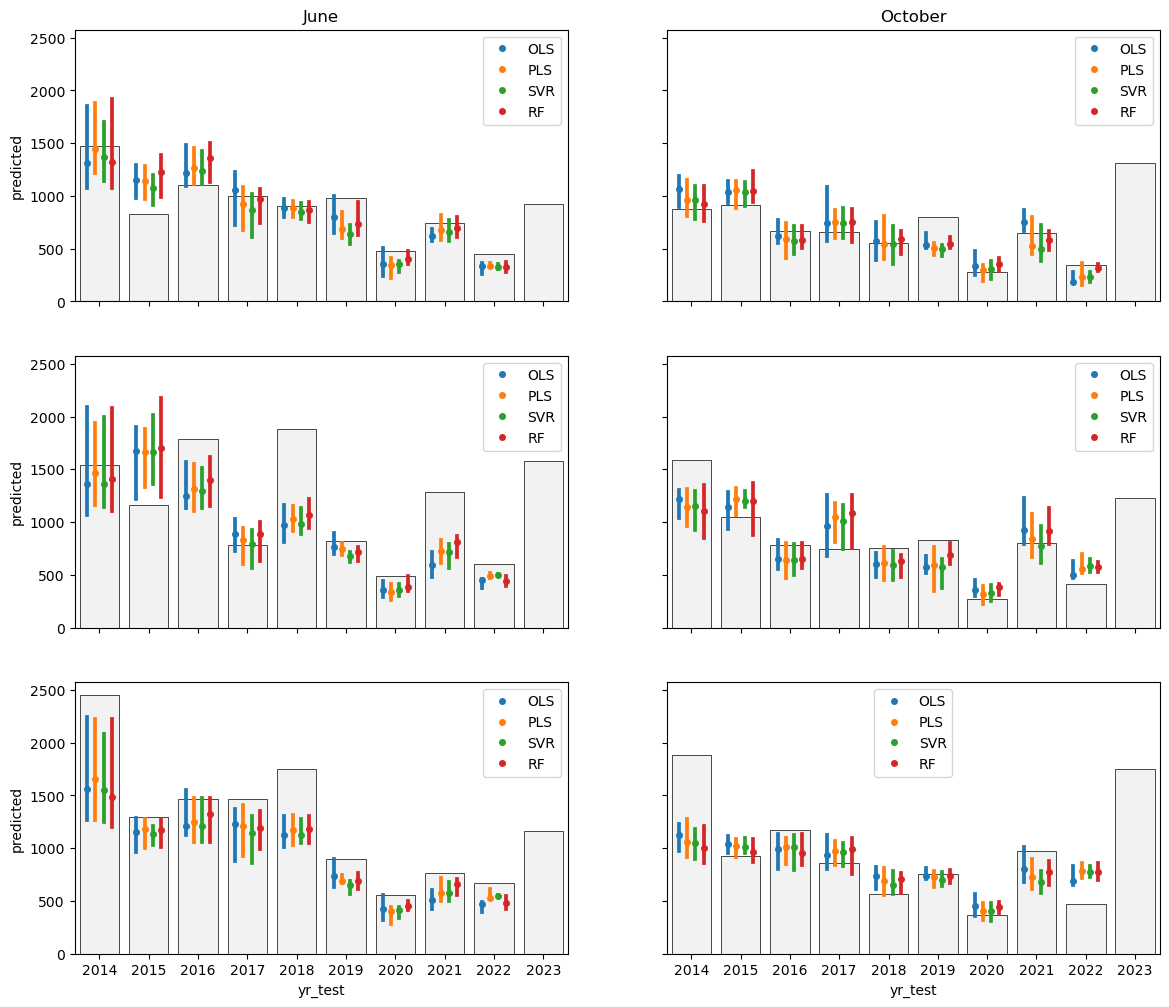

In [32]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True, sharey=True)

pasture='15E'
season = 'June'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[0, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[0, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})
axs[0, 0].set_title('June')

pasture='15E'
season = 'October'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[0, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[0, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})
axs[0, 1].set_title('October')

pasture='19N'
season = 'June'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[1, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[1, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})

season = 'October'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[1, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[1, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})

pasture='17S'
season = 'June'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[2, 0],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[2, 0],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})

season = 'October'
sns.pointplot(y='predicted', x='yr_test', hue='Model', dodge=0.5, linestyle="none", markersize=3, estimator='median', errorbar=lambda x: (min(x), max(x)),
              ax=axs[2, 1],
            data=df_boots_nyrs_past[(df_boots_nyrs_past['Season'] == season) &
            (df_boots_nyrs_past['Pasture'] == pasture)])
sns.barplot(y='Biomass_kg_ha', x='Year',
            data=df_train[(df_train['Pasture'] == pasture) & (df_train['Season'] == season)],
            ax=axs[2, 1],
            facecolor=to_rgba('black', 0.05), edgecolor='black', linewidth=0.5,
            errorbar=None,
            err_kws={'alpha': 0.75, 'linewidth':1})

## Euclidean distance of all years

In [173]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
df_year.columns

Index(['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High',
       'Biomass_kg_ha', 'geometry', 'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2',
       'CPER_2022', 'OLS_2022', 'OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF',
       'GBR', 'DNN', 'kfold', 'cv', 'sqrt_Biomass_kg_ha', 'PC1', 'PC2'],
      dtype='object')

In [174]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [194]:
X = df_year[var_names]
y = df_year['sqrt_Biomass_kg_ha']
features = var_names
X_scaled = StandardScaler().fit_transform(X)

pc = PLSRegression(n_components=len(var_names))
pc.fit(X_scaled, y)
scores = pc.x_scores_

#pc = PCA(n_components=5).fit(X_scaled)
#scores = pc.transform(X_scaled)
#pvars = pc.explained_variance_ratio_

pc_names = []
naY = y
r2_scores = []

for i in range(scores.shape[1]):
    pc_names.append('PC' + str(i+1)) 
    df_year['PC'+str(i+1)] = scores[:,i]
    Y_pred=np.dot(pc.x_scores_[:,i].reshape(-1,1), pc.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

In [195]:
yr = 2023

In [196]:
df_year_centroids = df_year[df_year['Year'] == yr][pc_names].mean(axis=0)
df_other_centroids = df_year[df_year['Year'] != yr].groupby('Year')[pc_names].mean()#.apply(lambda x: x[pc_names].mean(axis=0))
np.mean(np.sqrt(np.sum((df_year_centroids - df_other_centroids)**2, axis=1)))

4.1899200916350035

In [227]:
np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids)**2, axis=1))

Year
2014    0.561329
2015    0.580322
2016    1.607309
2017    1.238247
2018    1.880067
2019    2.168825
2020    4.975786
2021    2.532489
2022    4.275330
dtype: float64

In [229]:
#df_year['ed'] = np.nan
for yr in notebook.tqdm(df_year['Year'].unique()):
    df_year_centroids = df_year[df_year['Year'] == yr][pc_names].mean(axis=0)
    df_other_centroids = df_year[df_year['Year'] != yr].groupby('Year')[pc_names].mean()
    ed = np.min(np.sqrt(np.sum(r2_scores*(df_year_centroids - df_other_centroids)**2, axis=1)))
    df_year.loc[df_year['Year'] == yr, 'ed_mean'] = ed

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Year', ylabel='ed_mean'>

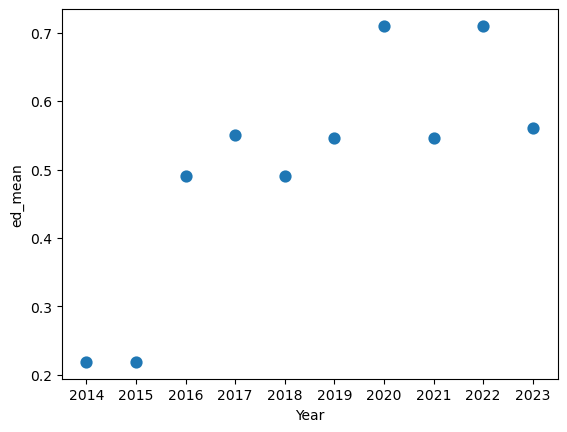

In [230]:
sns.pointplot(x='Year', y='ed_mean', data=df_year, estimator='mean', errorbar=('se', 2), linestyles='none')

In [72]:
df_year['ed'] = np.nan
for yr in notebook.tqdm(df_year['Year'].unique()):
    df_year_sub = df_year[df_year['Year'] == yr]
    for idx, row in df_year_sub.iterrows():
        point = row[pc_names].values.astype(float)
        other_points = df_year[df_year['Year'] != yr][pc_names].values.astype(float)
        # Calculate squared distances using broadcasting
        sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
        # Calculate distances using square root
        distances = (sum_distances)
        df_year.loc[idx, 'ed_mean'] = np.mean(distances)
        df_year.loc[idx, 'ed_median'] = np.median(distances)
        df_year.loc[idx, 'ed_q1'] = np.quantile(distances, 0.2)

  0%|          | 0/10 [00:00<?, ?it/s]

<Axes: xlabel='Year', ylabel='ed_mean'>

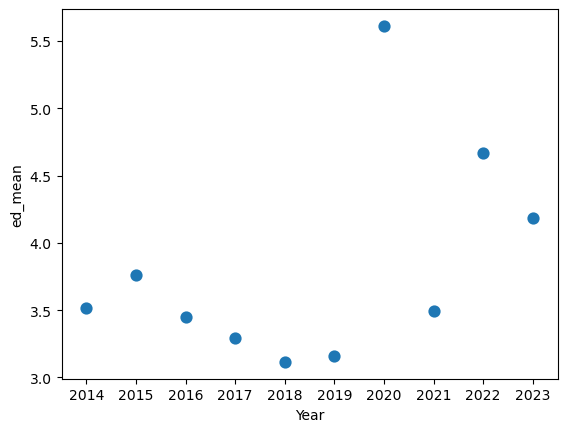

In [190]:
sns.pointplot(x='Year', y='ed_mean', data=df_year, estimator='mean', errorbar=('se', 2), linestyles='none')

In [126]:
import numpy as np

# Single point
point = df_year.iloc[0][pc_names].values.astype(float)

In [132]:
other_points = df_year.iloc[100:1120][pc_names].values.astype(float)

In [133]:
point

array([-8.4854848 , -0.04471776, -2.87938084,  0.47572877, -0.32322992])

In [134]:
# Multiple points (notice the 2D array)
#other_points = np.array([[1, 2], [5, 6]])

# Calculate squared distances using broadcasting
squared_distances = np.sum((other_points - point) ** 2, axis=1)

# Calculate distances using square root
distances = np.sqrt(squared_distances)

# Print the distances (one for each point in other_points)
print(distances)

[3.47536228 4.5406847  5.41667872 ... 2.99712738 5.76151172 4.84195031]


## Euclidean distance of individual predictions

In [26]:
df_year['sqrt_Biomass_kg_ha'] = np.sqrt(df_year['Biomass_kg_ha']) 
df_year.columns

Index(['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High',
       'Biomass_kg_ha', 'geometry', 'NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2',
       'CPER_2022', 'OLS_2022', 'OLS', 'LASSO', 'PLS', 'PCR', 'SVR', 'RF',
       'GBR', 'DNN', 'kfold', 'cv', 'sqrt_Biomass_kg_ha', 'PC1', 'PC2'],
      dtype='object')

In [27]:
var_names = ['NDVI', 'DFI', 'NDTI', 'SATVI', 'NDII7',
       'SAVI', 'RDVI', 'MTVI1', 'NCI', 'NDCI', 'PSRI', 'NDWI', 'EVI', 'TCBI',
       'TCGI', 'TCWI', 'BAI_126', 'BAI_136', 'BAI_146', 'BAI_236', 'BAI_246',
       'BAI_346', 'BLUE', 'GREEN', 'RED', 'NIR1', 'SWIR1', 'SWIR2']

In [82]:
#df_year

In [86]:
@dask.delayed
def bootstrap_pls_dist_indiv(i, df_boot, df_hls, x_vars=var_names,
                       y_var='sqrt_Biomass_kg_ha', cv_var='Year', train_col='yr_train', test_col='yr_test'):
    dfs_out = []
    idxs_out = []
    yrs_train = [int(x) for x in i[1:-1].split(' ')]
    X = df_hls[df_hls[cv_var].isin(yrs_train)][x_vars]
    y = df_hls[df_hls[cv_var].isin(yrs_train)][y_var]
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    pc = PLSRegression(n_components=5)
    pc.fit(X_scaled, y)
    for yr in df_boot[df_boot[train_col] == i][test_col].unique():
        df_tmp = df_hls[df_hls[cv_var].isin(yrs_train + [yr])].copy()
        scores = pc.transform(scaler.transform(df_tmp[var_names]))
    
        pc_names = []
        naY = y
        r2_scores = []
        
        for j in range(scores.shape[1]):
            pc_names.append('PC' + str(j+1)) 
            df_tmp['PC'+str(j+1)] = scores[:,j]
            Y_pred=np.dot(pc.x_scores_[:,j].reshape(-1,1), pc.y_loadings_[:,j].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
            r2_scores.append(round(r2_score(y, Y_pred),3))
    
        df_year_sub = df_tmp[df_tmp[cv_var] == yr]
        #df_year_others = df_tmp[df_tmp[cv_var] != yr]
        distances_mean = []
        distances_median = []
        distances_q25 = []
        distances_q10 = []
        distances_q2 = []
        for _, row in df_year_sub.iterrows():
            point = row[pc_names].values.astype(float)
            other_points = df_tmp[df_tmp[cv_var] != yr][pc_names].values.astype(float)
            # Calculate squared distances using broadcasting
            #sum_distances = np.sum(r2_scores*np.sqrt((other_points - point) ** 2), axis=1)
            #avg_distances = np.average(np.sqrt((other_points - point) ** 2), weights=r2_scores, axis=1)
            ec_wdistances = np.sqrt(np.sum(r2_scores*(other_points - point) ** 2, axis=1))
            distances_mean.append(np.mean(ec_wdistances))
            distances_median.append(np.median(ec_wdistances))
            distances_q25.append(np.quantile(ec_wdistances, 0.25))
            distances_q10.append(np.quantile(ec_wdistances, 0.10))
            distances_q2.append(np.quantile(ec_wdistances, 0.02))
        X_sub = df_year_sub[x_vars]
        X_sub_scaled = scaler.transform(X_sub)
        preds = pc.predict(X_sub_scaled)
        dfs_out.append(pd.DataFrame({
            'numb_yrs': len(i.split(' ')),
            train_col: i,
            test_col: yr,
            'Predicted': preds,
            'Observed': df_year_sub[y_var],
            'distances_mean': distances_mean,
            'distances_median': distances_median,
            'distances_q25': distances_q25,
            'distances_q10': distances_q10,
            'distances_q2': distances_q2
        },
                      index=np.arange(0, len(preds))))
        #idxs_out.append(df_boot.loc[(df_boot[train_col] == i) &
        #                (df_boot[test_col] == yr)].index)
    df_out = pd.concat(dfs_out, ignore_index=True)
    return df_out

In [87]:
results_tmp = [bootstrap_pls_dist_indiv(x, df_boots_yr_transect, df_year) for x in df_boots_yr_transect['yr_train'].unique()]

In [88]:
results = dask.compute(*results_tmp)

In [89]:
df_dist_indiv = pd.concat(results, ignore_index=True)

In [90]:
df_dist_indiv[~df_dist_indiv['Observed'].isnull()].groupby(['numb_yrs', 'yr_test']).count()

yr_train  Predicted  Observed  distances_mean  \
numb_yrs yr_test                                                  
2        2014        31104      31104     31104           31104   
         2015          576        576       576             576   
3        2014        72576      72576     72576           72576   
         2015         1344       1344      1344            1344   
4        2014       108864     108864    108864          108864   
         2015         2016       2016      2016            2016   
5        2014       108864     108864    108864          108864   
         2015         2016       2016      2016            2016   
6        2014        72576      72576     72576           72576   
         2015         1344       1344      1344            1344   
7        2014        31104      31104     31104           31104   
         2015          576        576       576             576   
8        2014         7776       7776      7776            7776   
         2015          144        144       144             144   
9        2014          864        864       864             864   
         2015           16         16        16              16   

                  distances_median  distances_q25  distances_q10  distances_q2  
numb_yrs yr_test                                                                
2        2014                31104          31104          31104         31104  
         2015                  576            576            576           576  
3        2014                72576          72576          72576         72576  
         2015                 1344           1344           1344          1344  
4        2014               108864         108864         108864        108864  
         2015                 2016           2016           2016          2016  
5        2014               108864         108864         108864        108864  
         2015                 2016           2016           2016          2016  
6        2014                72576          72576          72576         72576  
         2015                 1344           1344           1344          1344  
7        2014                31104          31104          31104         31104  
         2015                  576            576            576           576  
8        2014                 7776           7776           7776          7776  
         2015                  144            144            144           144  
9        2014                  864            864            864           864  
         2015                   16             16             16            16

In [91]:
df_dist_indiv# = df_dist_indiv[~df_dist_indiv['Observed'].isnull()].copy()

numb_yrs                                        yr_train  yr_test  \
0               2                                     [2015 2016]     2014   
1               2                                     [2015 2016]     2014   
2               2                                     [2015 2016]     2014   
3               2                                     [2015 2016]     2014   
4               2                                     [2015 2016]     2014   
...           ...                                             ...      ...   
4842789         9  [2014 2015 2016 2017 2018 2019 2020 2021 2022]     2023   
4842790         9  [2014 2015 2016 2017 2018 2019 2020 2021 2022]     2023   
4842791         9  [2014 2015 2016 2017 2018 2019 2020 2021 2022]     2023   
4842792         9  [2014 2015 2016 2017 2018 2019 2020 2021 2022]     2023   
4842793         9  [2014 2015 2016 2017 2018 2019 2020 2021 2022]     2023   

         Predicted   Observed  distances_mean  distances_median  \
0        41.625272  35.781039        5.035972          5.093309   
1        34.011432  39.458992        3.171597          3.241365   
2        28.869392  27.313363        2.496591          2.571529   
3        27.165781  26.783380        2.868473          3.061992   
4        26.751125  35.893127        2.799636          2.942262   
...            ...        ...             ...               ...   
4842789  31.703516        NaN        2.599674          2.395181   
4842790  30.379562        NaN        2.543689          2.323436   
4842791  30.348155        NaN        2.597443          2.319651   
4842792  28.499206        NaN        2.467797          2.222687   
4842793  28.270311        NaN        2.606834          2.238224   

         distances_q25  distances_q10  distances_q2  
0             3.385169       2.289775      1.112819  
1             1.606537       0.962019      0.498257  
2             1.497945       0.981752      0.566999  
3             1.801586       1.283827      0.702491  
4             1.815973       1.298247      0.739276  
...                ...            ...           ...  
4842789       1.473005       0.938838      0.495932  
4842790       1.401716       0.880748      0.469110  
4842791       1.368927       0.887362      0.484397  
4842792       1.323576       0.805305      0.449266  
4842793       1.289029       0.832583      0.449239  

[4842794 rows x 10 columns]

In [41]:
#df_dist_indiv['numb_yrs'] = df_dist_indiv.apply(lambda x: len(x['yr_train'].split(' ')), axis=1)

In [48]:
len(df_dist_indiv['Predicted'].iloc[0])

864

In [142]:
client.cluster.close()
client.close()

In [194]:
X = df_year[var_names]
y = df_year['sqrt_Biomass_kg_ha']
features = var_names
X_scaled = StandardScaler().fit_transform(X)

pc = PLSRegression(n_components=len(var_names))
pc.fit(X_scaled, y)
scores = pc.x_scores_

#pc = PCA(n_components=5).fit(X_scaled)
#scores = pc.transform(X_scaled)
#pvars = pc.explained_variance_ratio_

pc_names = []
naY = y
r2_scores = []

for i in range(scores.shape[1]):
    pc_names.append('PC' + str(i+1)) 
    df_year['PC'+str(i+1)] = scores[:,i]
    Y_pred=np.dot(pc.x_scores_[:,i].reshape(-1,1), pc.y_loadings_[:,i].reshape(-1,1).T)*naY.std(axis=0, ddof=1)+naY.mean(axis=0)
    r2_scores.append(round(r2_score(y, Y_pred),3))

## Individual models

<Axes: xlabel='cv', ylabel='R^2'>

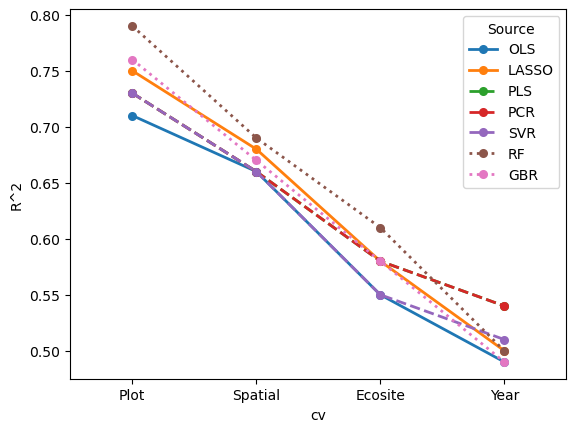

In [8]:
sns.pointplot(x='cv', y='R^2', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt'>

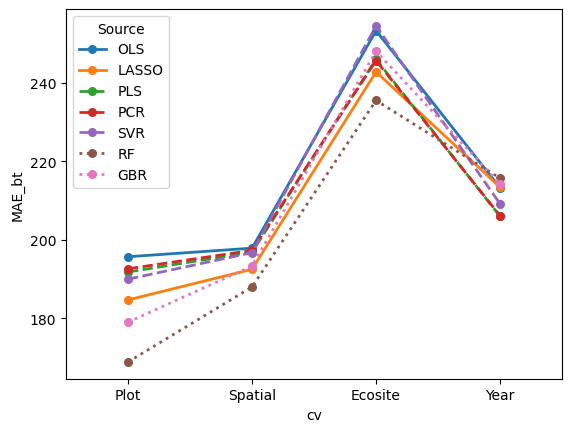

In [9]:
sns.pointplot(x='cv', y='MAE_bt', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='MAE_bt_pct'>

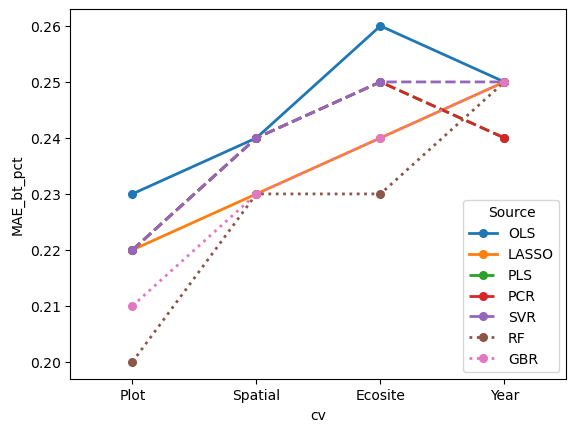

In [10]:
sns.pointplot(x='cv', y='MAE_bt_pct', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)

<Axes: xlabel='cv', ylabel='r'>

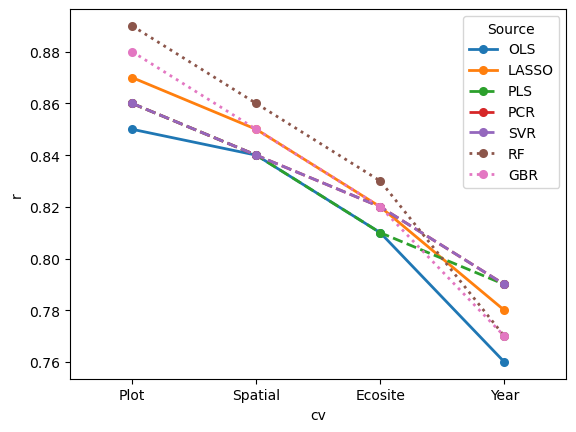

In [11]:
sns.pointplot(x='cv', y='r', data=t_all, hue='Source',
              linestyles=['solid', 'solid', 'dashed', 'dashed', 'dashed', 'dotted', 'dotted'],
              linewidth=2)